TODO:
* Create a transformation to rename colnames
* Create a class for transforming the datatype of date-columns from string to datetime.
* Use of binary indicator imputation has led to the creation of a few correlated features (binary indicator features)

Alternate approaches:
- Discretize all continuous features. Do not do any power transformation.
- `sub_grade` is a mixed variable. Currently being treated as categorical. Consider separating numbers and caracters in it.

In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import pylab
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from feature_engine import missing_data_imputers as mdi
from feature_engine import variable_transformers as vt
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce
from category_encoders import ordinal

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df0 = pd.read_csv('./dataset/loan_data_2007_2014.csv', index_col=0)

/home/srini/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# No of columns with null values
tmp = df0.isna().sum()
tmp[tmp > 0].shape

(40,)

# Preprocessing

## Match features with correct data types

In [4]:
rename_colnames_map = {
    'id': 'loan_id',
    'member_id': 'borrower_id',
    'loan_amnt': 'loan_applied_amount',
    'funded_amnt': 'loan_funded_amount',
    'funded_amnt_inv': 'investor_commit_amount',
    'term': 'term',
    'int_rate': 'interest_rate',
    'installment': 'installment_amount',
    'grade': 'grade',
    'sub_grade': 'sub_grade',
    'emp_title': 'employement_title',
    'emp_length': 'employement_length',
    'home_ownership': 'home_ownership',
    'annual_inc': 'annual_income',
    'verification_status': 'verification_status',
    'issue_d': 'issue_date',
    'loan_status': 'loan_status',
    'pymnt_plan': 'is_pymnt_plan_in_place',
    'url': 'url',
    'desc': 'description',
    'purpose': 'loan_purpose',
    'title': 'loan_title',
    'zip_code': 'zip_code',
    'addr_state': 'addr_state',
    'dti': 'debt_to_income',
    'delinq_2yrs': 'no_of_delinquencies',
    'earliest_cr_line': 'earliest_credit_line_date',
    'inq_last_6mths': 'no_of_inquires_6months',
    'mths_since_last_delinq': 'months_since_last_delinq',
    'mths_since_last_record': 'months_since_last_record',
    'open_acc': 'open_credit_lines',
    'pub_rec': 'no_of_derog_public_records',
    'revol_bal': 'revolving_balance',
    'revol_util': 'revolving_utilization_rate',
    'total_acc': 'no_of_credit_lines',
    'initial_list_status': 'initial_listing_status',
    'out_prncp': 'outstanding_amount',
    'out_prncp_inv': 'outstanding_amount_inv',
    'total_pymnt': 'returned_amount',
    'total_pymnt_inv': 'returned_amount_inv',
    'total_rec_prncp': 'returned_principal_amount',
    'total_rec_int': 'returned_interest_amount',
    'total_rec_late_fee': 'paid_late_fee_amount',
    'recoveries': 'recoveries_amount',
    'collection_recovery_fee': 'collection_fee',
    'last_pymnt_d': 'last_payment_date',
    'last_pymnt_amnt': 'last_payment_amount',
    'next_pymnt_d': 'next_payment_date',
    'last_credit_pull_d': 'last_credit_pull_date',
    'collections_12_mths_ex_med': 'no_of_collections_12_mths_ex_med',
    'mths_since_last_major_derog': 'months_since_last_rating_derog',
    'policy_code': 'policy_code',
    'application_type': 'application_type',
    'annual_inc_joint': 'annual_income_joint',
    'dti_joint': 'debt_to_joint_income',
    'verification_status_joint': 'verification_status_joint',
    'acc_now_delinq': 'no_of_accounts_delinquent',
    'tot_coll_amt': 'total_collection_amount',
    'tot_cur_bal': 'total_current_balance',
    'open_acc_6m': 'no_of_open_credit_lines_6months',
    'open_il_6m': 'no_of_installment_accounts_6months',
    'open_il_12m': 'no_of_installment_accounts_12months',
    'open_il_24m': 'no_of_installment_accounts_24months',
    'mths_since_rcnt_il': 'months_since_instmnt_opened',
    'total_bal_il': 'balance_amount_all_installments',
    'il_util': 'il_util',
    'open_rv_12m': 'no_of_revolving_trades_12months',
    'open_rv_24m': 'no_of_revolving_trades_24months',
    'max_bal_bc': 'max_balance_amount', 
    'all_util': 'all_util',
    'total_rev_hi_lim': 'total_rev_hi_lim',
    'inq_fi': 'no_of_finance_inquiries',
    'total_cu_tl': 'no_of_finance_trades',
    'inq_last_12m': 'no_of_inquires_12months',
}


df0.rename(columns=rename_colnames_map, inplace=True)

**Potentially important features**  

Features about the loan:
- loan_funded_amount
- term
- interest_rate
- loan_purpose
- grade and sub_grade

Features about the borrower:
- employement_length
- home_ownership
- annual_income
- address_state and zip_code
- debt_to_income

Target:
- loan_statues

In [5]:
catg_colnames = [
    'loan_id', 'borrower_id', 'grade', 'sub_grade', 'employement_title',
     'home_ownership', 'verification_status', 'loan_status', 'is_pymnt_plan_in_place',
    'url', 'description', 'loan_purpose', 'loan_title', 'zip_code', 'addr_state', 
    'initial_listing_status', 'application_type', 'verification_status_joint',
    'term', 'employement_length',
]

to_drop_colnames = ['loan_id', 'borrower_id', 'url', 'description',]

continuous_num_colnames = [
    'loan_applied_amount', 'loan_funded_amount', 'investor_commit_amount', 
    'installment_amount', 'interest_rate', 'annual_income', 'debt_to_income', 
    'revolving_balance', 'outstanding_amount',
    'outstanding_amount_inv', 'returned_amount', 'returned_amount_inv', 
    'revolving_utilization_rate', 'returned_principal_amount', 'returned_interest_amount',
    'paid_late_fee_amount', 'recoveries_amount', 'collection_fee', 'last_payment_amount',
    'policy_code', 'annual_income_joint', 'debt_to_joint_income', 
    'total_collection_amount', 'total_current_balance', 'balance_amount_all_installments',
    'il_util', 'max_balance_amount', 'all_util', 'total_rev_hi_lim', 
    
]

discrete_num_colnames = [
    'no_of_delinquencies', 'no_of_inquires_6months', 
    'months_since_last_delinq', 'months_since_last_record', 
    'open_credit_lines', 'no_of_derog_public_records',
    'no_of_credit_lines', 'no_of_collections_12_mths_ex_med', 'months_since_last_rating_derog',
    'no_of_accounts_delinquent', 'no_of_open_credit_lines_6months', 
    'no_of_installment_accounts_6months', 'no_of_installment_accounts_12months',
    'no_of_installment_accounts_24months', 'months_since_instmnt_opened',
    'no_of_revolving_trades_12months', 'no_of_revolving_trades_24months', 
    'no_of_finance_inquiries', 'no_of_finance_trades', 'no_of_inquires_12months'
]

date_colnames = [
    'issue_date', 'earliest_credit_line_date', 'last_payment_date',
    'next_payment_date', 'last_credit_pull_date', 
]

In [6]:
print(df0.shape[1])

all_colnames = catg_colnames + continuous_num_colnames + discrete_num_colnames + date_colnames
print(len(all_colnames))

print(len(set(all_colnames)))

df0[all_colnames].head() # Check for KeyError

74
74
74


loan_id  borrower_id grade sub_grade         employement_title  \
0  1077501      1296599     B        B2                       NaN   
1  1077430      1314167     C        C4                     Ryder   
2  1077175      1313524     C        C5                       NaN   
3  1076863      1277178     C        C1       AIR RESOURCES BOARD   
4  1075358      1311748     B        B5  University Medical Group   

  home_ownership verification_status  loan_status is_pymnt_plan_in_place  \
0           RENT            Verified   Fully Paid                      n   
1           RENT     Source Verified  Charged Off                      n   
2           RENT        Not Verified   Fully Paid                      n   
3           RENT     Source Verified   Fully Paid                      n   
4           RENT     Source Verified      Current                      n   

                                                 url  ...  \
0  https://www.lendingclub.com/browse/loanDetail....  ...   
1  https://www.lendingclub.com/browse/loanDetail....  ...   
2  https://www.lendingclub.com/browse/loanDetail....  ...   
3  https://www.lendingclub.com/browse/loanDetail....  ...   
4  https://www.lendingclub.com/browse/loanDetail....  ...   

  no_of_revolving_trades_12months no_of_revolving_trades_24months  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3                             NaN                             NaN   
4                             NaN                             NaN   

  no_of_finance_inquiries no_of_finance_trades no_of_inquires_12months  \
0                     NaN                  NaN                     NaN   
1                     NaN                  NaN                     NaN   
2                     NaN                  NaN                     NaN   
3                     NaN                  NaN                     NaN   
4                     NaN                  NaN                     NaN   

  issue_date earliest_credit_line_date  last_payment_date next_payment_date  \
0     Dec-11                    Jan-85             Jan-15               NaN   
1     Dec-11                    Apr-99             Apr-13               NaN   
2     Dec-11                    Nov-01             Jun-14               NaN   
3     Dec-11                    Feb-96             Jan-15               NaN   
4     Dec-11                    Jan-96             Jan-16            Feb-16   

  last_credit_pull_date  
0                Jan-16  
1                Sep-13  
2                Jan-16  
3                Jan-15  
4                Jan-16  

[5 rows x 74 columns]

### Modify dtype of continuous features

In [7]:
df0[continuous_num_colnames].dtypes

loan_applied_amount                  int64
loan_funded_amount                   int64
investor_commit_amount             float64
installment_amount                 float64
interest_rate                      float64
annual_income                      float64
debt_to_income                     float64
revolving_balance                    int64
outstanding_amount                 float64
outstanding_amount_inv             float64
returned_amount                    float64
returned_amount_inv                float64
revolving_utilization_rate         float64
returned_principal_amount          float64
returned_interest_amount           float64
paid_late_fee_amount               float64
recoveries_amount                  float64
collection_fee                     float64
last_payment_amount                float64
policy_code                          int64
annual_income_joint                float64
debt_to_joint_income               float64
total_collection_amount            float64
total_curre

In [8]:
cont_num_dtype_map = {colname: 'float64' for colname in continuous_num_colnames}
df0[continuous_num_colnames] = df0[continuous_num_colnames].astype(dtype=cont_num_dtype_map)

In [9]:
df0[continuous_num_colnames].dtypes

loan_applied_amount                float64
loan_funded_amount                 float64
investor_commit_amount             float64
installment_amount                 float64
interest_rate                      float64
annual_income                      float64
debt_to_income                     float64
revolving_balance                  float64
outstanding_amount                 float64
outstanding_amount_inv             float64
returned_amount                    float64
returned_amount_inv                float64
revolving_utilization_rate         float64
returned_principal_amount          float64
returned_interest_amount           float64
paid_late_fee_amount               float64
recoveries_amount                  float64
collection_fee                     float64
last_payment_amount                float64
policy_code                        float64
annual_income_joint                float64
debt_to_joint_income               float64
total_collection_amount            float64
total_curre

### Modify dtype of datetime features

In [10]:
df0[date_colnames].dtypes

issue_date                   object
earliest_credit_line_date    object
last_payment_date            object
next_payment_date            object
last_credit_pull_date        object
dtype: object

Tried the following but gave errors due to insufficient information. For eg. Sep-68 in `earliest_credit_line` was converted to `2068-09-01` instead of `1968-09-01`.
``` python
for colname in date_colnames:
    df0[colname] = pd.to_datetime(df0[colname], format='%b-%y')
```

Manually converting `date_colnames` into `datetime` datatype

In [11]:
for colname in ['issue_date', 'last_payment_date', 'next_payment_date', 'last_credit_pull_date']:
    month, year_2char = df0[colname].str.split('-').str
    year = '20' + year_2char
    month_year = month + '-' + year
    df0[colname] = pd.to_datetime(month_year)



month, year_2char = df0['earliest_credit_line_date'].str.split('-').str
year_2char_int = pd.to_numeric(year_2char).fillna(0).astype('int')
tmp_df = pd.DataFrame({'year_2char': year_2char, 'year_2char_int': year_2char_int})
tmp_df['year_2char'].fillna('', inplace=True)

def append_century(row):
    if  row['year_2char_int'] > 15:
        out = '19' + row['year_2char']
    else:
        out = '20' + row['year_2char']
    return out

earliest_credit_line_year = tmp_df.apply(lambda row: append_century(row), axis=1)
earliest_credit_line_year.replace('20', np.nan, inplace=True)
month_year = month + '-' + earliest_credit_line_year
df0['earliest_credit_line_date'] = pd.to_datetime(month_year)

In [12]:
for colname in date_colnames:
    df0[colname] = pd.to_datetime(df0[colname], format='%b-%y')

In [13]:
df0[date_colnames].dtypes

issue_date                   datetime64[ns]
earliest_credit_line_date    datetime64[ns]
last_payment_date            datetime64[ns]
next_payment_date            datetime64[ns]
last_credit_pull_date        datetime64[ns]
dtype: object

In [14]:
df0[date_colnames].head()

issue_date earliest_credit_line_date last_payment_date next_payment_date  \
0 2011-12-01                1985-01-01        2015-01-01               NaT   
1 2011-12-01                1999-04-01        2013-04-01               NaT   
2 2011-12-01                2001-11-01        2014-06-01               NaT   
3 2011-12-01                1996-02-01        2015-01-01               NaT   
4 2011-12-01                1996-01-01        2016-01-01        2016-02-01   

  last_credit_pull_date  
0            2016-01-01  
1            2013-09-01  
2            2016-01-01  
3            2015-01-01  
4            2016-01-01

In [15]:
date_dtype_map = {colname: 'datetime64' for colname in date_colnames}
date_dtype_map

{'issue_date': 'datetime64',
 'earliest_credit_line_date': 'datetime64',
 'last_payment_date': 'datetime64',
 'next_payment_date': 'datetime64',
 'last_credit_pull_date': 'datetime64'}

In [16]:
tmp = df0.isna().sum()
tmp[tmp > 0].shape

(40,)

### Modify dtype of categorical features

Use `object` and not `str` to change dtype of categorical features. Using `str` when using `astype` will not preserve null values. Using `object` with `astype` will let a column have mixed dtype and thus have `np.nan`. If the values in the column were of type `int`, they will remain to be `int` even after using `astype(object)`. https://stackoverflow.com/a/44008334. After missing value imputation, will convert categorical features into `str` data type.

In [17]:
df0[catg_colnames].dtypes

loan_id                        int64
borrower_id                    int64
grade                         object
sub_grade                     object
employement_title             object
home_ownership                object
verification_status           object
loan_status                   object
is_pymnt_plan_in_place        object
url                           object
description                   object
loan_purpose                  object
loan_title                    object
zip_code                      object
addr_state                    object
initial_listing_status        object
application_type              object
verification_status_joint    float64
term                          object
employement_length            object
dtype: object

In [18]:
catg_dtype_map = {colname: 'object' for colname in catg_colnames}
df0[catg_colnames] = df0[catg_colnames].astype(dtype=catg_dtype_map)

In [19]:
df0[catg_colnames].dtypes

loan_id                      object
borrower_id                  object
grade                        object
sub_grade                    object
employement_title            object
home_ownership               object
verification_status          object
loan_status                  object
is_pymnt_plan_in_place       object
url                          object
description                  object
loan_purpose                 object
loan_title                   object
zip_code                     object
addr_state                   object
initial_listing_status       object
application_type             object
verification_status_joint    object
term                         object
employement_length           object
dtype: object

In [20]:
type(df0['loan_id'][0])

int

In [21]:
# No of columns with null values
tmp = df0.isna().sum()
tmp[tmp > 0].shape

(40,)

### Modify dtype of discrete numeric features

Use 'Int64' instead of 'int64' (note the capital I) or 'int' to deal with NaN as integer. https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html

In [22]:
df0[discrete_num_colnames].dtypes

no_of_delinquencies                    float64
no_of_inquires_6months                 float64
months_since_last_delinq               float64
months_since_last_record               float64
open_credit_lines                      float64
no_of_derog_public_records             float64
no_of_credit_lines                     float64
no_of_collections_12_mths_ex_med       float64
months_since_last_rating_derog         float64
no_of_accounts_delinquent              float64
no_of_open_credit_lines_6months        float64
no_of_installment_accounts_6months     float64
no_of_installment_accounts_12months    float64
no_of_installment_accounts_24months    float64
months_since_instmnt_opened            float64
no_of_revolving_trades_12months        float64
no_of_revolving_trades_24months        float64
no_of_finance_inquiries                float64
no_of_finance_trades                   float64
no_of_inquires_12months                float64
dtype: object

In [23]:
disc_num_dtype_map = {colname: 'Int64' for colname in discrete_num_colnames}
df0[discrete_num_colnames] = df0[discrete_num_colnames].astype(dtype=disc_num_dtype_map)

In [24]:
df0[discrete_num_colnames].dtypes

no_of_delinquencies                    Int64
no_of_inquires_6months                 Int64
months_since_last_delinq               Int64
months_since_last_record               Int64
open_credit_lines                      Int64
no_of_derog_public_records             Int64
no_of_credit_lines                     Int64
no_of_collections_12_mths_ex_med       Int64
months_since_last_rating_derog         Int64
no_of_accounts_delinquent              Int64
no_of_open_credit_lines_6months        Int64
no_of_installment_accounts_6months     Int64
no_of_installment_accounts_12months    Int64
no_of_installment_accounts_24months    Int64
months_since_instmnt_opened            Int64
no_of_revolving_trades_12months        Int64
no_of_revolving_trades_24months        Int64
no_of_finance_inquiries                Int64
no_of_finance_trades                   Int64
no_of_inquires_12months                Int64
dtype: object

Since `feature_engine.missing_data_imputers.FrequentCategoryImputer` only works with columns of dtype `object`, convert the above columns of dtype `Int64` to `object`. 

In [25]:
df0[discrete_num_colnames] = df0[discrete_num_colnames] \
    .astype(dtype={colname: 'object' for colname in discrete_num_colnames})

In [26]:
# No of columns with null values
tmp = df0.isna().sum()
tmp[tmp > 0].shape

(40,)

## Identify lebels in target variable

In [27]:
target = 'loan_status'
df0[target].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [28]:
print('No. of missing values in target: ', df0[target].isna().sum())
print()
print('Unique values in target: ')
print(df0[target].unique().tolist())
print()

bad_loan_labels = [
    "Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", 
    "In Grace Period", "Late (16-30 days)", "Late (31-120 days)",
]
good_loan_labels = [
    'Fully Paid', 'Current', 'Does not meet the credit policy. Status:Fully Paid',
]

# Check if all the labels in target are identified
print('Are all the labels in target identified?')
print(len(df0[target].unique()) == len(bad_loan_labels + good_loan_labels))
print()

# Convert target labels as either 'bad_loans' or 'good loans'
def get_loan_condition(loan_status):
    if loan_status in bad_loan_labels:
        return 'bad loan'
    elif loan_status in good_loan_labels:
        return 'good loan'
    else:
        return 'missing'

df0[target] = df0[target].apply(get_loan_condition)

print('target labels after processing: ')
print(df0[target].unique().tolist())

No. of missing values in target:  0

Unique values in target: 
['Fully Paid', 'Charged Off', 'Current', 'Default', 'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)', 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off']

Are all the labels in target identified?
True

target labels after processing: 
['good loan', 'bad loan']


**Encode the target variable as 0 ('good loan') and 1 ('bad loan')**

In [29]:
ord_encoder = ordinal.OrdinalEncoder(
    verbose=1, 
    cols=[target], 
    mapping=[{'col': target, 'mapping': {'good loan': 0, 'bad loan': 1}}],
    return_df=True,
)
df0 = ord_encoder.fit_transform(df0)
df0[target].head()

0    0
1    1
2    0
3    0
4    0
Name: loan_status, dtype: int64

## Drop columns

In [30]:
colnames_NaN_fraction = df0.isna().mean()
colnames_NaN_fraction

loan_id                                0.000000
borrower_id                            0.000000
loan_applied_amount                    0.000000
loan_funded_amount                     0.000000
investor_commit_amount                 0.000000
term                                   0.000000
interest_rate                          0.000000
installment_amount                     0.000000
grade                                  0.000000
sub_grade                              0.000000
employement_title                      0.059166
employement_length                     0.045054
home_ownership                         0.000000
annual_income                          0.000009
verification_status                    0.000000
issue_date                             0.000000
loan_status                            0.000000
is_pymnt_plan_in_place                 0.000000
url                                    0.000000
description                            0.729815
loan_purpose                           0

In [31]:

print('low info. colnames')
print(to_drop_colnames)  # this variable is defined at the begining
print()

tmp = (df0 == df0.iloc[0]).all()
constant_val_colnames = tmp.loc[tmp].index.tolist()
print('constant value colnames:')
print(constant_val_colnames)
print()

all_NAN_colnames = list(colnames_NaN_fraction[colnames_NaN_fraction == 1].index)
print('all NaN colnames:')
print(all_NAN_colnames)
print()

high_cardinal_colnames = ['employement_title']

to_drop_colnames = list(set(to_drop_colnames + all_NAN_colnames + constant_val_colnames + high_cardinal_colnames))
print(to_drop_colnames)

low info. colnames
['loan_id', 'borrower_id', 'url', 'description']

constant value colnames:
['policy_code', 'application_type']

all NaN colnames:
['annual_income_joint', 'debt_to_joint_income', 'verification_status_joint', 'no_of_open_credit_lines_6months', 'no_of_installment_accounts_6months', 'no_of_installment_accounts_12months', 'no_of_installment_accounts_24months', 'months_since_instmnt_opened', 'balance_amount_all_installments', 'il_util', 'no_of_revolving_trades_12months', 'no_of_revolving_trades_24months', 'max_balance_amount', 'all_util', 'no_of_finance_inquiries', 'no_of_finance_trades', 'no_of_inquires_12months']

['balance_amount_all_installments', 'all_util', 'url', 'description', 'max_balance_amount', 'no_of_installment_accounts_12months', 'annual_income_joint', 'no_of_finance_inquiries', 'policy_code', 'verification_status_joint', 'no_of_revolving_trades_24months', 'loan_id', 'no_of_open_credit_lines_6months', 'no_of_finance_trades', 'no_of_inquires_12months', 'no_of

In [32]:
df0.drop(columns=to_drop_colnames, inplace=True)
df0.shape

(466285, 50)

## Train Test Split

In [33]:
predictors = df0.columns.tolist()
predictors_dtype_map = df0.dtypes.to_dict()

In [34]:
predictors.remove(target)
del predictors_dtype_map[target]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    df0[predictors],
    df0[target], 
    test_size=0.3, 
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((326399, 49), (139886, 49), (326399,), (139886,))

In [36]:
with open('./3_1.pkl', 'wb') as f:
    pickle.dump([X_train, X_test, y_train, y_test], f)
    f.close()

In [340]:
with open('./3_1.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)
    f.close()

# Feature Engineering

## Create features from datetime columns

In [341]:
date_colnames

['issue_date',
 'earliest_credit_line_date',
 'last_payment_date',
 'next_payment_date',
 'last_credit_pull_date']

In [342]:
X_train[date_colnames].max()

issue_date                  2014-12-01
earliest_credit_line_date   2011-11-01
last_payment_date           2016-01-01
next_payment_date           2016-03-01
last_credit_pull_date       2016-01-01
dtype: datetime64[ns]

In [343]:
X_train[date_colnames].min()

issue_date                  2007-06-01
earliest_credit_line_date   1944-01-01
last_payment_date           2007-12-01
next_payment_date           2007-12-01
last_credit_pull_date       2007-05-01
dtype: datetime64[ns]

In [344]:
# reference_date is larger than max of all the date columns
reference_now = pd.to_datetime('2019-01-01')

In [345]:
class MonthsFromDate(BaseEstimator, TransformerMixin):
    """
    """
    def __init__(self, variables):
        self.reference_date = pd.to_datetime('2019-01-01')
        self.date_colnames = variables
        self.months_colnames = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        self.months_colnames = list()
        for colname in self.date_colnames:
            months_colname = f'months_since_{colname}'
            self.months_colnames.append(months_colname)
            X[months_colname] = round((self.reference_date - X[colname]) / np.timedelta64(1, 'M'))
            X[months_colname] = X[months_colname].astype('Int64')
            # X[months_colname] = X[months_colname].astype('object')
        X.drop(columns=self.date_colnames, inplace=True)
        return X

In [346]:
months_from_date = MonthsFromDate(variables=date_colnames)
months_from_date.fit(X_train)
X_train = months_from_date.transform(X_train)
X_test = months_from_date.transform(X_test)

In [347]:
months_colnames = months_from_date.months_colnames

In [348]:
X_train[months_colnames].head()

months_since_issue_date  months_since_earliest_credit_line_date  \
251191                       50                                     213   
282397                       51                                     136   
125617                       67                                     220   
356942                       54                                     231   
210834                       78                                     144   

        months_since_last_payment_date  months_since_next_payment_date  \
251191                              36                              35   
282397                              36                              35   
125617                              37                              35   
356942                              36                              35   
210834                              73                             NaN   

        months_since_last_credit_pull_date  
251191                                  36  
282397                                  36  
125617                                  36  
356942                                  36  
210834                                  68

In [349]:
X_train[months_colnames].dtypes

months_since_issue_date                   Int64
months_since_earliest_credit_line_date    Int64
months_since_last_payment_date            Int64
months_since_next_payment_date            Int64
months_since_last_credit_pull_date        Int64
dtype: object

In [350]:
X_train[months_colnames].isna().sum()

months_since_issue_date                        0
months_since_earliest_credit_line_date        19
months_since_last_payment_date               252
months_since_next_payment_date            158775
months_since_last_credit_pull_date            32
dtype: int64

Since `feature_engine.missing_data_imputers.FrequentCategoryImputer` only works with columns of dtype `object`, from the above columns convert the ones that have missing values from dtype `Int64` to `object`. 

In [351]:
tmp = X_train[months_colnames].isna().sum()
int_to_object_colnames = tmp[tmp != 0].index.tolist()
int_to_object_colnames

['months_since_earliest_credit_line_date',
 'months_since_last_payment_date',
 'months_since_next_payment_date',
 'months_since_last_credit_pull_date']

In [352]:
class IntToObject(BaseEstimator, TransformerMixin):
    """
    """
    def __init__(self, variables):
        self.colnames = variables

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.colnames] = X[self.colnames].astype(dtype={colname: 'object' for colname in self.colnames})
        return X


In [353]:
int_to_object = IntToObject(variables=int_to_object_colnames)

In [354]:
int_to_object.fit(X_train)

IntToObject(variables=None)

In [355]:
X_train = int_to_object.transform(X_train)
X_test = int_to_object.transform(X_test)

In [356]:
X_train.dtypes.unique()

array([dtype('float64'), dtype('O'), Int64Dtype()], dtype=object)

## Missing value imputation

In [357]:
def get_NaN_fraction(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a DataFrame with column names and the fraction of 
    NaN values in that column. Column names are sorted based on 
    fraction of NaN values, in descending order. Columns which do 
    not have any NaN values will not be shown in the output
    """
    colnames_NaN_fraction = df.isna().mean()
    nan_frac_df = (colnames_NaN_fraction[colnames_NaN_fraction != 0.0]
        .to_frame()
        .reset_index()
        .rename(columns={'index': 'column_names', 0: 'NaN_fraction'})
        .sort_values(by='NaN_fraction', ascending=False)
    )
    return nan_frac_df

In [358]:
nan_frac_df = get_NaN_fraction(X_train)
nan_frac_df

column_names  NaN_fraction
6                 months_since_last_record      0.865903
12          months_since_last_rating_derog      0.787637
5                 months_since_last_delinq      0.536619
19          months_since_next_payment_date      0.486445
16                        total_rev_hi_lim      0.150442
15                   total_current_balance      0.150442
14                 total_collection_amount      0.150442
0                       employement_length      0.044936
18          months_since_last_payment_date      0.000772
9               revolving_utilization_rate      0.000741
11        no_of_collections_12_mths_ex_med      0.000331
20      months_since_last_credit_pull_date      0.000098
13               no_of_accounts_delinquent      0.000058
8               no_of_derog_public_records      0.000058
7                        open_credit_lines      0.000058
4                   no_of_inquires_6months      0.000058
17  months_since_earliest_credit_line_date      0.000058
3                      no_of_delinquencies      0.000058
10                      no_of_credit_lines      0.000058
2                               loan_title      0.000040
1                            annual_income      0.000006

**Columns which have null values in more than 5% of the observations are treated differently, as far as missing value imputation is concerned, compared with columns that have null values in less than 5% of observations.**

In [359]:
colnames_low_nan_frac = nan_frac_df.loc[nan_frac_df['NaN_fraction'] <= 0.05, 'column_names'].values.tolist()
colnames_high_nan_frac = nan_frac_df.loc[nan_frac_df['NaN_fraction'] > 0.05, 'column_names'].values.tolist()

In [360]:
len(nan_frac_df), len(set(colnames_low_nan_frac + colnames_high_nan_frac))

(21, 21)

In [361]:
len(colnames_low_nan_frac), len(colnames_high_nan_frac)

(14, 7)

### Features with low fraction of missing values:

- Median imputer for numeric features (using Feature-Engine)
- Frequent category imputer for categorical features (using Feature-Engine)

In [362]:
X_train[colnames_low_nan_frac].dtypes

employement_length                         object
months_since_last_payment_date             object
revolving_utilization_rate                float64
no_of_collections_12_mths_ex_med           object
months_since_last_credit_pull_date         object
no_of_accounts_delinquent                  object
no_of_derog_public_records                 object
open_credit_lines                          object
no_of_inquires_6months                     object
months_since_earliest_credit_line_date     object
no_of_delinquencies                        object
no_of_credit_lines                         object
loan_title                                 object
annual_income                             float64
dtype: object

In [363]:
tmp = X_train[colnames_low_nan_frac].dtypes
catg_colnames_low_nan_frac = tmp[tmp == 'object'].index.tolist()
cont_num_colnames_low_nan_frac = tmp[tmp == 'float64'].index.tolist()

print('catgorical features with low fraction (<= 0.05) of nan: ')
print(catg_colnames_low_nan_frac)
print()
print('continuous numerical features with low fraction (<= 0.05) of nan: ')
print(cont_num_colnames_low_nan_frac)


catgorical features with low fraction (<= 0.05) of nan: 
['employement_length', 'months_since_last_payment_date', 'no_of_collections_12_mths_ex_med', 'months_since_last_credit_pull_date', 'no_of_accounts_delinquent', 'no_of_derog_public_records', 'open_credit_lines', 'no_of_inquires_6months', 'months_since_earliest_credit_line_date', 'no_of_delinquencies', 'no_of_credit_lines', 'loan_title']

continuous numerical features with low fraction (<= 0.05) of nan: 
['revolving_utilization_rate', 'annual_income']


In [364]:
median_imputer = mdi.MeanMedianImputer(imputation_method='median', variables=cont_num_colnames_low_nan_frac)
median_imputer.fit(X_train)
X_train= median_imputer.transform(X_train)
X_test= median_imputer.transform(X_test)

In [365]:
'''
# need this for converting dtypes after FrequentCategoryImputer()
predictors_dtype_map = X_train.dtypes.to_dict()
'''

'\n# need this for converting dtypes after FrequentCategoryImputer()\npredictors_dtype_map = X_train.dtypes.to_dict()\n'

FrequentCategoryImputer changes the datatype of some columns of dtype `object` into `int64`. This is because the values in these columns are of type `Int64` inspite of the column being of type `object`.

In [366]:
freq_catg_imputer = mdi.FrequentCategoryImputer(variables=catg_colnames_low_nan_frac)
freq_catg_imputer.fit(X_train)
X_train = freq_catg_imputer.transform(X_train)
X_test = freq_catg_imputer.transform(X_test)

In [367]:
X_train[catg_colnames_low_nan_frac].dtypes

employement_length                        object
months_since_last_payment_date             int64
no_of_collections_12_mths_ex_med           int64
months_since_last_credit_pull_date         int64
no_of_accounts_delinquent                  int64
no_of_derog_public_records                 int64
open_credit_lines                          int64
no_of_inquires_6months                     int64
months_since_earliest_credit_line_date     int64
no_of_delinquencies                        int64
no_of_credit_lines                         int64
loan_title                                object
dtype: object

In [368]:
'''
# Converting the columns with int64 dtype into object dtype.
X_train = X_train.astype(dtype=predictors_dtype_map)
'''

'\n# Converting the columns with int64 dtype into object dtype.\nX_train = X_train.astype(dtype=predictors_dtype_map)\n'

In [369]:
'''
X_train[catg_colnames_low_nan_frac].dtypes
'''

'\nX_train[catg_colnames_low_nan_frac].dtypes\n'

### Features with high fraction of missing values:

In [370]:
tmp = X_train[colnames_high_nan_frac].dtypes
catg_colnames_high_nan_frac = tmp[tmp == 'object'].index.tolist()
cont_num_colnames_high_nan_frac = tmp[tmp == 'float64'].index.tolist()

In [371]:
X_train[colnames_high_nan_frac].dtypes

months_since_last_record           object
months_since_last_rating_derog     object
months_since_last_delinq           object
months_since_next_payment_date     object
total_rev_hi_lim                  float64
total_current_balance             float64
total_collection_amount           float64
dtype: object

In [372]:
add_binary_imputer = mdi.AddNaNBinaryImputer(
    variables=cont_num_colnames_high_nan_frac + catg_colnames_high_nan_frac
)

add_binary_imputer.fit(X_train)
X_train = add_binary_imputer.transform(X_train)
X_test = add_binary_imputer.transform(X_test)

In [373]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((326399, 56), (139886, 56), (326399,), (139886,))

In [374]:
# New binary columns are created.
binary_nan_imputer_colnames = [colname for colname in X_train.columns if colname.endswith('_na')]
binary_nan_imputer_colnames

['total_rev_hi_lim_na',
 'total_current_balance_na',
 'total_collection_amount_na',
 'months_since_last_record_na',
 'months_since_last_rating_derog_na',
 'months_since_last_delinq_na',
 'months_since_next_payment_date_na']

In [375]:
X_train[binary_nan_imputer_colnames].dtypes

total_rev_hi_lim_na                  int64
total_current_balance_na             int64
total_collection_amount_na           int64
months_since_last_record_na          int64
months_since_last_rating_derog_na    int64
months_since_last_delinq_na          int64
months_since_next_payment_date_na    int64
dtype: object

**Note that the newly created binary features are of the dtype `int64`.**

In [376]:
median_imputer = mdi.MeanMedianImputer(imputation_method='median', variables=cont_num_colnames_high_nan_frac)
median_imputer.fit(X_train)
X_train = median_imputer.transform(X_train)
X_test = median_imputer.transform(X_test)

In [377]:
'''
predictors_dtype_map = X_train.dtypes.to_dict()
'''

'\npredictors_dtype_map = X_train.dtypes.to_dict()\n'

In [378]:
freq_catg_imputer = mdi.FrequentCategoryImputer(variables=catg_colnames_high_nan_frac)
freq_catg_imputer.fit(X_train)
X_train = freq_catg_imputer.transform(X_train)
X_test = freq_catg_imputer.transform(X_test)

FrequentCategoryImputer changes the datatype of some columns of dtype `object` into `int64`. This is because the values in these columns are of type `Int64` inspite of the column being of type `object`.

In [379]:
X_train[catg_colnames_high_nan_frac].dtypes

months_since_last_record          int64
months_since_last_rating_derog    int64
months_since_last_delinq          int64
months_since_next_payment_date    int64
dtype: object

In [380]:
'''
# Converting the columns with int64 dtype into object dtype.
X_train = X_train.astype(dtype=predictors_dtype_map)
'''

'\n# Converting the columns with int64 dtype into object dtype.\nX_train = X_train.astype(dtype=predictors_dtype_map)\n'

In [381]:
'''
X_train[catg_colnames_high_nan_frac].dtypes
'''

'\nX_train[catg_colnames_high_nan_frac].dtypes\n'

In [382]:
# None of the columns should have any null values.

tmp = X_train.isna().sum()
tmp[tmp != 0]

Series([], dtype: int64)

In [383]:
tmp = X_test.isna().sum()
tmp[tmp != 0]

Series([], dtype: int64)

## Discrete features as numeric

In [384]:
print(X_train.dtypes[(X_train.dtypes == 'int64') | (X_train.dtypes == 'Int64')])
print()
all_int64_colnames = X_train.dtypes[(X_train.dtypes == 'int64') | (X_train.dtypes == 'Int64')].index.tolist()
print(all_int64_colnames)

no_of_delinquencies                       int64
no_of_inquires_6months                    int64
months_since_last_delinq                  int64
months_since_last_record                  int64
open_credit_lines                         int64
no_of_derog_public_records                int64
no_of_credit_lines                        int64
no_of_collections_12_mths_ex_med          int64
months_since_last_rating_derog            int64
no_of_accounts_delinquent                 int64
months_since_issue_date                   Int64
months_since_earliest_credit_line_date    int64
months_since_last_payment_date            int64
months_since_next_payment_date            int64
months_since_last_credit_pull_date        int64
total_rev_hi_lim_na                       int64
total_current_balance_na                  int64
total_collection_amount_na                int64
months_since_last_record_na               int64
months_since_last_rating_derog_na         int64
months_since_last_delinq_na             

In [385]:
discrete_num_colnames = [colname for colname in all_int64_colnames if colname not in binary_nan_imputer_colnames]
discrete_num_colnames

['no_of_delinquencies',
 'no_of_inquires_6months',
 'months_since_last_delinq',
 'months_since_last_record',
 'open_credit_lines',
 'no_of_derog_public_records',
 'no_of_credit_lines',
 'no_of_collections_12_mths_ex_med',
 'months_since_last_rating_derog',
 'no_of_accounts_delinquent',
 'months_since_issue_date',
 'months_since_earliest_credit_line_date',
 'months_since_last_payment_date',
 'months_since_next_payment_date',
 'months_since_last_credit_pull_date']

In [386]:
def get_cardinality(df, catg_colnames):
    colname_cardinality_map = {
        catg_colname: len(df[catg_colname].unique()) for catg_colname in catg_colnames
    }
    return (pd.DataFrame
       .from_dict(colname_cardinality_map, orient='index', columns=['cardinality'])
       .reset_index()
       .rename(columns={'index':'colname'})
    )

In [387]:
cardinality_df = get_cardinality(X_train, discrete_num_colnames)
cardinality_df

colname  cardinality
0                      no_of_delinquencies           23
1                   no_of_inquires_6months           27
2                 months_since_last_delinq          134
3                 months_since_last_record          122
4                        open_credit_lines           58
5               no_of_derog_public_records           20
6                       no_of_credit_lines          111
7         no_of_collections_12_mths_ex_med            9
8           months_since_last_rating_derog          160
9                no_of_accounts_delinquent            6
10                 months_since_issue_date           91
11  months_since_earliest_credit_line_date          651
12          months_since_last_payment_date           98
13          months_since_next_payment_date           99
14      months_since_last_credit_pull_date          102

In [388]:
def plot_labels_frac_meanY(
    X, 
    y,
    cardinality_df,
    colnames, 
    ignore_colnames,
    rare_lbl_threshold=0.03,
    plot_x_labels=True,
):
    n_rows = len(X)
    if ignore_colnames:
        colnames = [colname for colname in colnames if colname not in ignore_colnames]
    for colname in colnames:
        label_frac = pd.Series(X[colname].value_counts() / n_rows)
        label_frac_df = (label_frac
            .to_frame()
            .reset_index()
            .rename(columns={'index': 'labels'})
        )
        
        labels = label_frac_df['labels']
        label_mean_y = list()
        for lbl in labels:
            x_idx = X.loc[X[colname] == lbl, colname].index
            y_idx = [idx for idx in x_idx if idx in y.index]
            label_mean_y.append(y[y_idx].mean())
        if len(labels) == len(label_mean_y):
            label_frac_df['mean_y'] = label_mean_y
        else:
            print("error in calculating mean of y")

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.bar(x='labels', height=colname, data=label_frac_df)
        # ax.bar(x=label_frac_df['labels'], height=label_frac_df[colname])
        if not plot_x_labels:
            ax.set_xticks([])
        ax.set_xlabel(colname)
        # ax.set_ylim(0, 1)
        ax.axhline(y=rare_lbl_threshold, color='red')
        ax.set_ylabel('fraction of observations')
        ax2 = ax.twinx()
        sns.pointplot(x='labels', y='mean_y', data=label_frac_df, color='black')
        ax2.set_xticks([])
        ax2.set_ylim(0, 1)
        plt.show()
        plt.close()
        
        print(label_frac_df)
        print(colname, '^------------')
        print()

In [389]:
print(cardinality_df.loc[cardinality_df['cardinality'] > 500, ['colname', 'cardinality']])
print()
high_cardinal_colnames = cardinality_df.loc[cardinality_df['cardinality'] > 500, 'colname'].values.tolist()
print(high_cardinal_colnames)

                                   colname  cardinality
11  months_since_earliest_credit_line_date          651

['months_since_earliest_credit_line_date']


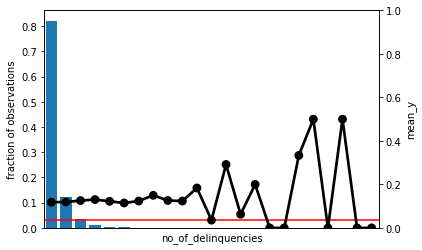

    labels  no_of_delinquencies    mean_y
0        0             0.820946  0.117948
1        1             0.120843  0.118982
2        2             0.035138  0.125556
3        3             0.012243  0.130380
4        4             0.004985  0.122311
5        5             0.002647  0.114583
6        6             0.001388  0.123620
7        7             0.000757  0.149798
8        8             0.000365  0.126050
9        9             0.000248  0.123457
10      10             0.000150  0.183673
11      11             0.000086  0.035714
12      12             0.000074  0.291667
13      13             0.000049  0.062500
14      15             0.000018  0.000000
15      14             0.000015  0.200000
16      16             0.000012  0.000000
17      17             0.000009  0.333333
18      19             0.000009  0.000000
19      18             0.000006  0.500000
20      21             0.000006  0.500000
21      22             0.000003  0.000000
22      29             0.000003  0

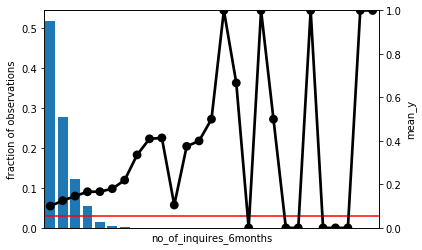

    labels  no_of_inquires_6months    mean_y
0        0                0.518954  0.100203
1        1                0.278444  0.125380
2        2                0.123551  0.146403
3        3                0.053968  0.166108
4        4                0.015674  0.166732
5        5                0.005934  0.180176
6        6                0.002482  0.219753
7        7                0.000447  0.335616
8        8                0.000254  0.409639
9        9                0.000089  0.413793
10      10                0.000058  0.105263
11      12                0.000031  0.400000
12      11                0.000025  0.375000
13      15                0.000018  0.666667
14      13                0.000012  0.500000
15      18                0.000012  0.500000
16      14                0.000009  1.000000
17      16                0.000009  0.000000
18      32                0.000003  1.000000
19      17                0.000003  1.000000
20      19                0.000003  0.000000
21      24

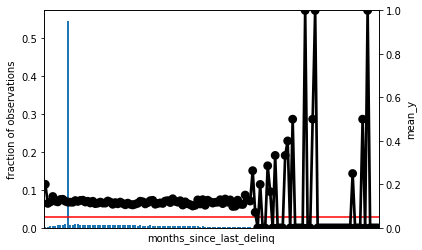

     labels  months_since_last_delinq    mean_y
0         9                  0.545973  0.118352
1         8                  0.009170  0.122619
2        13                  0.009108  0.121763
3        12                  0.009044  0.125678
4        10                  0.008928  0.118394
5        14                  0.008768  0.126136
6         7                  0.008686  0.131570
7        15                  0.008655  0.127434
8         6                  0.008542  0.130560
9        11                  0.008395  0.117883
10       16                  0.008343  0.118986
11       17                  0.008327  0.122517
12       18                  0.008315  0.114591
13       19                  0.008202  0.122525
14       20                  0.007969  0.111496
15       21                  0.007923  0.113689
16       22                  0.007491  0.118609
17       26                  0.007488  0.118658
18       23                  0.007411  0.114097
19       27                  0.007338  0

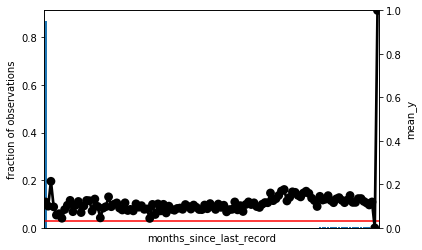

     labels  months_since_last_record    mean_y
0         0                  0.868658  0.119247
1       109                  0.002426  0.116162
2       108                  0.002148  0.126961
3       110                  0.002105  0.128093
4       104                  0.002065  0.126113
5       106                  0.002065  0.133531
6       105                  0.002007  0.116031
7       112                  0.001985  0.117284
8       107                  0.001936  0.139241
9       113                  0.001906  0.117363
10      114                  0.001887  0.134740
11      115                  0.001884  0.134959
12      103                  0.001838  0.148333
13      111                  0.001789  0.148973
14      102                  0.001765  0.131944
15      101                  0.001746  0.128070
16      118                  0.001743  0.105448
17      116                  0.001731  0.122124
18      100                  0.001710  0.145161
19      117                  0.001654  0

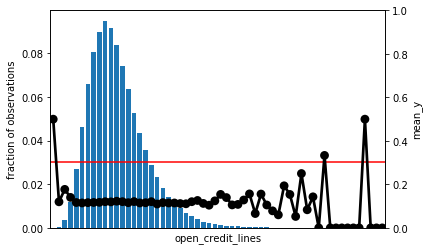

    labels  open_credit_lines    mean_y
0        9           0.094887  0.120403
1       10           0.091737  0.119694
2        8           0.089709  0.117551
3       11           0.083836  0.122679
4        7           0.080536  0.116978
5       12           0.074066  0.120579
6        6           0.066030  0.116091
7       13           0.063833  0.115911
8       14           0.052856  0.121029
9        5           0.046134  0.114756
10      15           0.043606  0.114804
11      16           0.035717  0.115715
12      17           0.028796  0.120545
13       4           0.027093  0.116702
14      18           0.023235  0.109836
15      19           0.018401  0.116217
16      20           0.014289  0.114708
17       3           0.011759  0.140177
18      21           0.011256  0.114589
19      22           0.008952  0.111910
20      23           0.006878  0.110913
21      24           0.005288  0.120510
22      25           0.004130  0.126113
23       2           0.003839  0.177175


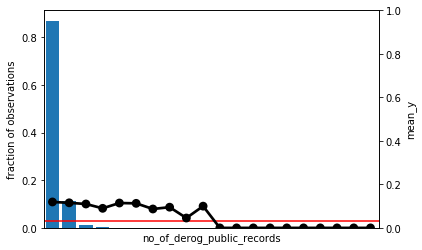

    labels  no_of_derog_public_records    mean_y
0        0                    0.868658  0.119247
1        1                    0.113588  0.115361
2        2                    0.012040  0.109924
3        3                    0.003438  0.090018
4        4                    0.001124  0.114441
5        5                    0.000570  0.112903
6        6                    0.000282  0.086957
7        7                    0.000129  0.095238
8        8                    0.000067  0.045455
9        9                    0.000031  0.100000
10      10                    0.000028  0.000000
11      11                    0.000018  0.000000
12      18                    0.000006  0.000000
13      54                    0.000003  0.000000
14      13                    0.000003  0.000000
15      14                    0.000003  0.000000
16      15                    0.000003  0.000000
17      16                    0.000003  0.000000
18      40                    0.000003  0.000000
19      63          

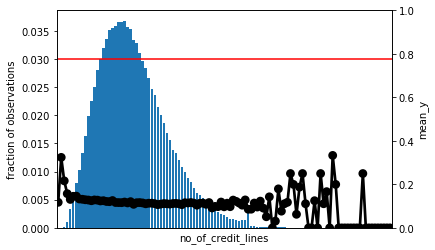

     labels  no_of_credit_lines    mean_y
0        22            0.036792  0.115996
1        20            0.036618  0.116801
2        21            0.036514  0.116462
3        19            0.035892  0.125736
4        23            0.035607  0.118826
5        18            0.035524  0.120569
6        24            0.035362  0.114885
7        17            0.035104  0.121487
8        16            0.033520  0.125034
9        25            0.033450  0.120718
10       26            0.032843  0.108396
11       15            0.031909  0.123956
12       27            0.031023  0.115742
13       14            0.030006  0.127629
14       28            0.029740  0.116411
15       29            0.028389  0.114720
16       13            0.028116  0.128582
17       30            0.026654  0.110920
18       12            0.025052  0.124985
19       31            0.024685  0.113566
20       32            0.023569  0.113610
21       11            0.022583  0.128069
22       33            0.021560  0

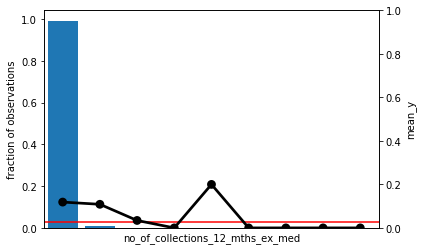

   labels  no_of_collections_12_mths_ex_med    mean_y
0       0                          0.991538  0.118679
1       1                          0.007960  0.108545
2       2                          0.000447  0.034247
3       3                          0.000028  0.000000
4       4                          0.000015  0.200000
5      20                          0.000003  0.000000
6      16                          0.000003  0.000000
7       6                          0.000003  0.000000
8       5                          0.000003  0.000000
no_of_collections_12_mths_ex_med ^------------



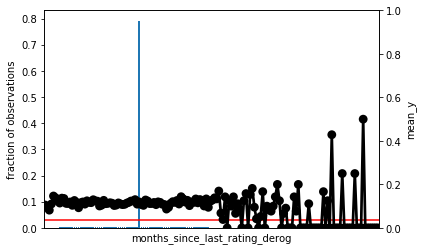

     labels  months_since_last_rating_derog    mean_y
0        45                        0.791292  0.119306
1        46                        0.003618  0.107536
2        42                        0.003566  0.123711
3        40                        0.003523  0.117391
4        48                        0.003508  0.128384
5        44                        0.003480  0.109155
6        41                        0.003450  0.123446
7        43                        0.003370  0.130000
8        49                        0.003300  0.123491
9        47                        0.003226  0.103514
10       38                        0.003195  0.108341
11       37                        0.003146  0.107108
12       26                        0.003134  0.100684
13       31                        0.003125  0.115686
14       36                        0.003113  0.110236
15       34                        0.003094  0.104950
16       39                        0.003091  0.113974
17       35                 

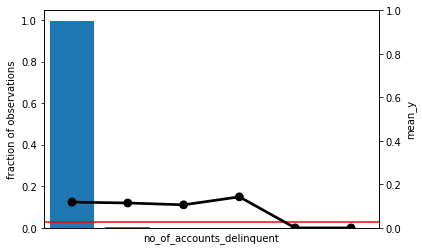

   labels  no_of_accounts_delinquent    mean_y
0       0                   0.996320  0.118574
1       1                   0.003450  0.114565
2       2                   0.000202  0.106061
3       3                   0.000021  0.142857
4       5                   0.000003  0.000000
5       4                   0.000003  0.000000
no_of_accounts_delinquent ^------------



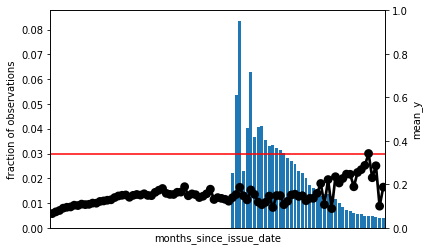

    labels  months_since_issue_date    mean_y
0       51                 0.083533  0.080066
1       54                 0.062779  0.096335
2       50                 0.053572  0.073716
3       57                 0.041183  0.109284
4       56                 0.040803  0.102718
5       53                 0.040469  0.094860
6       55                 0.036811  0.104370
7       58                 0.035481  0.107072
8       60                 0.033254  0.114059
9       59                 0.033052  0.108361
10      61                 0.032194  0.113533
11      62                 0.031581  0.121750
12      63                 0.030218  0.123999
13      64                 0.027993  0.127175
14      65                 0.027120  0.129349
15      66                 0.025726  0.139574
16      67                 0.023122  0.146813
17      52                 0.022999  0.090715
18      68                 0.022209  0.149952
19      49                 0.022019  0.065674
20      69                 0.01999

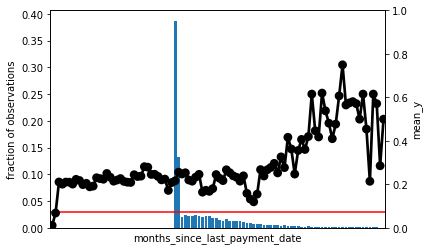

    labels  months_since_last_payment_date    mean_y
0       36                        0.387229  0.011512
1       37                        0.132571  0.068267
2       42                        0.025025  0.201396
3       39                        0.024029  0.201071
4       40                        0.021860  0.210652
5       43                        0.021624  0.223293
6       45                        0.021526  0.198975
7       46                        0.021376  0.204959
8       41                        0.021370  0.210179
9       44                        0.020604  0.217844
10      38                        0.019878  0.211159
11      48                        0.018484  0.192276
12      47                        0.018147  0.188925
13      51                        0.016403  0.223758
14      49                        0.015582  0.230633
15      53                        0.013634  0.233034
16      54                        0.013428  0.214921
17      52                        0.013425  0.

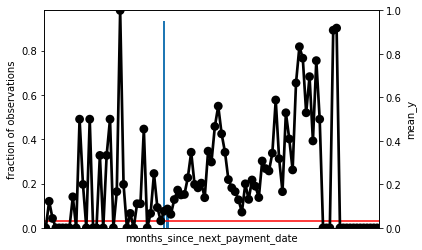

    labels  months_since_next_payment_date    mean_y
0       35                        0.934338  0.122354
1       36                        0.059648  0.043608
2       94                        0.000227  0.202703
3       93                        0.000211  0.072464
4       92                        0.000190  0.129032
5       95                        0.000187  0.131148
6       96                        0.000181  0.220339
7       91                        0.000147  0.166667
8       97                        0.000144  0.191489
9       88                        0.000141  0.347826
10      98                        0.000132  0.139535
11     101                        0.000129  0.261905
12     110                        0.000129  0.833333
13     111                        0.000126  0.780488
14     109                        0.000119  0.666667
15      99                        0.000119  0.307692
16      90                        0.000116  0.184211
17      80                        0.000116  0.

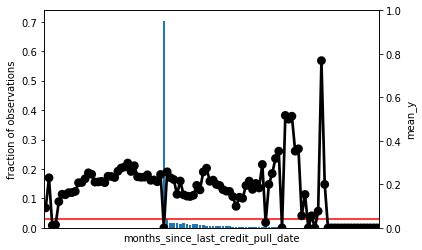

     labels  months_since_last_credit_pull_date    mean_y
0        36                            0.703253  0.092106
1        37                            0.030110  0.230362
2        38                            0.017843  0.010989
3        40                            0.017188  0.120856
4        39                            0.016838  0.014192
5        42                            0.015806  0.152549
6        41                            0.013925  0.154675
7        43                            0.013373  0.161970
8        45                            0.012157  0.167843
9        46                            0.011716  0.207636
10       44                            0.011498  0.162537
11       48                            0.011045  0.226075
12       47                            0.010309  0.208915
13       49                            0.008009  0.253252
14       51                            0.007328  0.210702
15       50                            0.006835  0.246526
16       52   

In [390]:
plot_labels_frac_meanY(
    X=X_train, 
    y=y_train, 
    cardinality_df=cardinality_df, 
    colnames=discrete_num_colnames, 
    ignore_colnames=high_cardinal_colnames, 
    rare_lbl_threshold=0.03,
    plot_x_labels=False
)

In [391]:
# Use this with high cardinal features
# Not plotting the label-fractions and mean_y due to high cardinality
def get_label_fraction(df, colnames):
    n_rows = len(X_train)
    for colname in colnames:
        label_frac = pd.Series(X_train[colname].value_counts() / n_rows)
        print()
        print(colname, '<----')
        print(label_frac)

In [392]:
get_label_fraction(
    df=X_train,
    colnames=high_cardinal_colnames
)


months_since_earliest_credit_line_date <----
219    0.007806
221    0.007656
209    0.007479
231    0.007282
207    0.007108
230    0.007071
220    0.007065
218    0.006988
232    0.006838
233    0.006657
217    0.006443
208    0.006403
195    0.006400
229    0.006305
196    0.006284
242    0.006278
243    0.006112
197    0.006109
206    0.006100
241    0.006048
212    0.006045
210    0.005996
226    0.005959
216    0.005959
244    0.005953
222    0.005931
205    0.005904
214    0.005876
211    0.005836
224    0.005800
         ...   
824    0.000003
726    0.000003
680    0.000003
681    0.000003
900    0.000003
682    0.000003
819    0.000003
770    0.000003
695    0.000003
876    0.000003
771    0.000003
673    0.000003
704    0.000003
788    0.000003
725    0.000003
728    0.000003
691    0.000003
721    0.000003
735    0.000003
792    0.000003
743    0.000003
720    0.000003
665    0.000003
715    0.000003
835    0.000003
780    0.000003
852    0.000003
748    0.000003
707    0.0

In [393]:
tree_disc = dsc.DecisionTreeDiscretiser(
    cv=3,
    scoring='roc_auc',
    variables=discrete_num_colnames,
    regression=False,
    param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7]}
)

In [394]:
tree_disc.fit(X_train, y_train)

DecisionTreeDiscretiser(cv=3, param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7]},
            random_state=None, regression=False, scoring='roc_auc',
            variables=['no_of_delinquencies', 'no_of_inquires_6months', 'months_since_last_delinq', 'months_since_last_record', 'open_credit_lines', 'no_of_derog_public_records', 'no_of_credit_lines', 'no_of_collections_12_mths_ex_med', 'months_since_last_rating_derog', 'no_of_accounts_delinquent', 'months_since_issue_date', 'months_since_earliest_credit_line_date', 'months_since_last_payment_date', 'months_since_next_payment_date', 'months_since_last_credit_pull_date'])

In [395]:
tree_disc.scores_dict_

{'no_of_delinquencies': 0.5026397144724846,
 'no_of_inquires_6months': 0.5551373072198832,
 'months_since_last_delinq': 0.5079450279689621,
 'months_since_last_record': 0.5119731018563846,
 'open_credit_lines': 0.5087620044440011,
 'no_of_derog_public_records': 0.5029690629154999,
 'no_of_credit_lines': 0.5205420484040927,
 'no_of_collections_12_mths_ex_med': 0.5005916814536089,
 'months_since_last_rating_derog': 0.5074493489753615,
 'no_of_accounts_delinquent': 0.5000839891171767,
 'months_since_issue_date': 0.5799036356477733,
 'months_since_earliest_credit_line_date': 0.5351124378639737,
 'months_since_last_payment_date': 0.7579676290093595,
 'months_since_next_payment_date': 0.5259732419673497,
 'months_since_last_credit_pull_date': 0.624309719821261}

In [396]:
X_train = tree_disc.transform(X_train)
X_test = tree_disc.transform(X_test)

In [397]:
def plot_discretized_features(X, colnames):
    nrows = X.shape[0]
    for colname in colnames:
        bins_fraction = X.groupby([colname])[colname].count() / nrows
        fig = plt.figure()
        bins_fraction.plot.bar()
        plt.show()
        print(colname, '^----------')
        print()

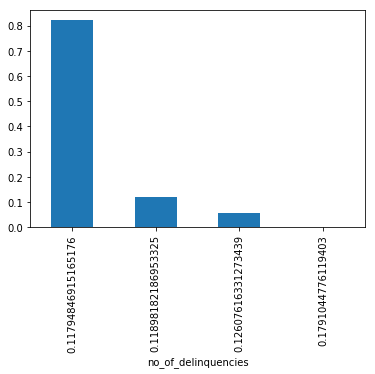

no_of_delinquencies ^----------



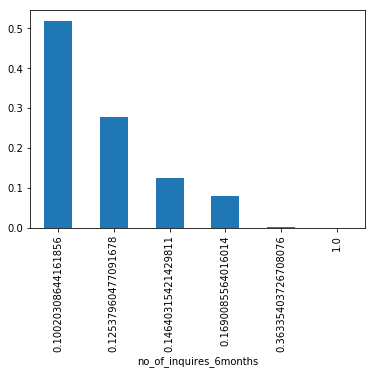

no_of_inquires_6months ^----------



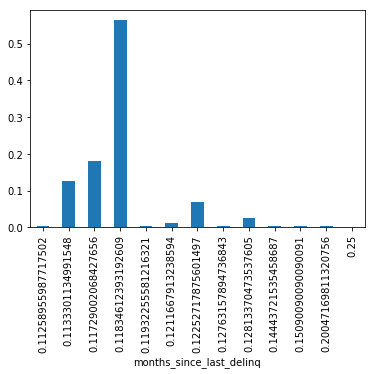

months_since_last_delinq ^----------



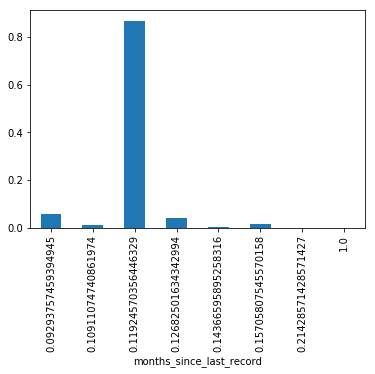

months_since_last_record ^----------



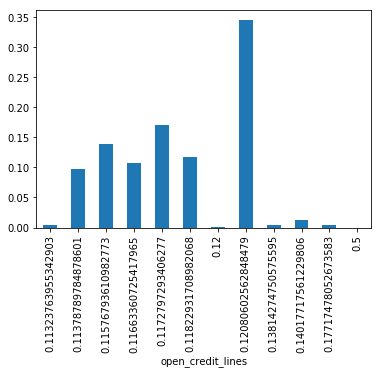

open_credit_lines ^----------



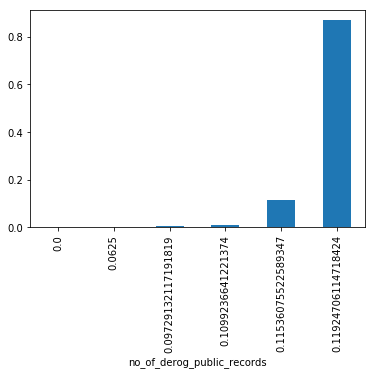

no_of_derog_public_records ^----------



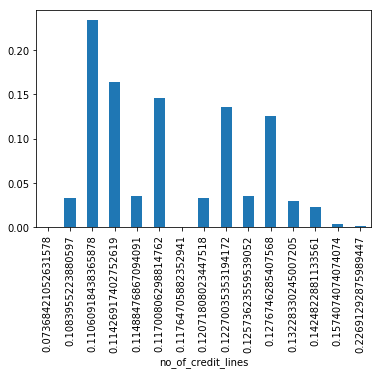

no_of_credit_lines ^----------



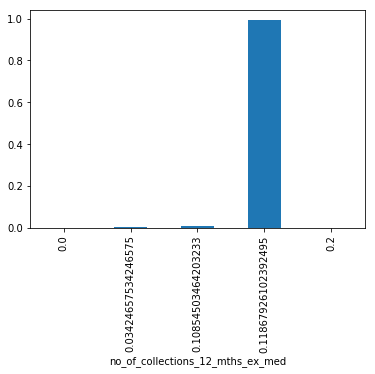

no_of_collections_12_mths_ex_med ^----------



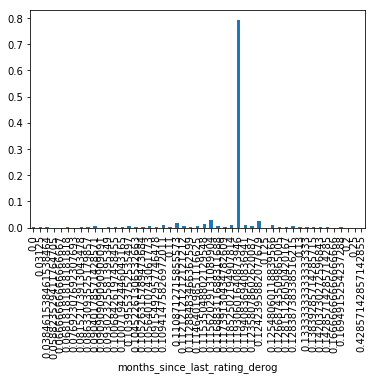

months_since_last_rating_derog ^----------



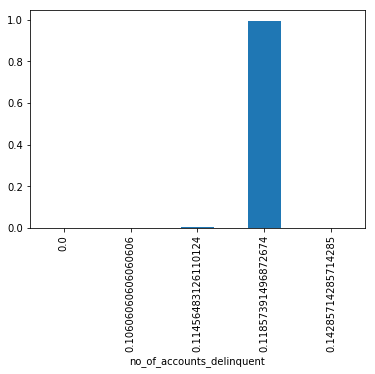

no_of_accounts_delinquent ^----------



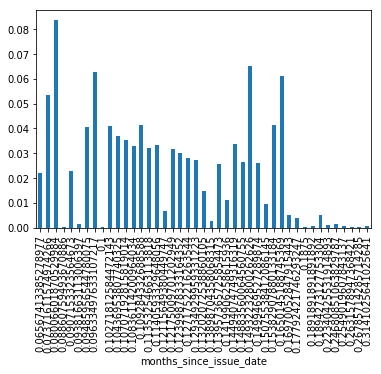

months_since_issue_date ^----------



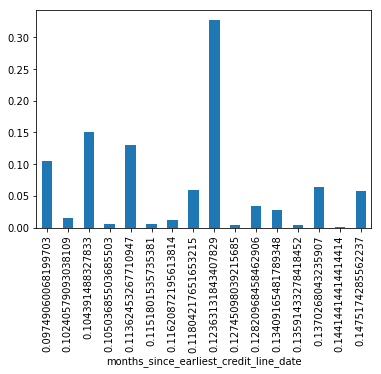

months_since_earliest_credit_line_date ^----------



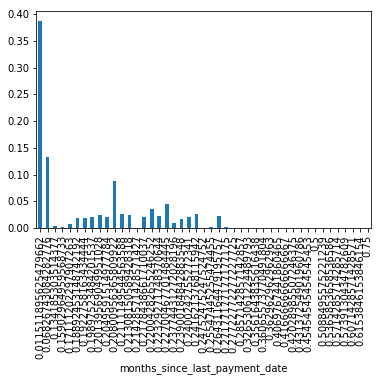

months_since_last_payment_date ^----------



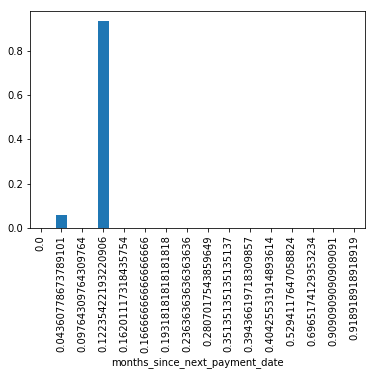

months_since_next_payment_date ^----------



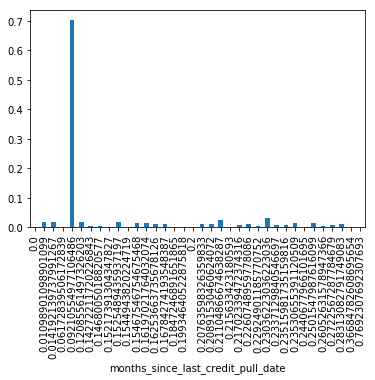

months_since_last_credit_pull_date ^----------



In [398]:
plot_discretized_features(X_train, discrete_num_colnames)

In [399]:
X_train[discrete_num_colnames].dtypes

no_of_delinquencies                       float64
no_of_inquires_6months                    float64
months_since_last_delinq                  float64
months_since_last_record                  float64
open_credit_lines                         float64
no_of_derog_public_records                float64
no_of_credit_lines                        float64
no_of_collections_12_mths_ex_med          float64
months_since_last_rating_derog            float64
no_of_accounts_delinquent                 float64
months_since_issue_date                   float64
months_since_earliest_credit_line_date    float64
months_since_last_payment_date            float64
months_since_next_payment_date            float64
months_since_last_credit_pull_date        float64
dtype: object

In [400]:
with open('./3_2.pkl', 'wb') as f:
    pickle.dump([X_train, X_test, y_train, y_test], f)
    f.close()

In [401]:
with open('./3_2.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)
    f.close()

In [402]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((326399, 56), (139886, 56), (326399,), (139886,))

## Continuous numerical features

### Tranformation to make Gaussian distributed features

1. Visulatise each continuous feature using histogram, Q-Q plot, box-plot. Create a scatter plot with target variable if target is continuous numeric.
2. Apply Yeo-Johnson transform to all the continuous numeric features without changing the original X_train. Some of these features have zero as values and hence not applying box-cox transformation
3. Plot the transformed features along with untransformed features for visual comparison. Some features get close to Gaussin distribution but some features are nowhere near Gaussian even after transformation.
4. Identify the features that get close to Gaussin distribution and apply Yeo-Johnson transformation only on these features.

In [403]:
def plot_compare_transformed_features(
    X_before_tf: pd.DataFrame, 
    X_after_tf: pd.DataFrame, 
    num_colnames: list, 
    y: pd.Series = None, 
    regression: bool = False
) -> None:
    
    for colname in num_colnames:
        feature = X_before_tf[colname]
        feature_tf = X_after_tf[colname]
        if regression:
            fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
        else:
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
        axes[0].hist(feature, bins=30)
        axes[1].boxplot(feature)
        stats.probplot(feature, dist="norm", plot=axes[2])
        if regression:
            target = y
            axes[3].scatter(feature, target)
            
        if regression:
            fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
        else:
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
        axes[0].hist(feature_tf, bins=30)
        axes[1].boxplot(feature_tf)
        stats.probplot(feature_tf, dist="norm", plot=axes[2])
        if regression:
            target = y
            axes[3].scatter(feature_tf, target)
        
        plt.show()
        print(colname, '^-------')
        print()

In [404]:
def plot_numeric_features(
    X: pd.DataFrame, 
    num_colnames: list, 
    y: pd.Series = None, 
    regression: bool = True
) -> None:
    for colname in num_colnames:
        feature = X[colname]
        if regression:
            fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
        else:
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
        axes[0].hist(feature, bins=30)
        axes[1].boxplot(feature)
        stats.probplot(feature, dist="norm", plot=axes[2])
        if regression:
            target = y
            axes[3].scatter(feature, target)
        plt.show()
        print(colname, '^-------')
        print()
    

In [405]:
cnt_num_colnames = X_train.dtypes[X_train.dtypes == 'float'].index.tolist()

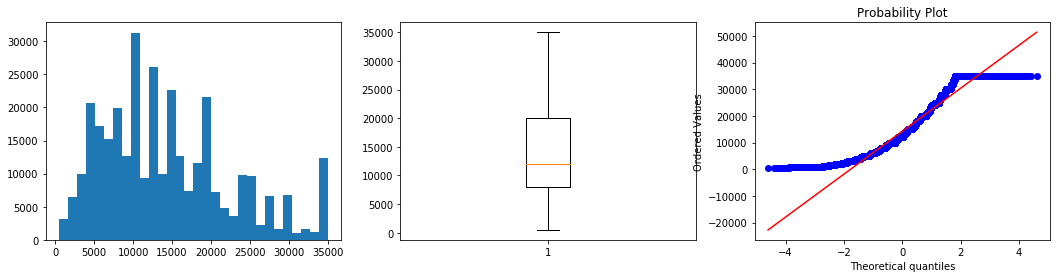

loan_applied_amount ^-------



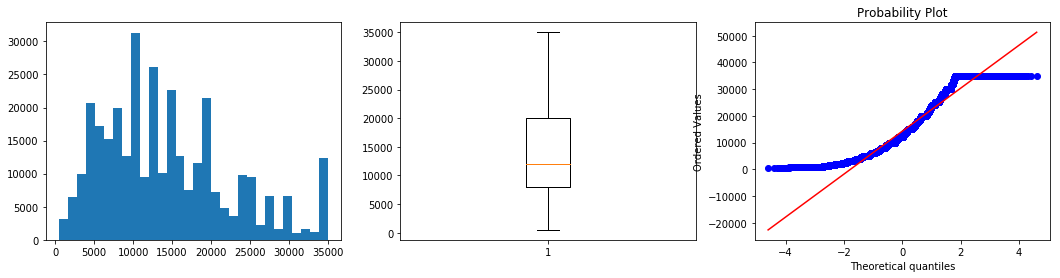

loan_funded_amount ^-------



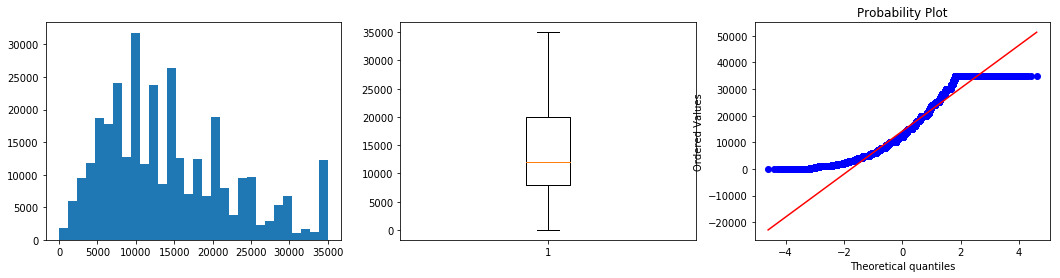

investor_commit_amount ^-------



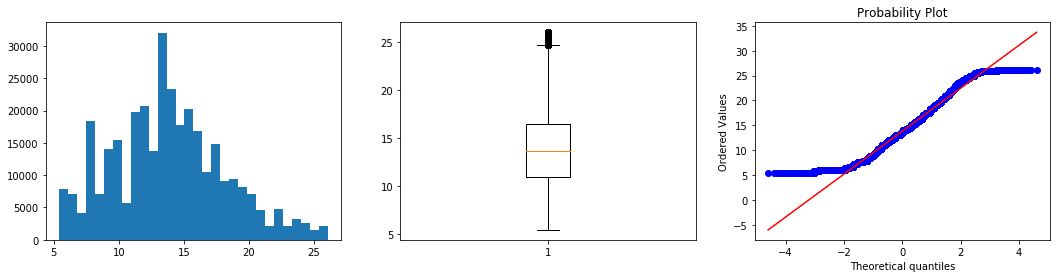

interest_rate ^-------



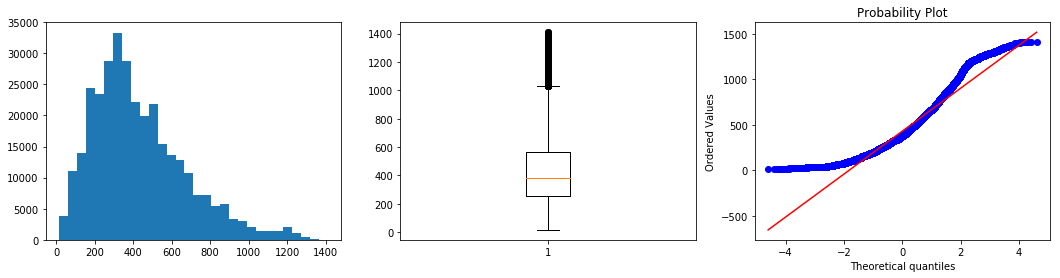

installment_amount ^-------



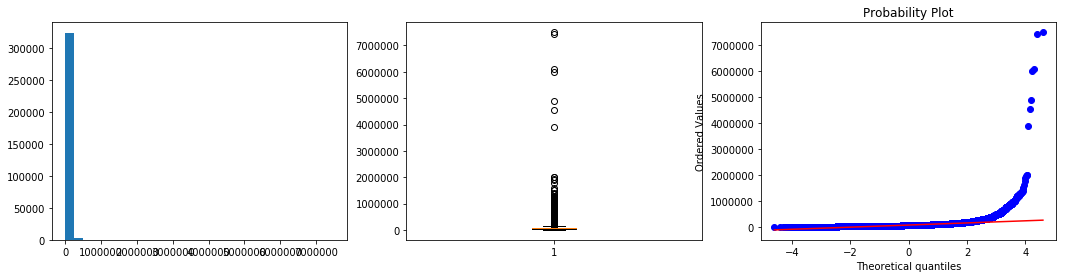

annual_income ^-------



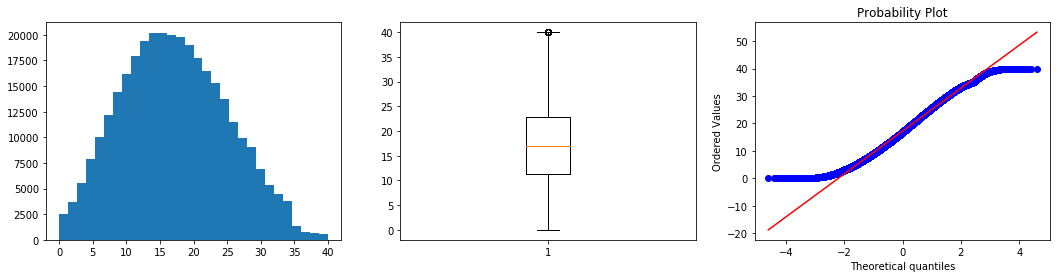

debt_to_income ^-------



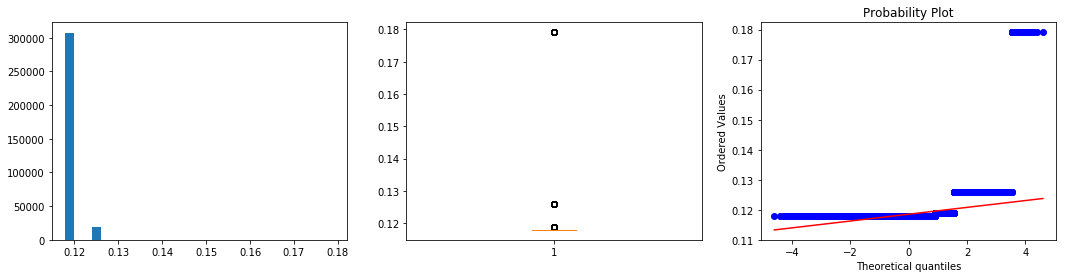

no_of_delinquencies ^-------



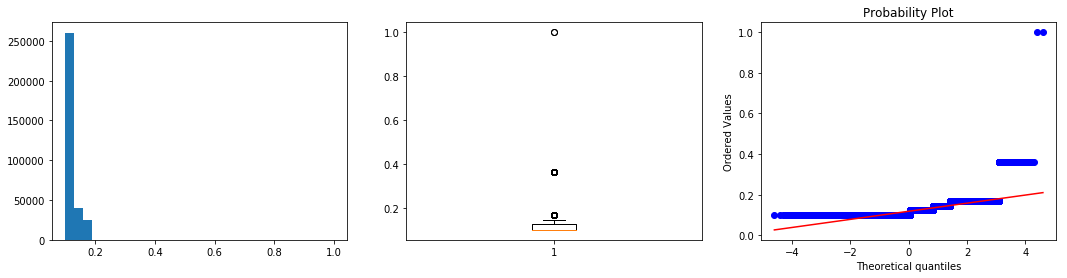

no_of_inquires_6months ^-------



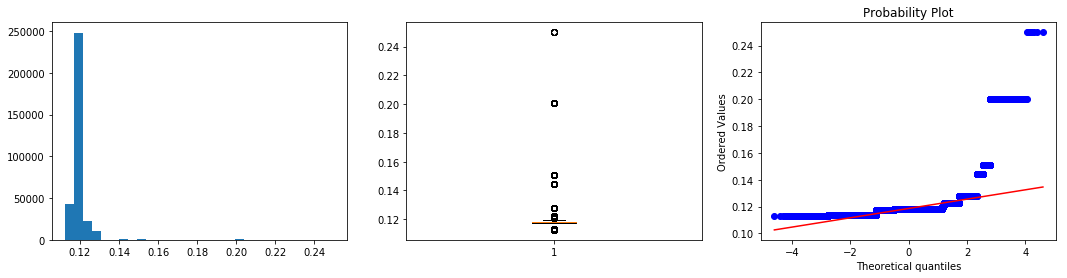

months_since_last_delinq ^-------



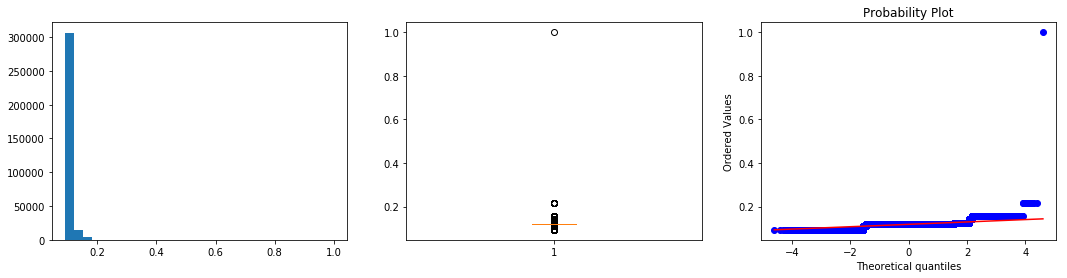

months_since_last_record ^-------



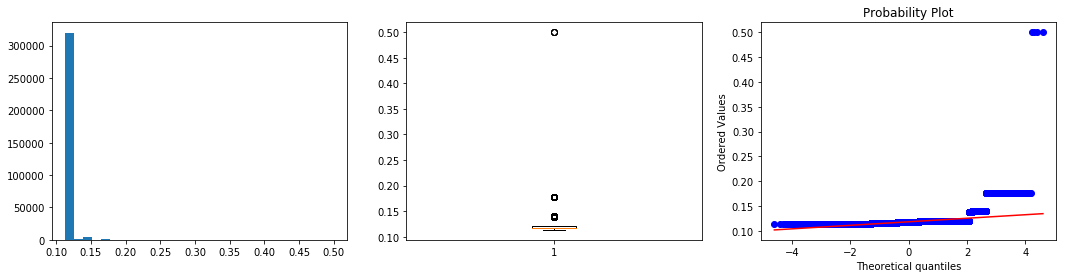

open_credit_lines ^-------



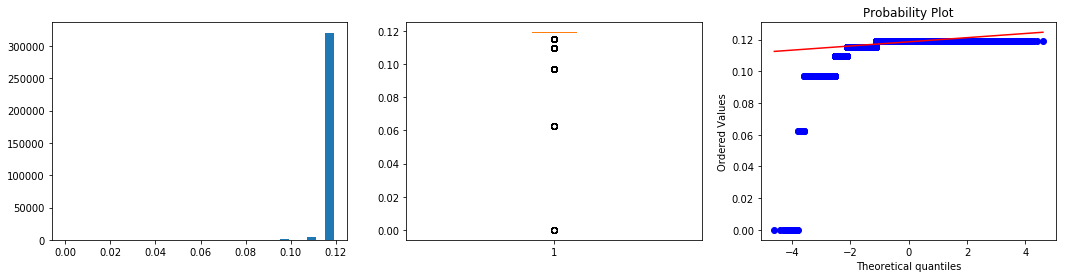

no_of_derog_public_records ^-------



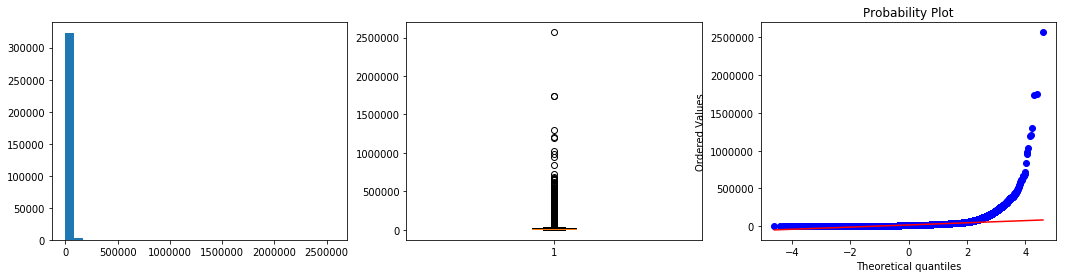

revolving_balance ^-------



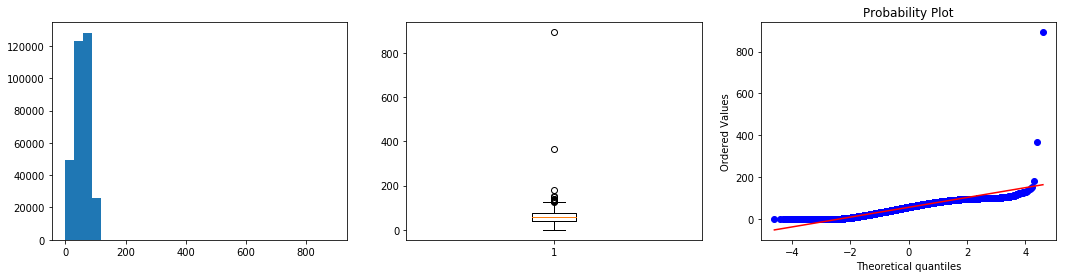

revolving_utilization_rate ^-------



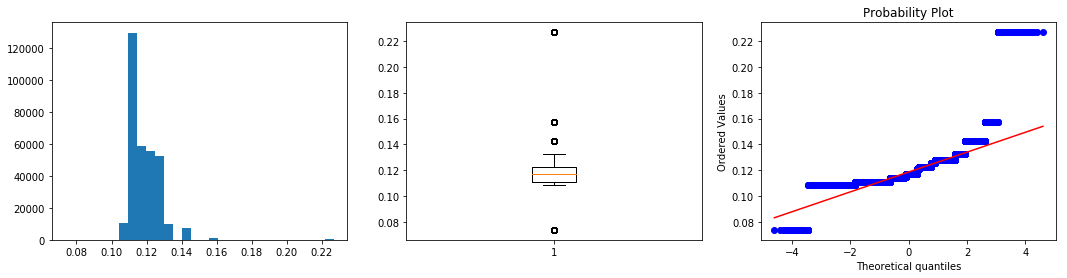

no_of_credit_lines ^-------



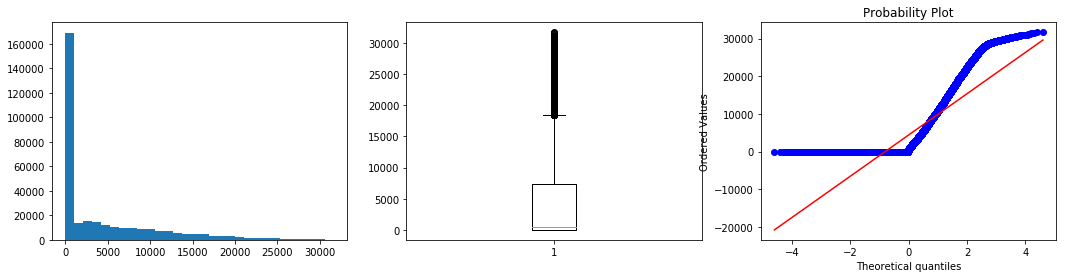

outstanding_amount ^-------



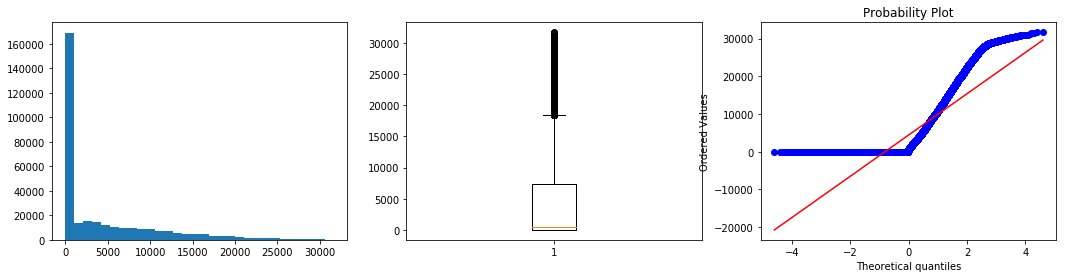

outstanding_amount_inv ^-------



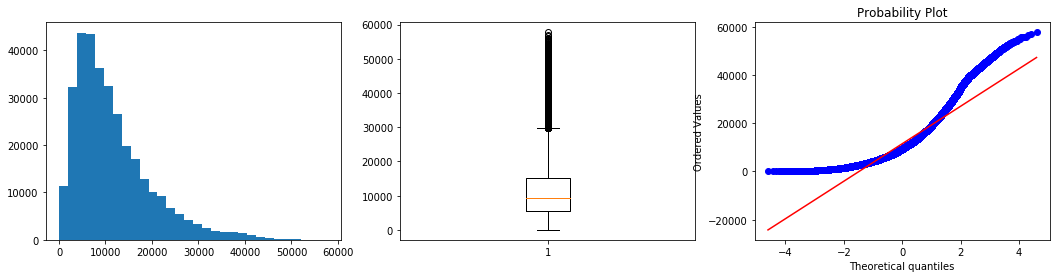

returned_amount ^-------



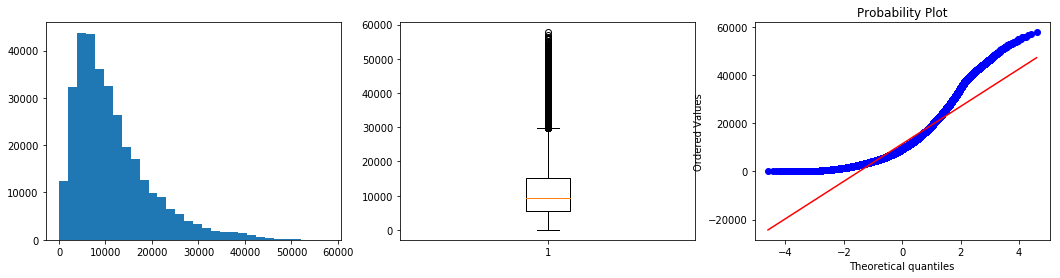

returned_amount_inv ^-------



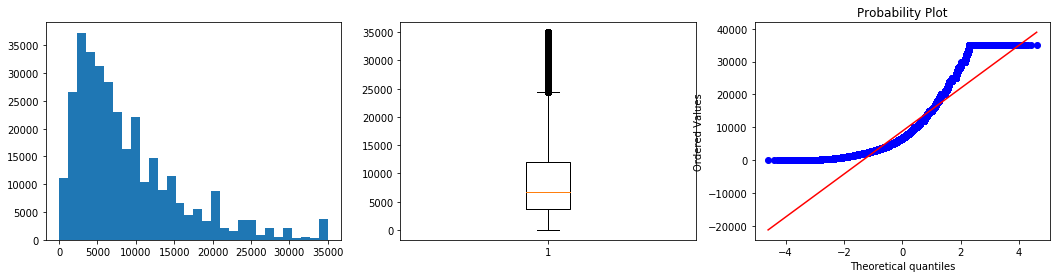

returned_principal_amount ^-------



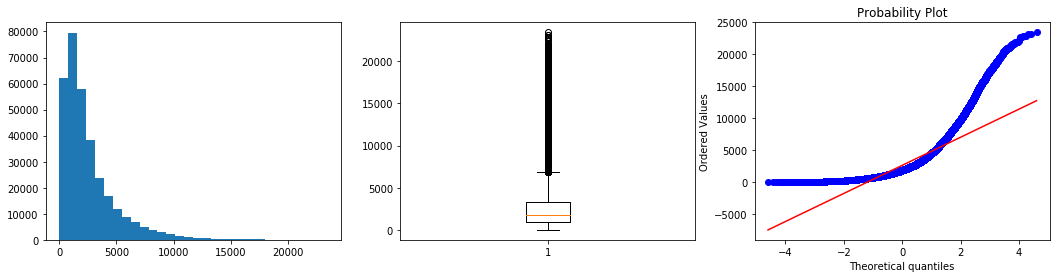

returned_interest_amount ^-------



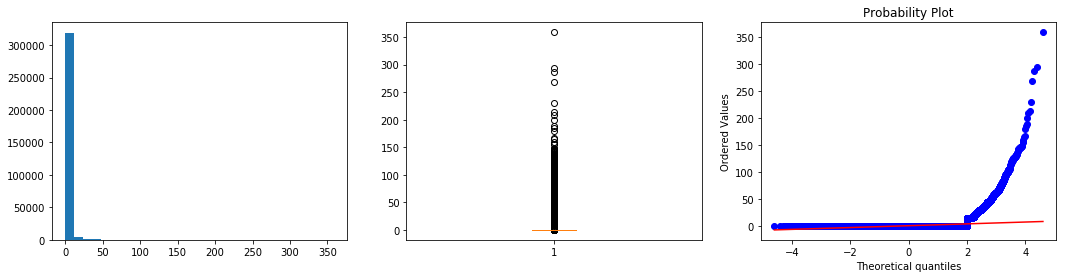

paid_late_fee_amount ^-------



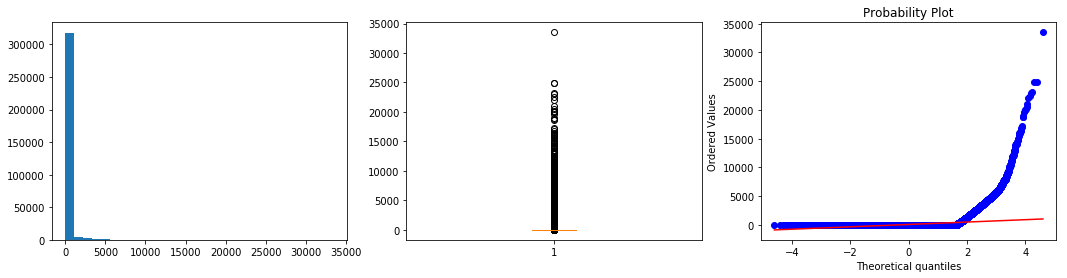

recoveries_amount ^-------



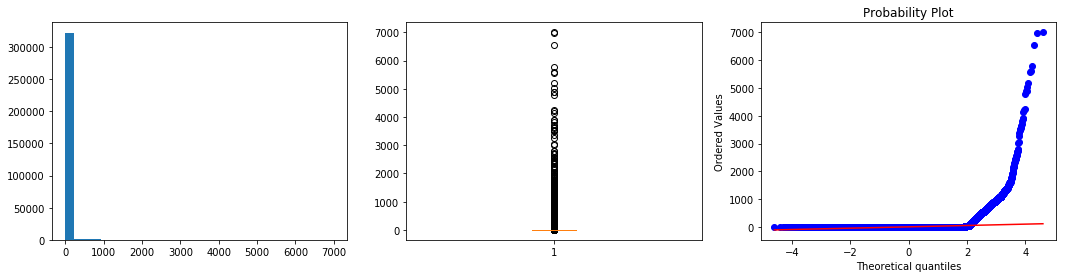

collection_fee ^-------



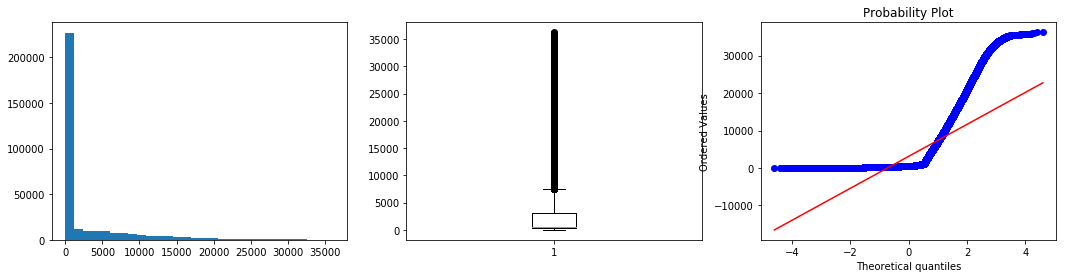

last_payment_amount ^-------



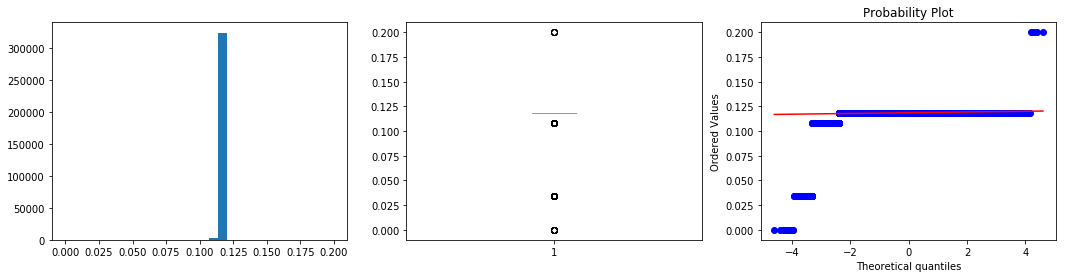

no_of_collections_12_mths_ex_med ^-------



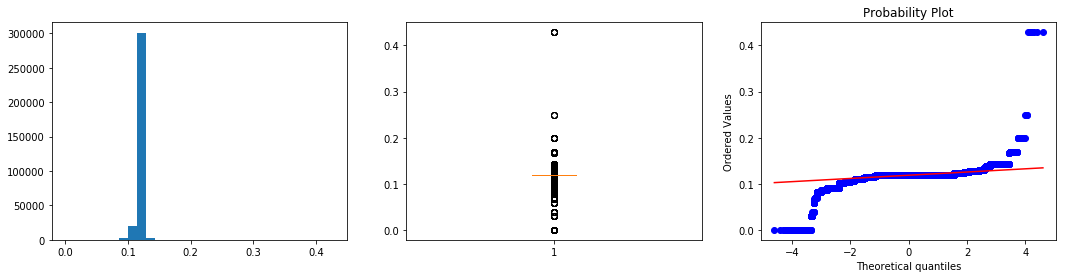

months_since_last_rating_derog ^-------



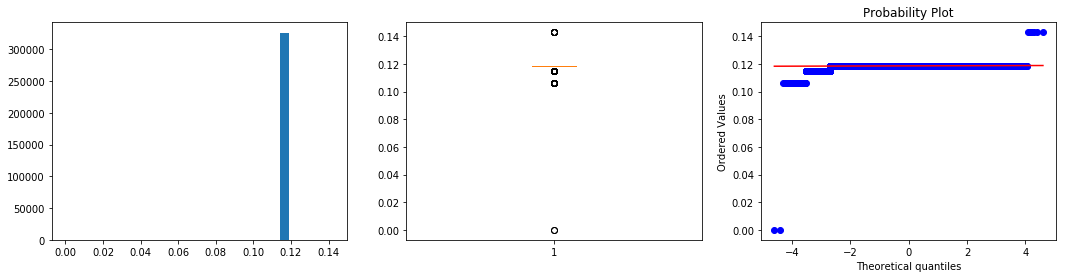

no_of_accounts_delinquent ^-------



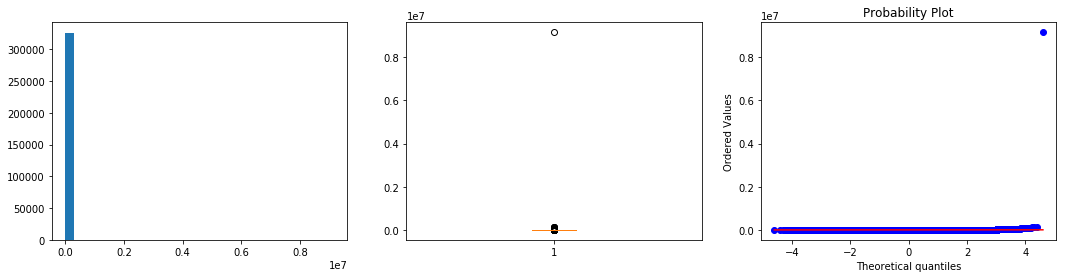

total_collection_amount ^-------



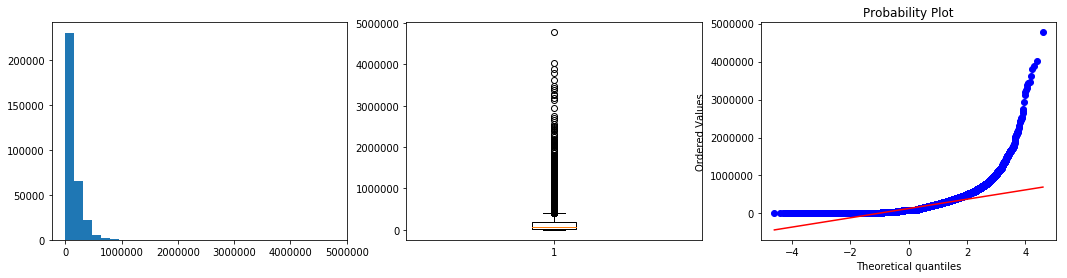

total_current_balance ^-------



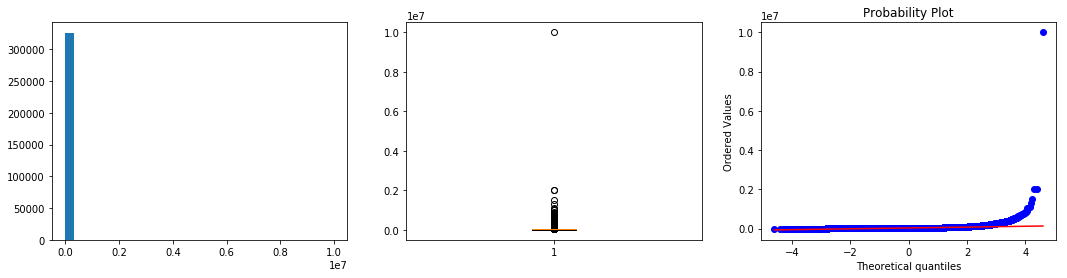

total_rev_hi_lim ^-------



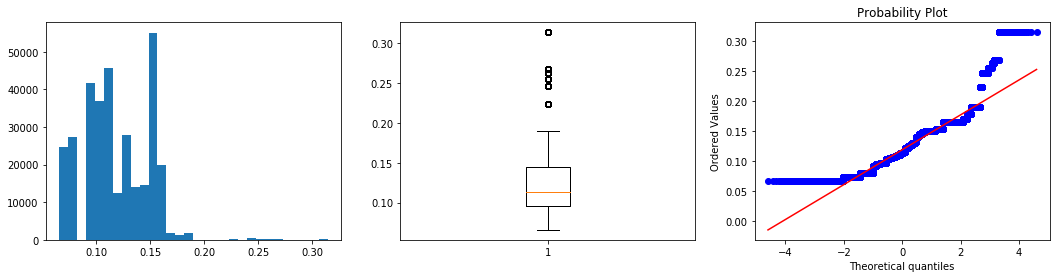

months_since_issue_date ^-------



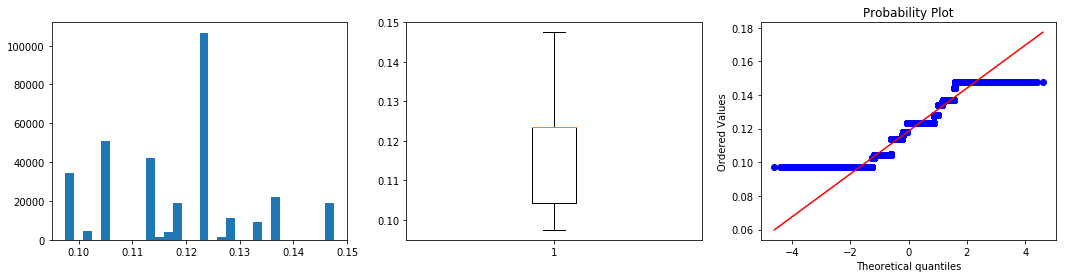

months_since_earliest_credit_line_date ^-------



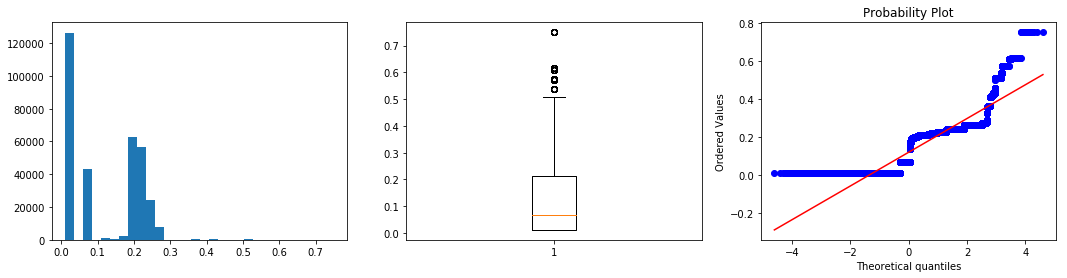

months_since_last_payment_date ^-------



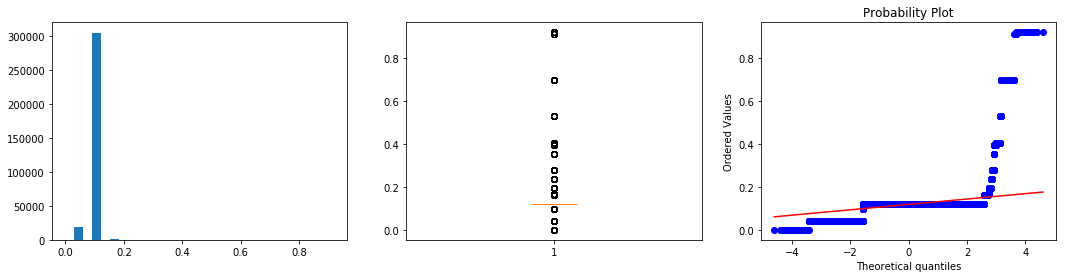

months_since_next_payment_date ^-------



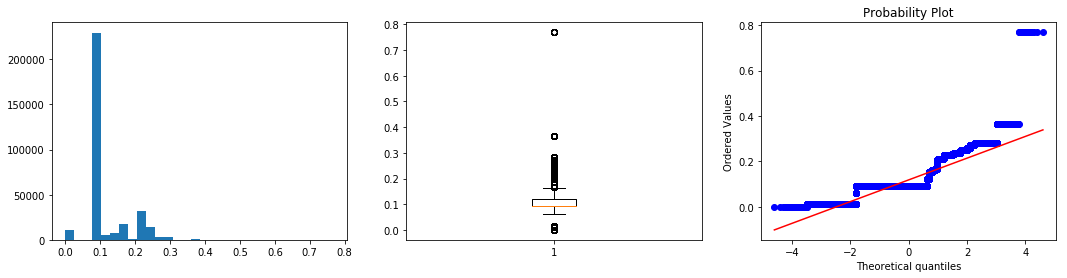

months_since_last_credit_pull_date ^-------



In [406]:
plot_numeric_features(X_train, cnt_num_colnames, regression=False)

In [407]:
(X_train[cnt_num_colnames] <= 0.0).sum()

loan_applied_amount                            0
loan_funded_amount                             0
investor_commit_amount                       178
interest_rate                                  0
installment_amount                             0
annual_income                                  0
debt_to_income                               250
no_of_delinquencies                            0
no_of_inquires_6months                         0
months_since_last_delinq                       0
months_since_last_record                       0
open_credit_lines                              0
no_of_derog_public_records                    24
revolving_balance                           1593
revolving_utilization_rate                  1587
no_of_credit_lines                             0
outstanding_amount                        160760
outstanding_amount_inv                    160760
returned_amount                               54
returned_amount_inv                          266
returned_principal_a

Since sone of the numeric features have zeroes, cannot use box-cox transformation.

In [408]:
yeo_jhn_tf = vt.YeoJohnsonTransformer(variables=cnt_num_colnames)

In [409]:
yeo_jhn_tf.fit(X_train)

/home/srini/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1458: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
/home/srini/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/home/srini/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1936: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/home/srini/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/srini/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)


YeoJohnsonTransformer(variables=['loan_applied_amount', 'loan_funded_amount', 'investor_commit_amount', 'interest_rate', 'installment_amount', 'annual_income', 'debt_to_income', 'no_of_delinquencies', 'no_of_inquires_6months', 'months_since_last_delinq', 'months_since_last_record', 'open_credit_lines', 'no_of_derog_publi...hs_since_last_payment_date', 'months_since_next_payment_date', 'months_since_last_credit_pull_date'])

In [410]:
X_train_yj = yeo_jhn_tf.transform(X_train)

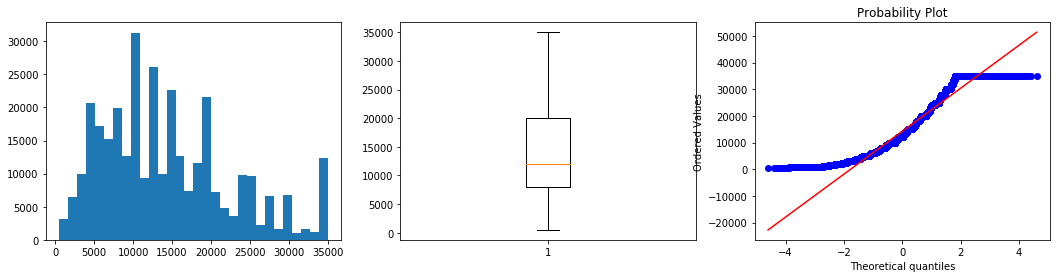

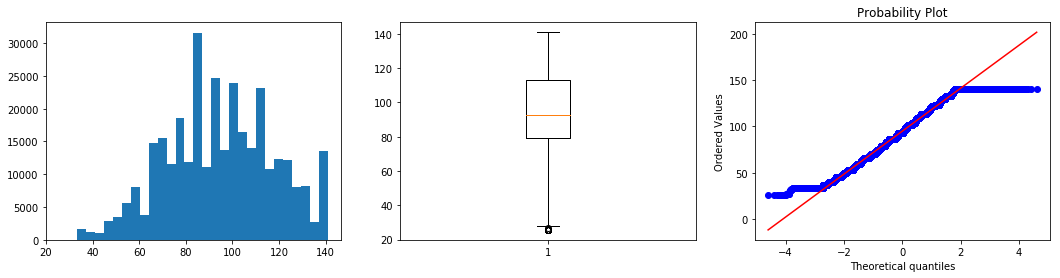

loan_applied_amount ^-------



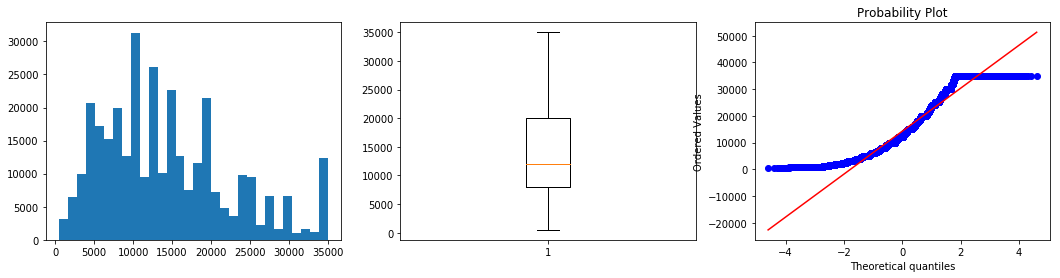

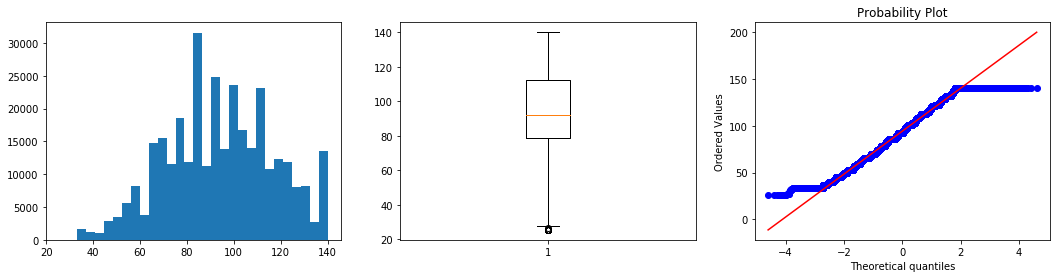

loan_funded_amount ^-------



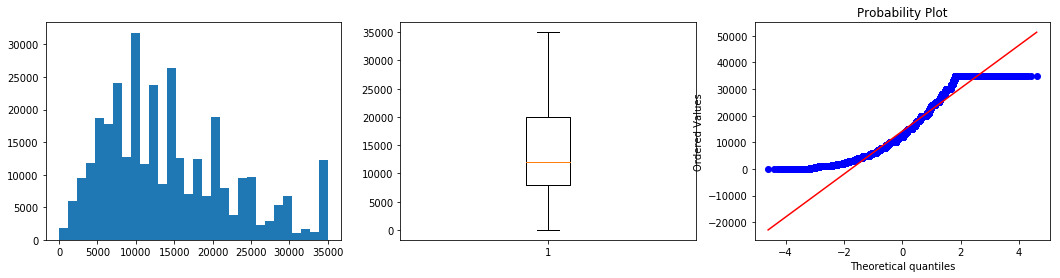

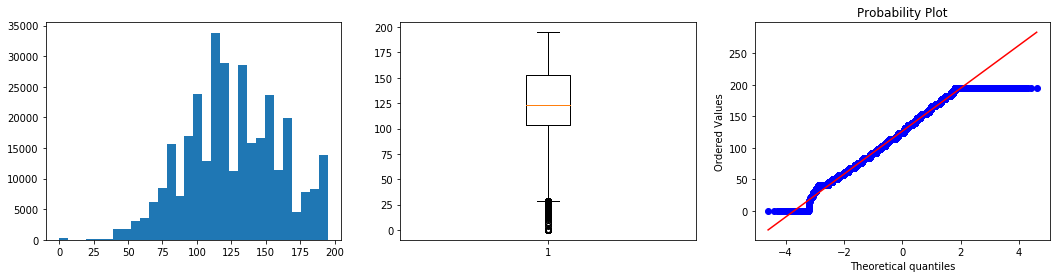

investor_commit_amount ^-------



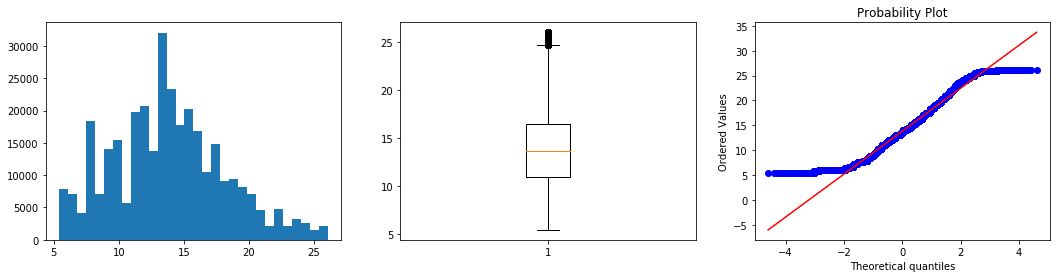

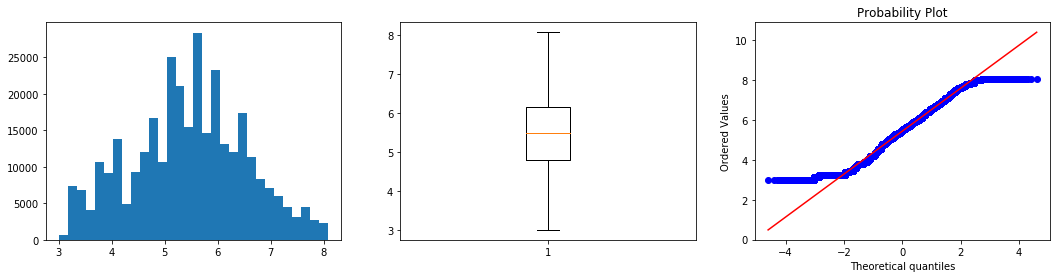

interest_rate ^-------



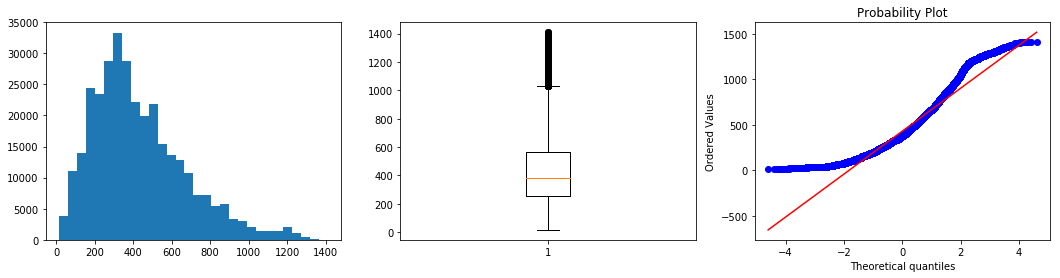

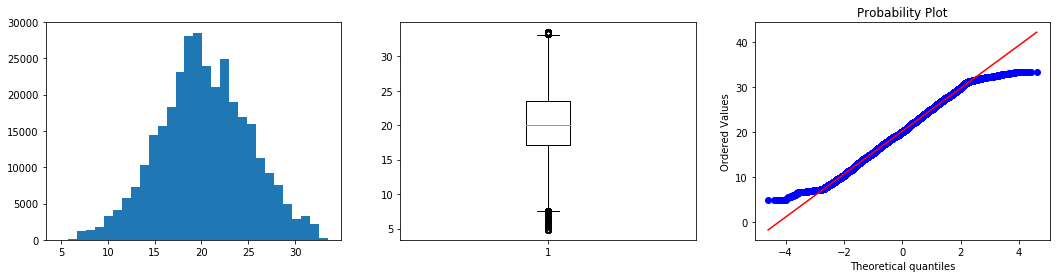

installment_amount ^-------



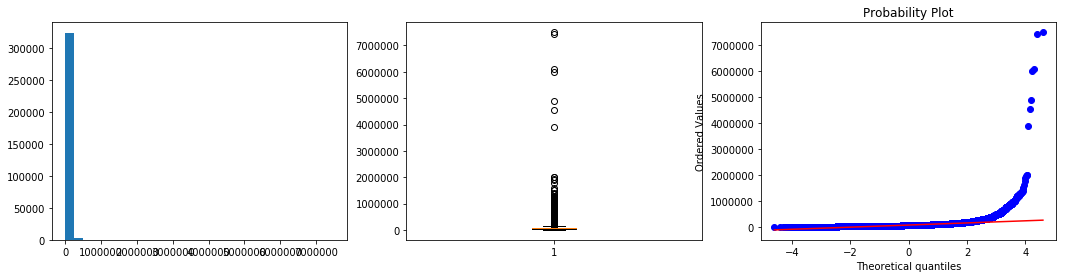

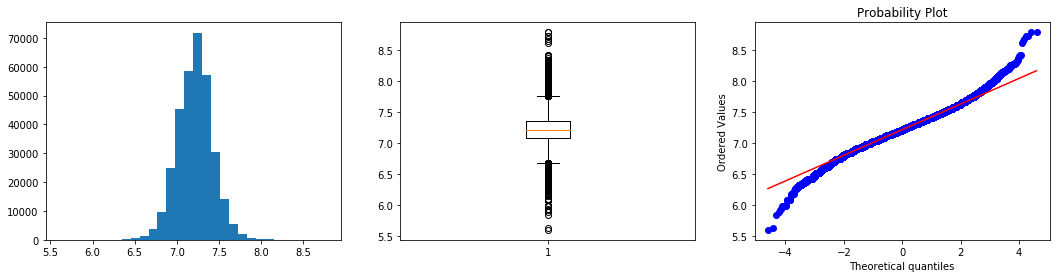

annual_income ^-------



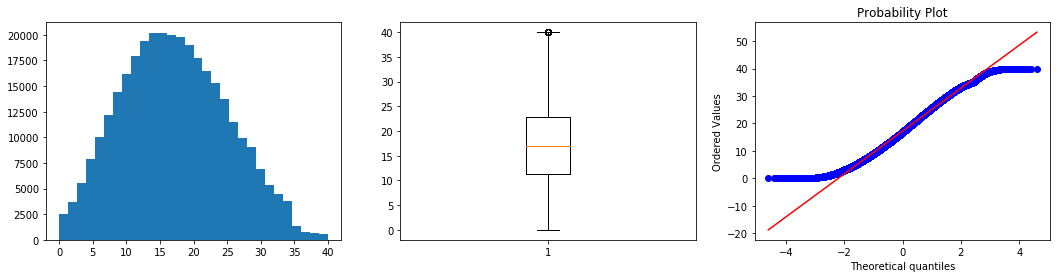

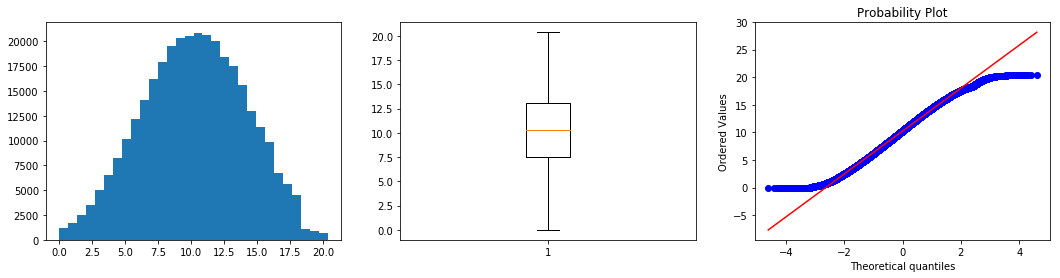

debt_to_income ^-------



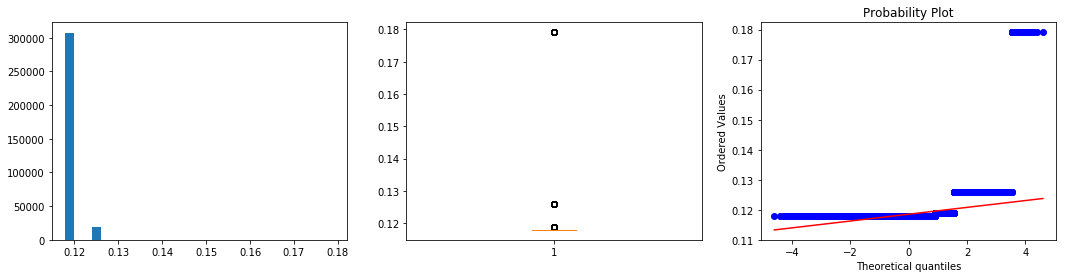

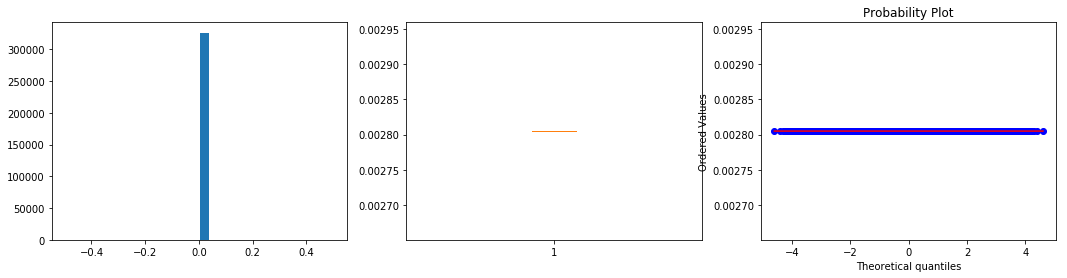

no_of_delinquencies ^-------



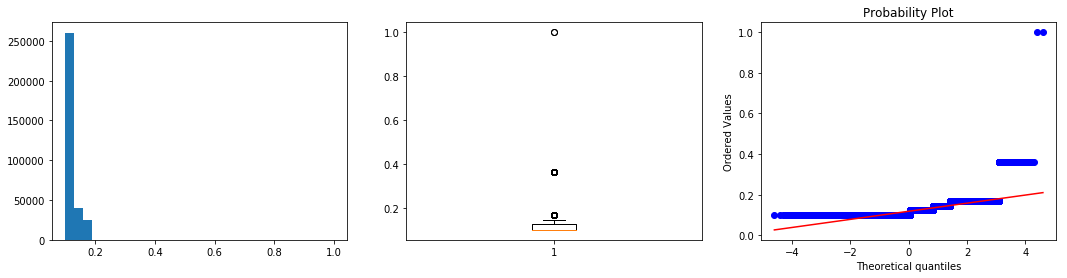

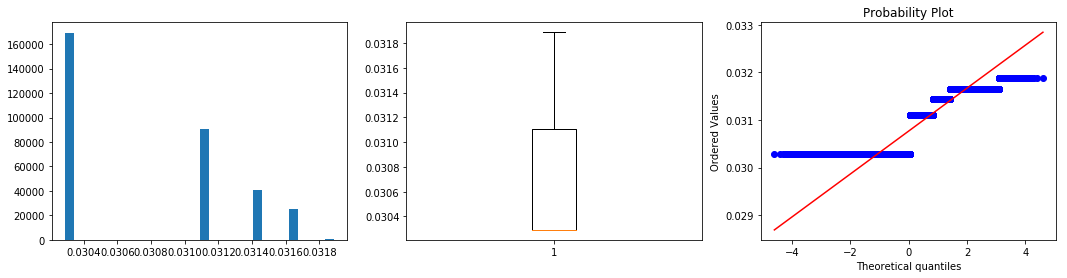

no_of_inquires_6months ^-------



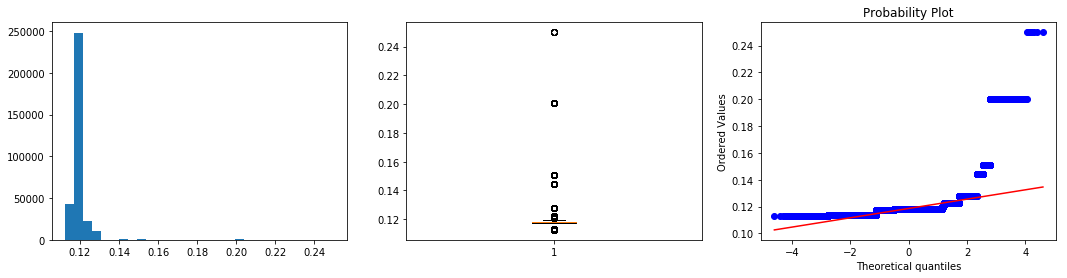

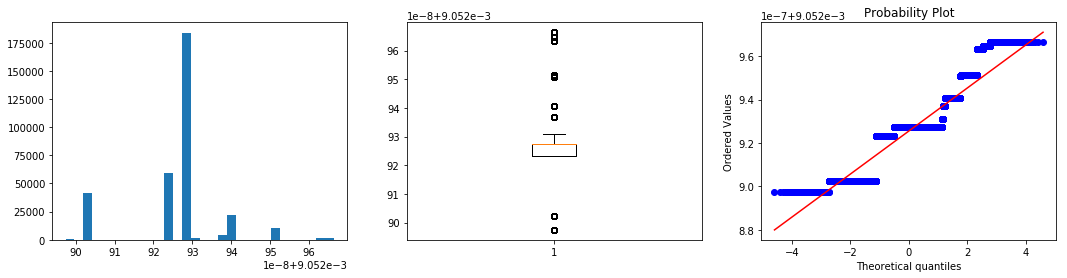

months_since_last_delinq ^-------



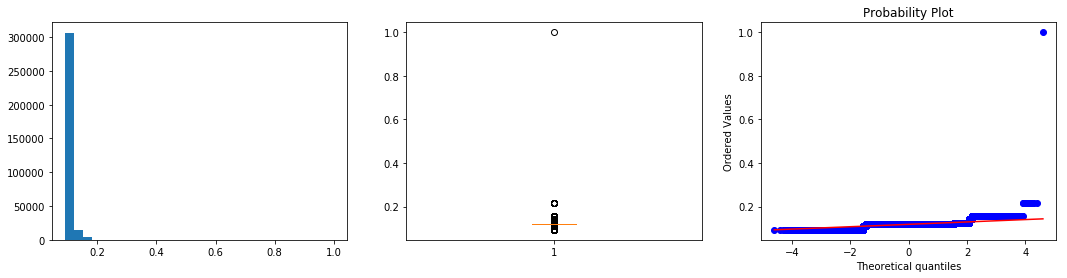

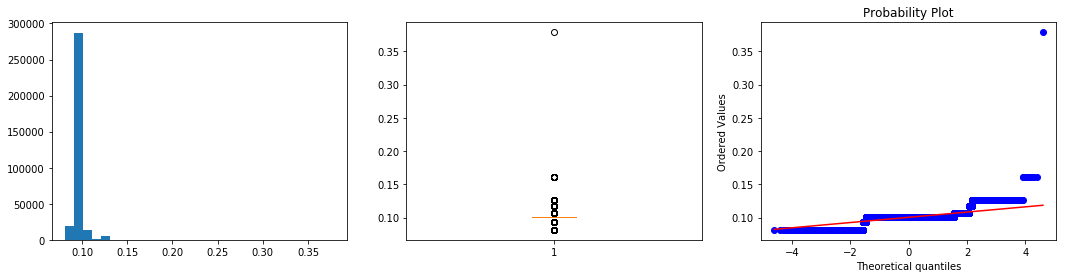

months_since_last_record ^-------



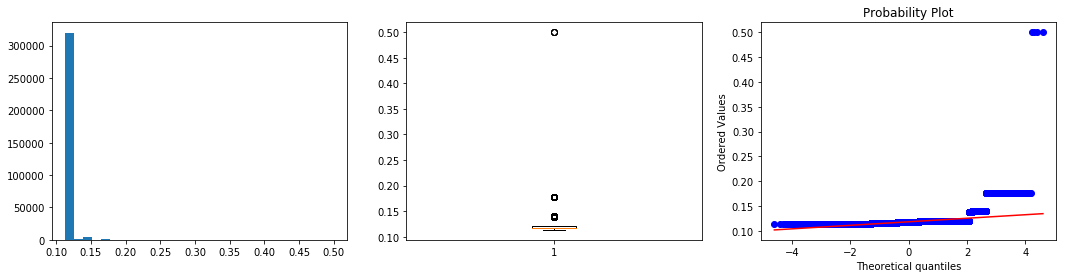

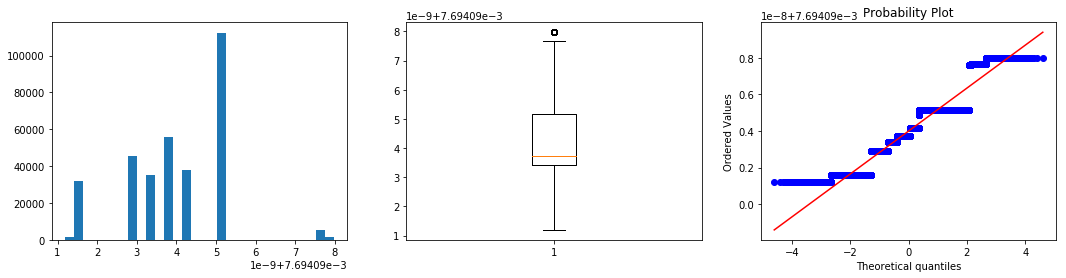

open_credit_lines ^-------



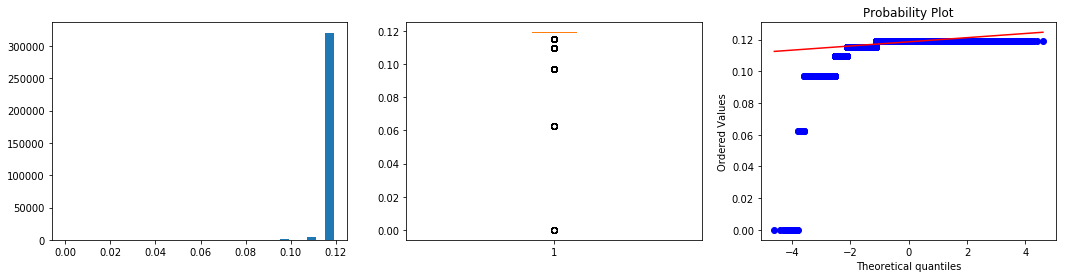

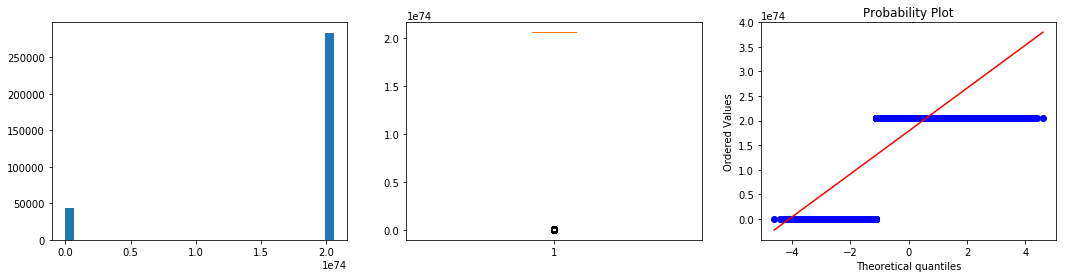

no_of_derog_public_records ^-------



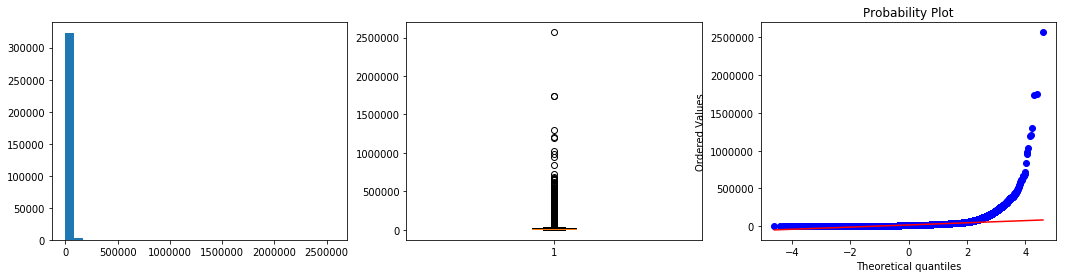

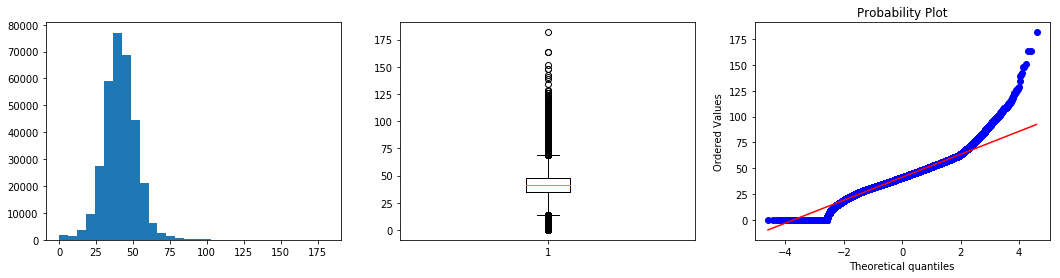

revolving_balance ^-------



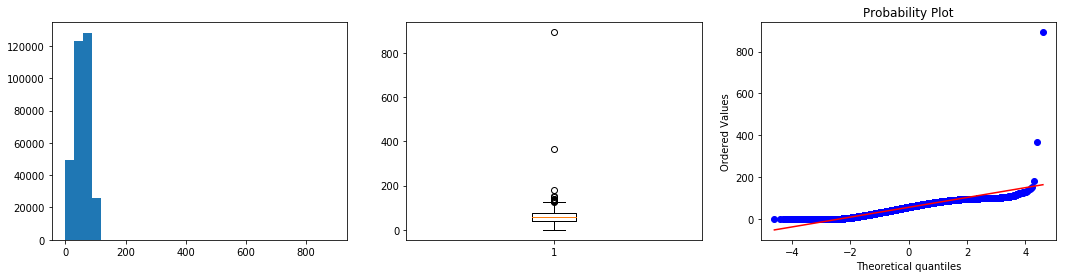

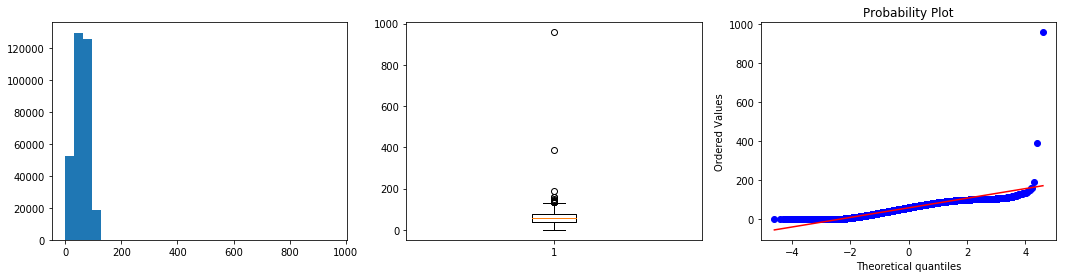

revolving_utilization_rate ^-------



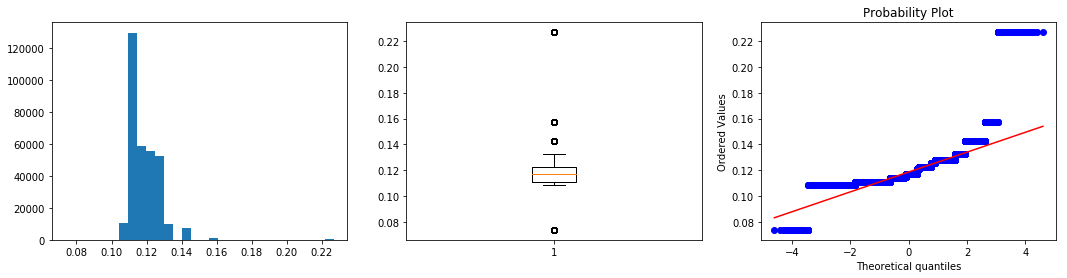

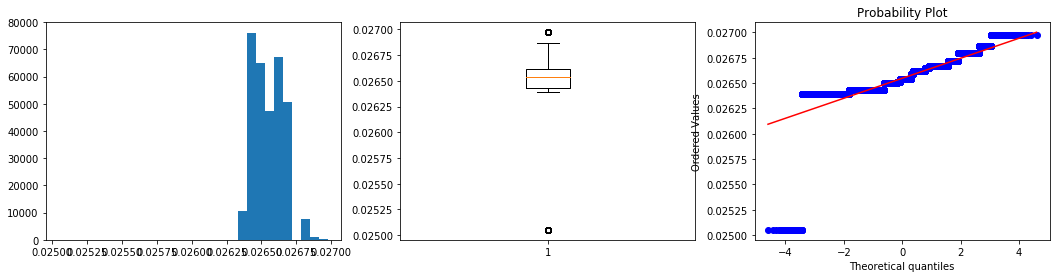

no_of_credit_lines ^-------



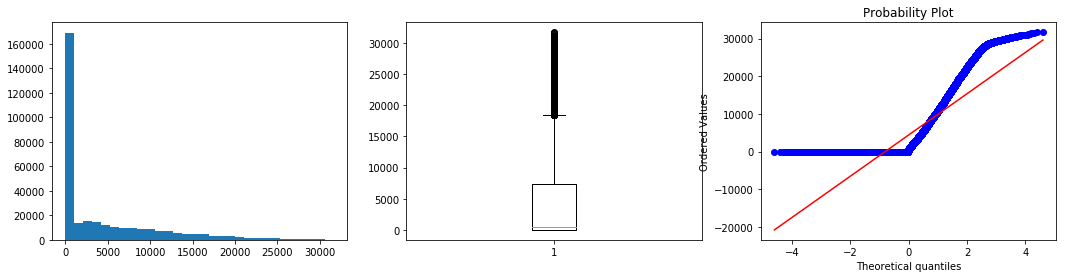

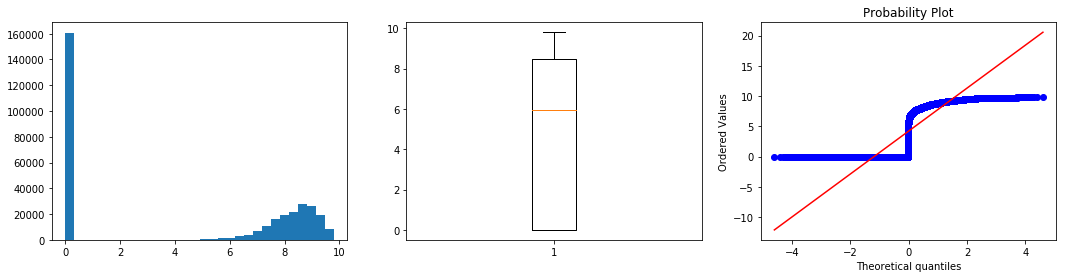

outstanding_amount ^-------



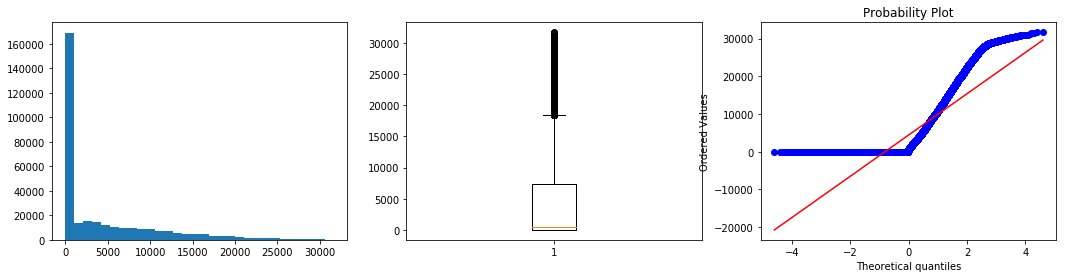

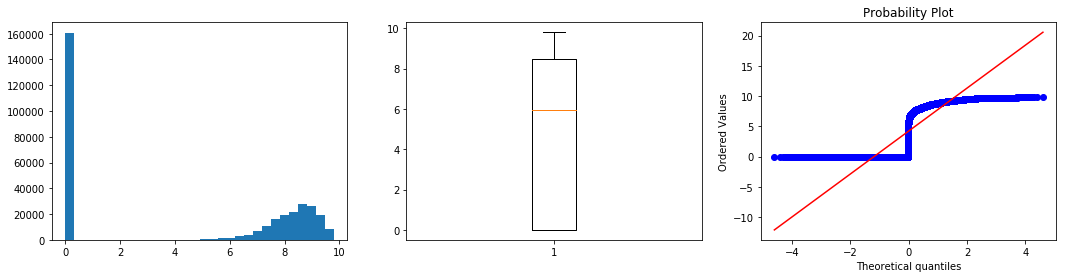

outstanding_amount_inv ^-------



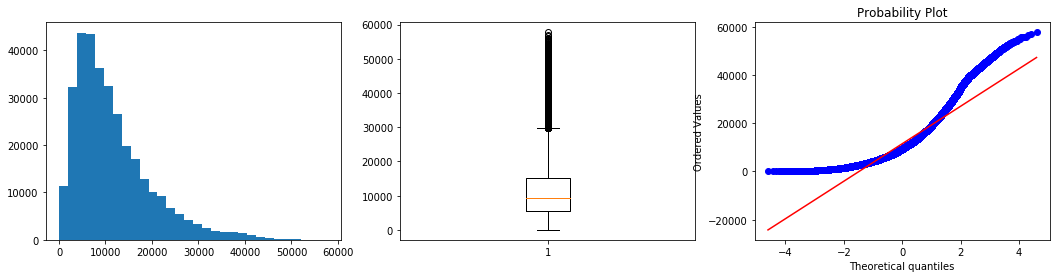

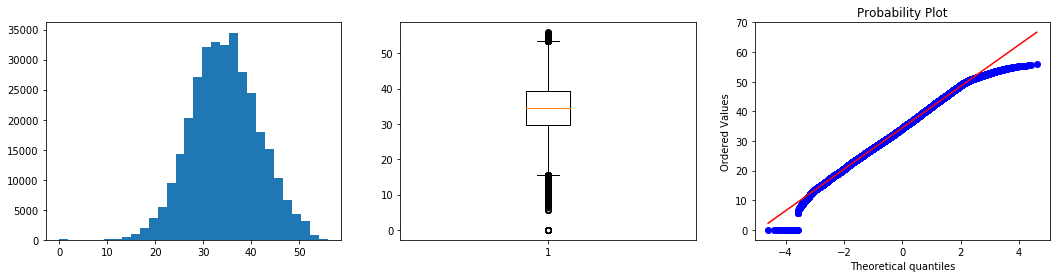

returned_amount ^-------



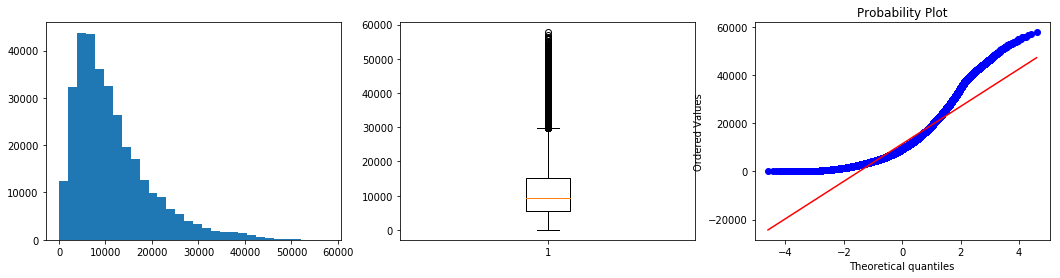

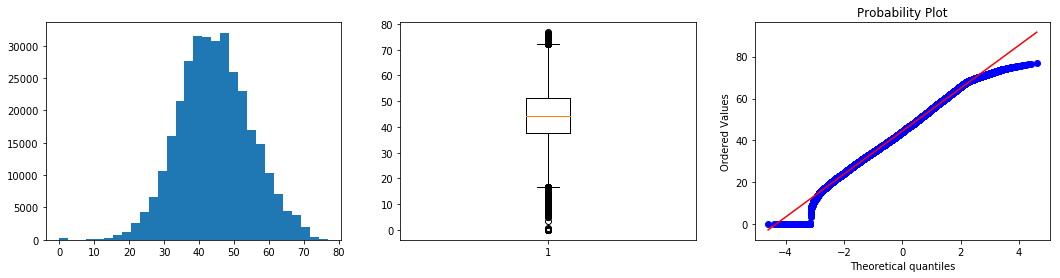

returned_amount_inv ^-------



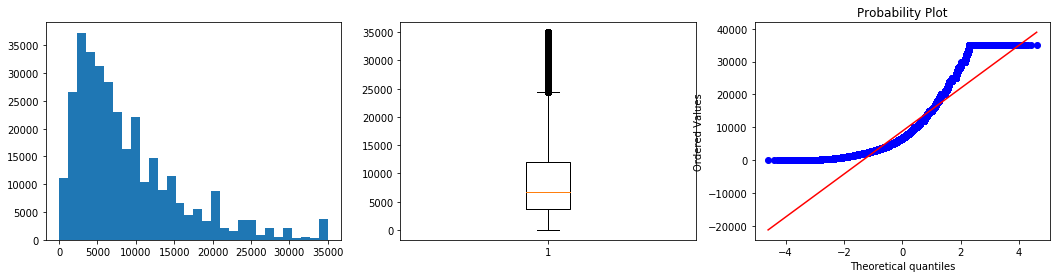

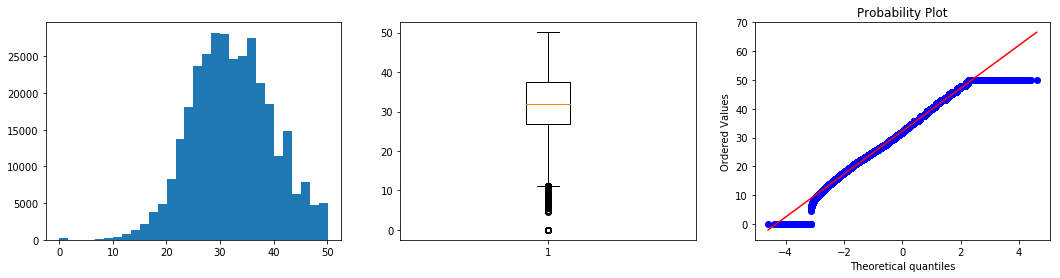

returned_principal_amount ^-------



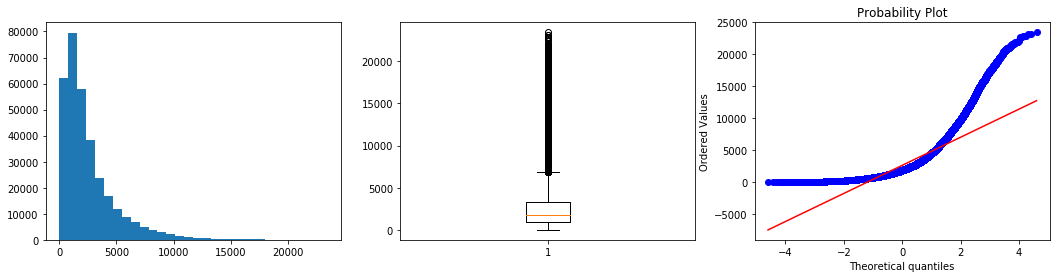

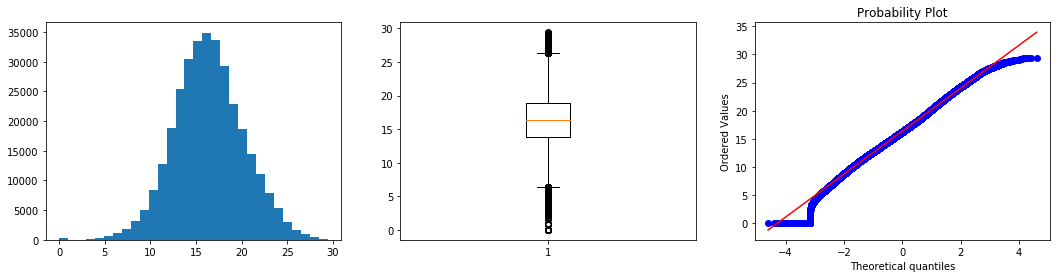

returned_interest_amount ^-------



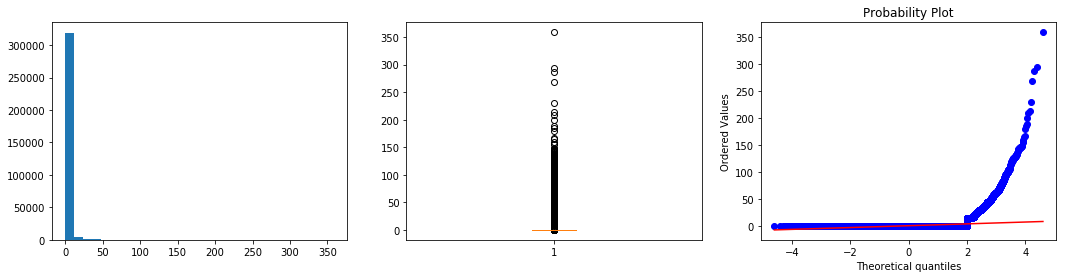

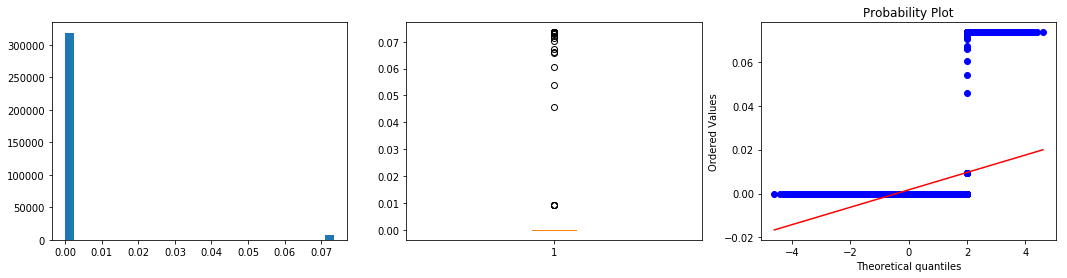

paid_late_fee_amount ^-------



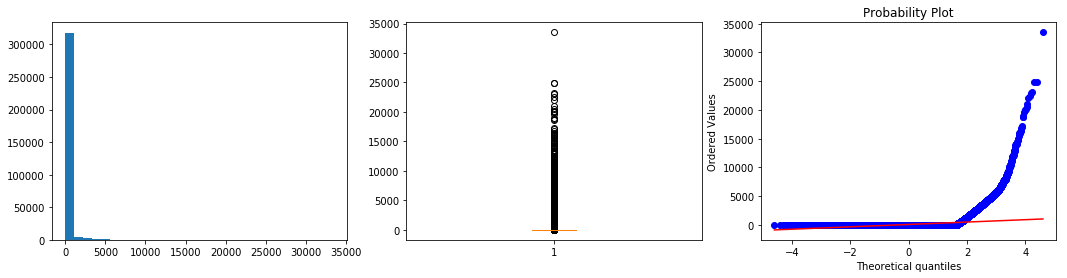

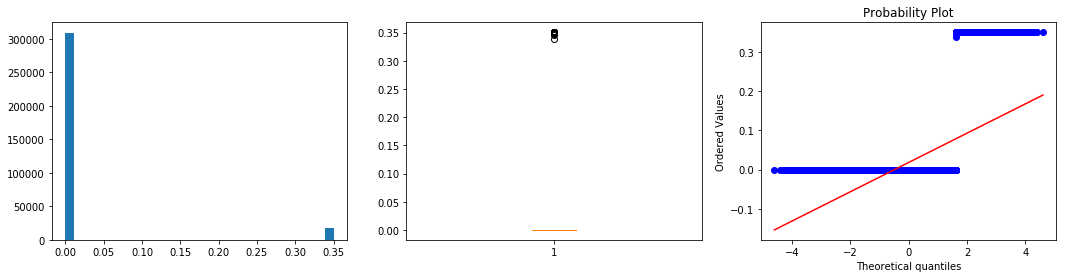

recoveries_amount ^-------



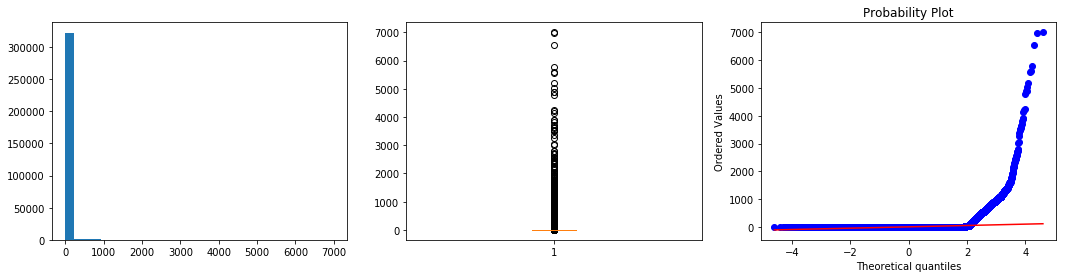

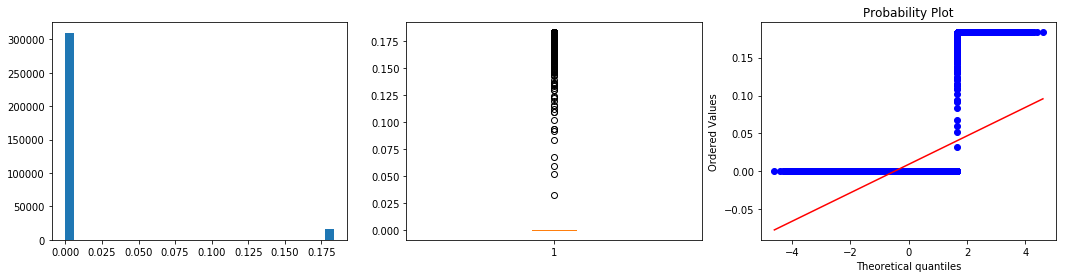

collection_fee ^-------



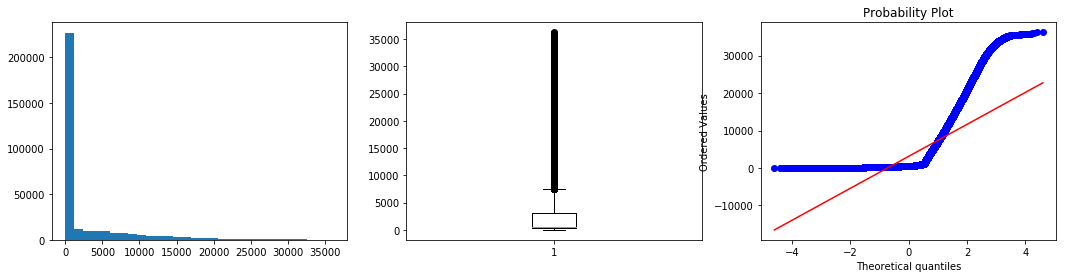

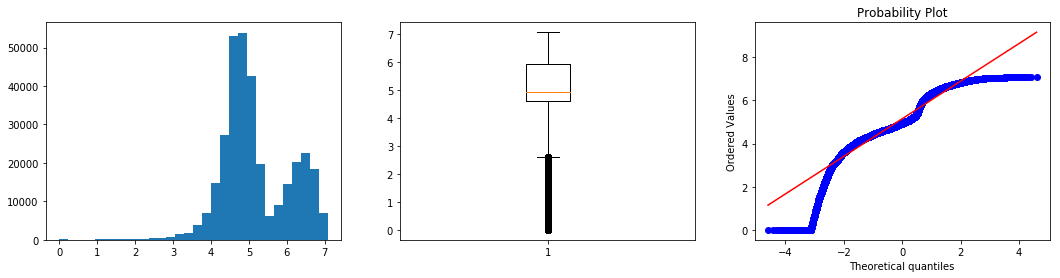

last_payment_amount ^-------



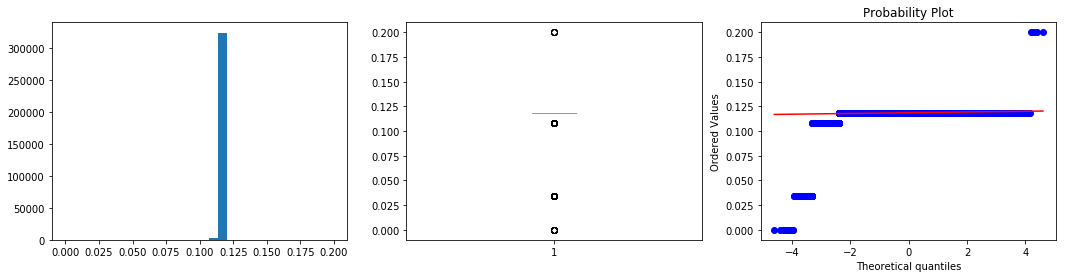

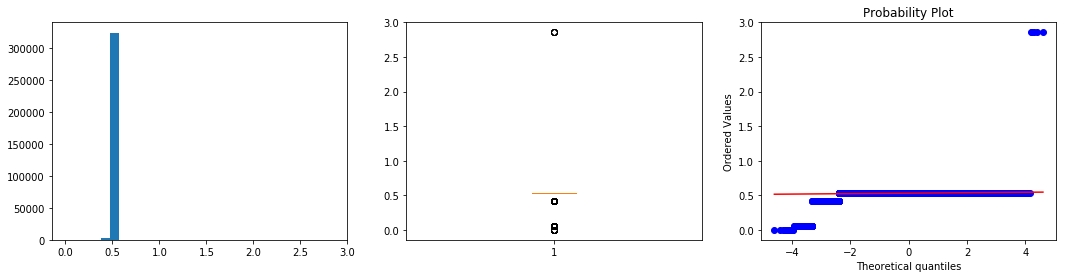

no_of_collections_12_mths_ex_med ^-------



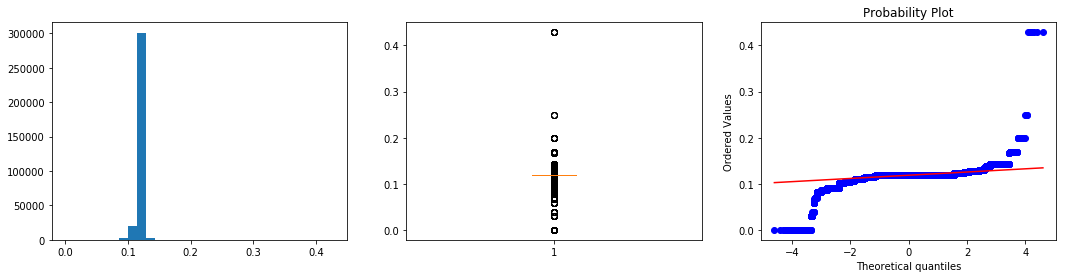

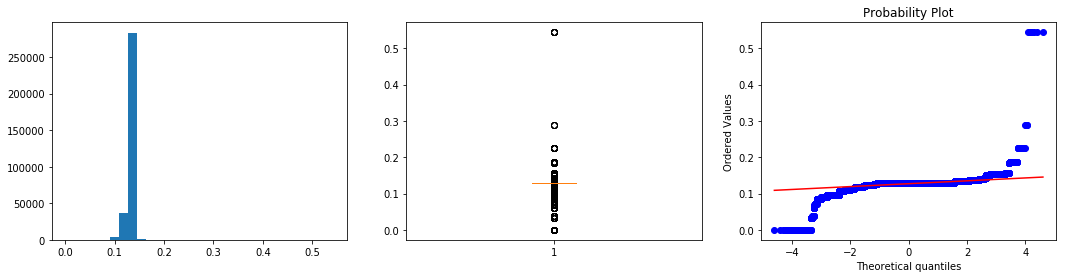

months_since_last_rating_derog ^-------



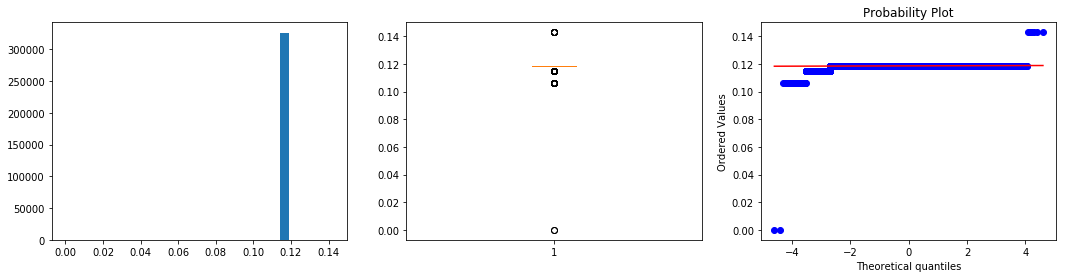

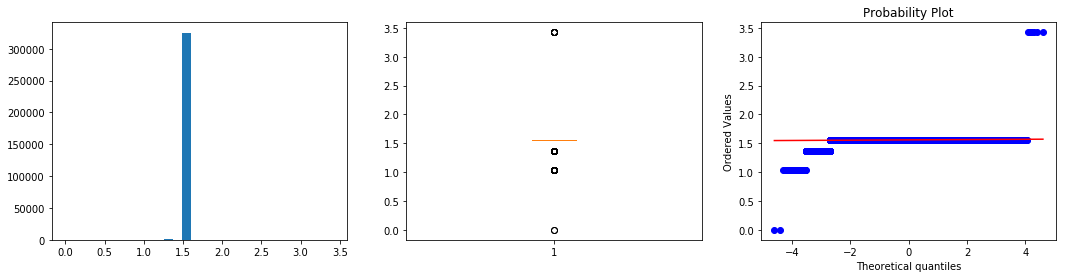

no_of_accounts_delinquent ^-------



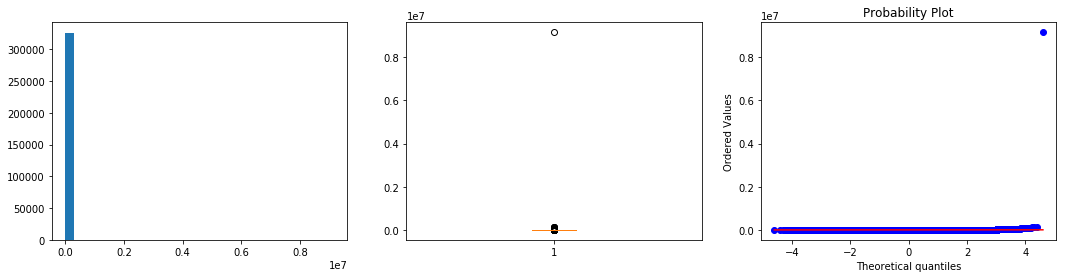

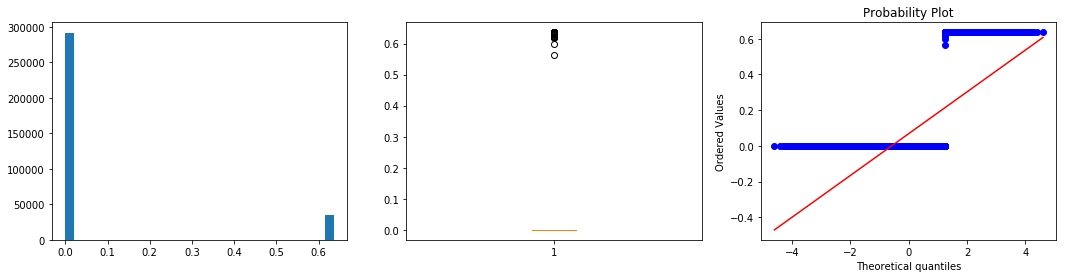

total_collection_amount ^-------



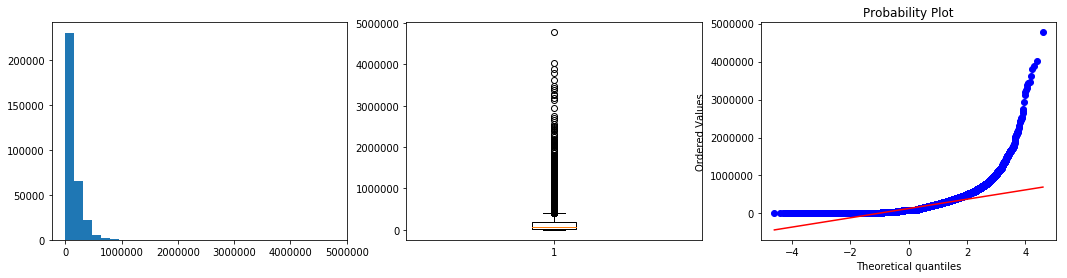

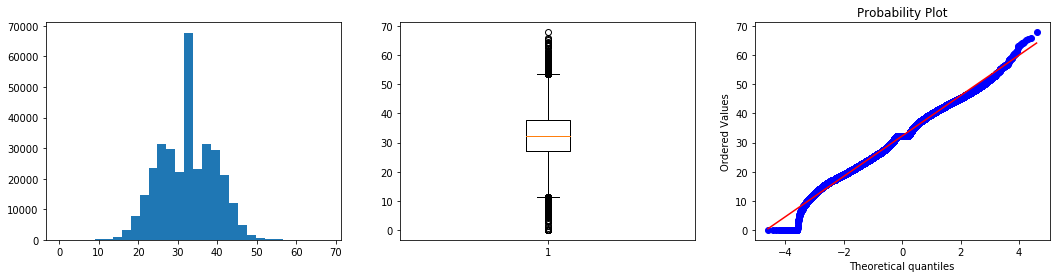

total_current_balance ^-------



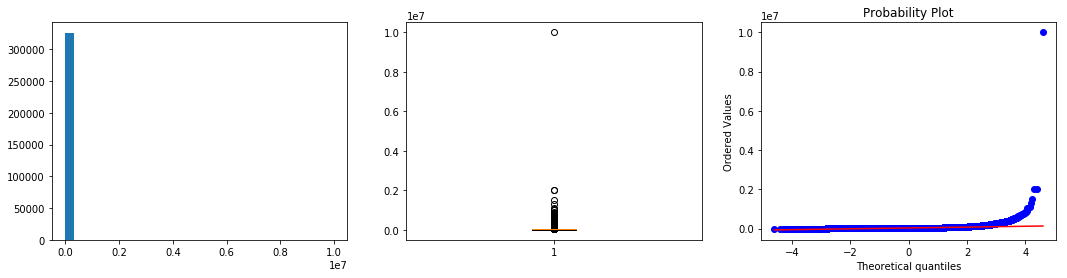

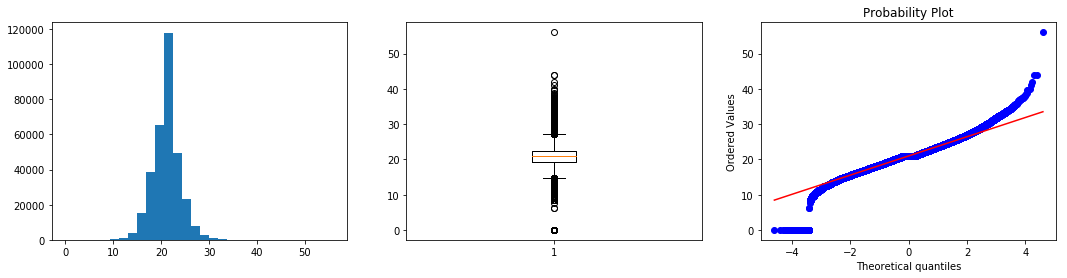

total_rev_hi_lim ^-------



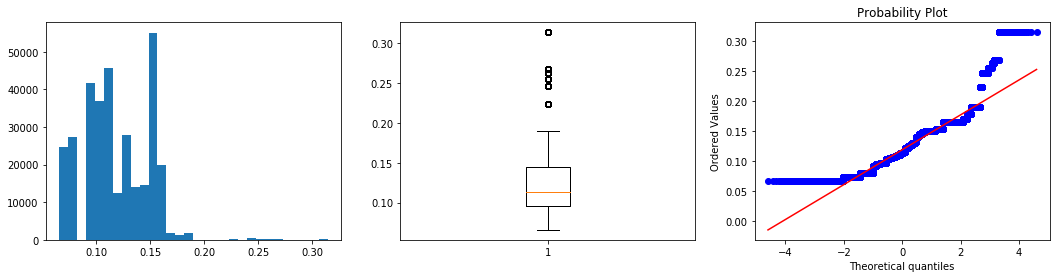

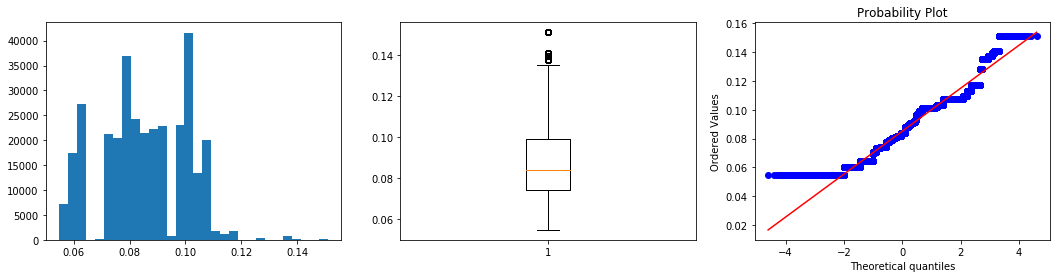

months_since_issue_date ^-------



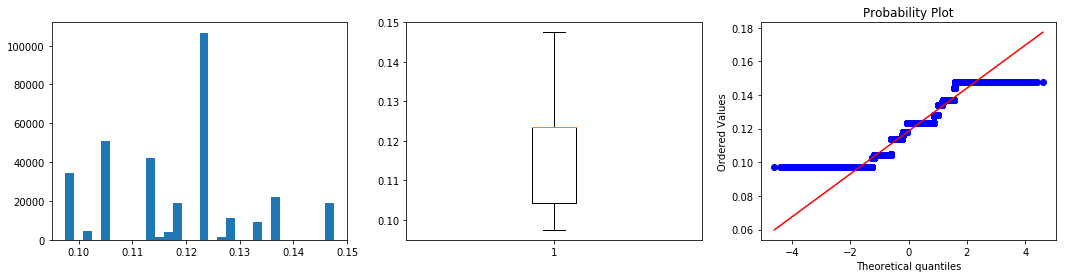

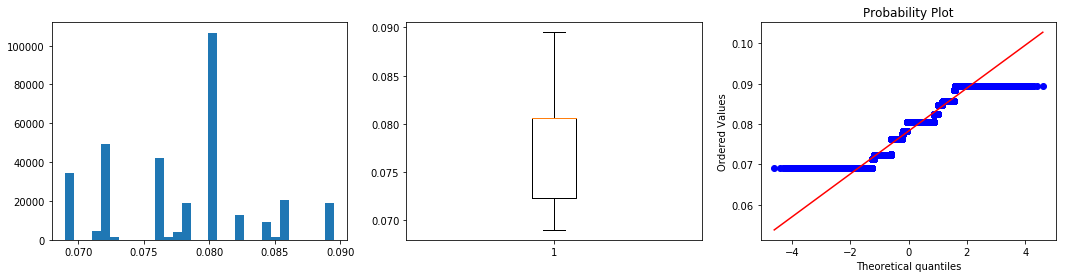

months_since_earliest_credit_line_date ^-------



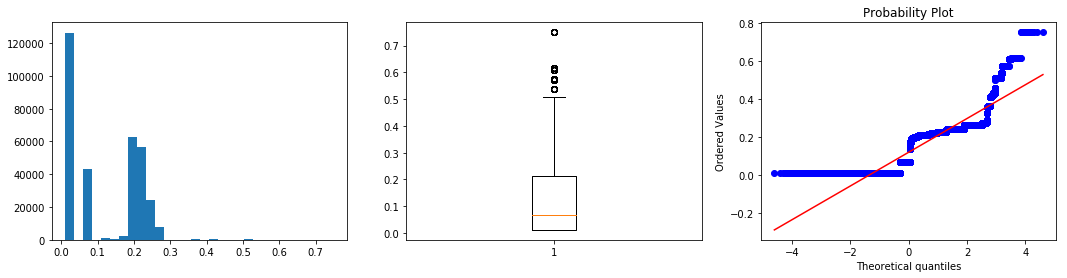

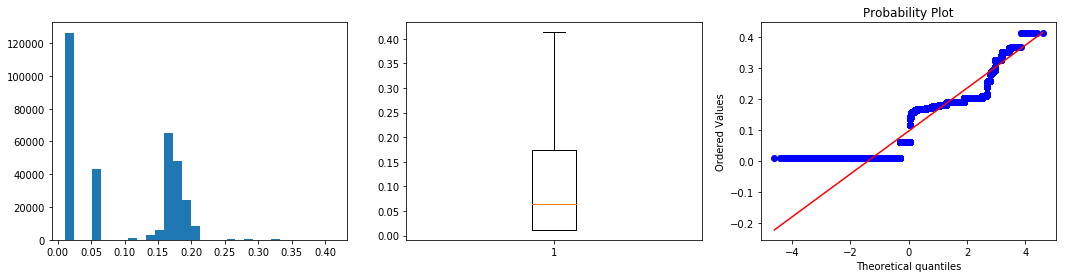

months_since_last_payment_date ^-------



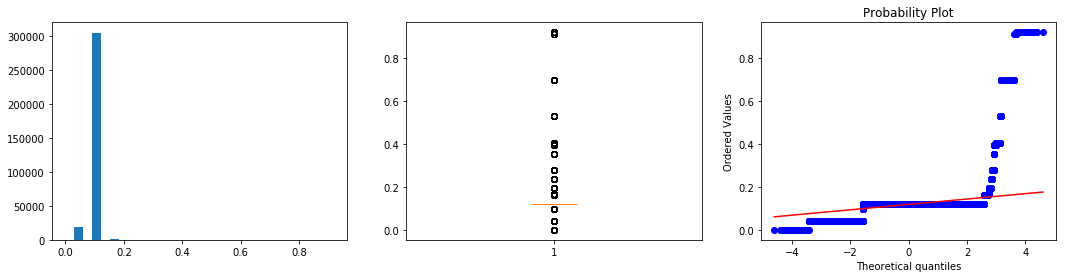

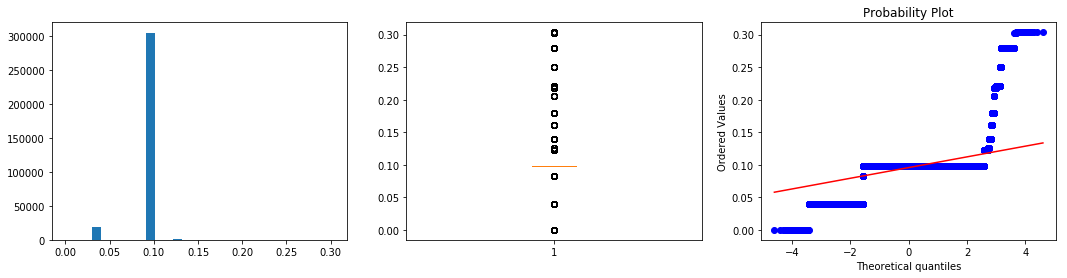

months_since_next_payment_date ^-------



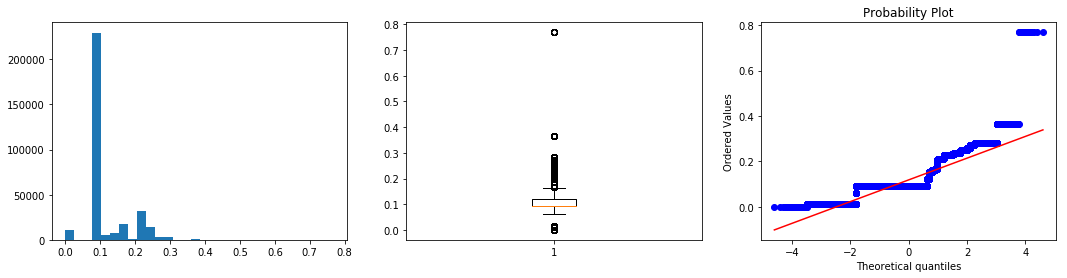

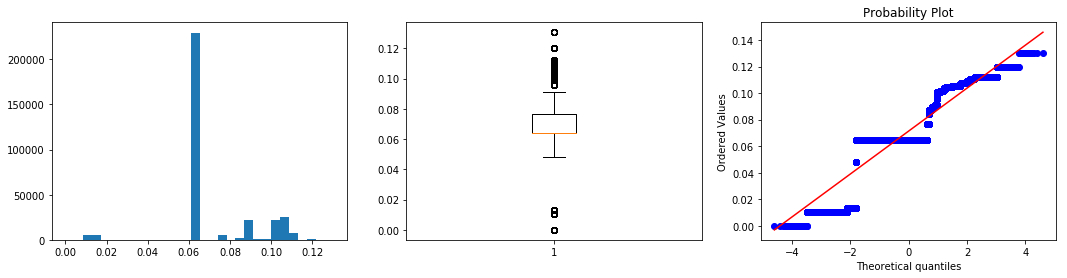

months_since_last_credit_pull_date ^-------



In [411]:
plot_compare_transformed_features(X_train, X_train_yj, cnt_num_colnames, regression=False)

Features that become closer to Gaussin distribution after Yeo-Johnson transformation are in the varaible `num_colnames_for_yj_trnf`.

#####################################################################  
**Final Yeo-Johnson transformation on selected numeric features**  
#####################################################################

In [412]:
num_colnames_for_yj_trnf = [
    'loan_applied_amount', 
    'loan_funded_amount',
    'investor_commit_amount',
    'interest_rate',
    'installment_amount',
    'annual_income',
    'debt_to_income',
    'revolving_balance',
    'returned_amount',
    'returned_amount_inv',
    'returned_principal_amount', 
    'returned_interest_amount',
    'total_current_balance',
    'total_rev_hi_lim'
]

yeo_jhn_tf = vt.YeoJohnsonTransformer(variables=num_colnames_for_yj_trnf)
yeo_jhn_tf.fit(X_train)
X_train = yeo_jhn_tf.transform(X_train)
X_test = yeo_jhn_tf.transform(X_test)

### Discretization of skewed features

1. Identify the continuous numeric features that do NOT get Gaussian distribution even after power transformation.
2. Discretize these features using Decision Tree discretizer from Feature-Engine.
3. This not only discretizes the feature but also creates a monotonic relationship between feature and target.

In [413]:
num_colnames_not_for_yj_trnf = [colname for colname in cnt_num_colnames if colname not in num_colnames_for_yj_trnf]
num_colnames_not_for_yj_trnf

['no_of_delinquencies',
 'no_of_inquires_6months',
 'months_since_last_delinq',
 'months_since_last_record',
 'open_credit_lines',
 'no_of_derog_public_records',
 'revolving_utilization_rate',
 'no_of_credit_lines',
 'outstanding_amount',
 'outstanding_amount_inv',
 'paid_late_fee_amount',
 'recoveries_amount',
 'collection_fee',
 'last_payment_amount',
 'no_of_collections_12_mths_ex_med',
 'months_since_last_rating_derog',
 'no_of_accounts_delinquent',
 'total_collection_amount',
 'months_since_issue_date',
 'months_since_earliest_credit_line_date',
 'months_since_last_payment_date',
 'months_since_next_payment_date',
 'months_since_last_credit_pull_date']

In [414]:
tree_disc = dsc.DecisionTreeDiscretiser(
    cv=3,
    scoring='roc_auc',
    variables=num_colnames_not_for_yj_trnf,
    regression=False,
    param_grid={'max_depth': [1, 2, 3, 4, 5]}
)

In [415]:
tree_disc.fit(X_train, y_train)

DecisionTreeDiscretiser(cv=3, param_grid={'max_depth': [1, 2, 3, 4, 5]},
            random_state=None, regression=False, scoring='roc_auc',
            variables=['no_of_delinquencies', 'no_of_inquires_6months', 'months_since_last_delinq', 'months_since_last_record', 'open_credit_lines', 'no_of_derog_public_records', 'revolving_utilization_rate', 'no_of_credit_lines', 'outstanding_amount', 'outstanding_amount_inv', 'paid_late_fee_amount', 'recoveri...hs_since_last_payment_date', 'months_since_next_payment_date', 'months_since_last_credit_pull_date'])

In [416]:
tree_disc.scores_dict_

{'no_of_delinquencies': 0.5026397144724846,
 'no_of_inquires_6months': 0.5551373072198832,
 'months_since_last_delinq': 0.5079450279689621,
 'months_since_last_record': 0.5119729320939379,
 'open_credit_lines': 0.5087041153598721,
 'no_of_derog_public_records': 0.5029690629154999,
 'revolving_utilization_rate': 0.5520914652857443,
 'no_of_credit_lines': 0.5205420484040927,
 'outstanding_amount': 0.6707773331730438,
 'outstanding_amount_inv': 0.67077752278602,
 'paid_late_fee_amount': 0.5430667913601838,
 'recoveries_amount': 0.7200945809752695,
 'collection_fee': 0.709822466857896,
 'last_payment_amount': 0.6719474145939894,
 'no_of_collections_12_mths_ex_med': 0.5005916814536089,
 'months_since_last_rating_derog': 0.5074215060478616,
 'no_of_accounts_delinquent': 0.5000839891171767,
 'total_collection_amount': 0.5060171938132945,
 'months_since_issue_date': 0.5797328008234248,
 'months_since_earliest_credit_line_date': 0.5351124378639737,
 'months_since_last_payment_date': 0.757547556

In [417]:
X_train = tree_disc.transform(X_train)
X_test = tree_disc.transform(X_test)

In [418]:
def plot_discretized_features(X, colnames):
    nrows = X.shape[0]
    for colname in colnames:
        bins_fraction = X.groupby([colname])[colname].count() / nrows
        fig = plt.figure()
        bins_fraction.plot.bar()
        plt.show()
        print(colname, '^----------')
        print()

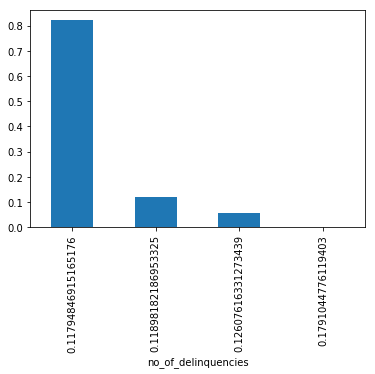

no_of_delinquencies ^----------



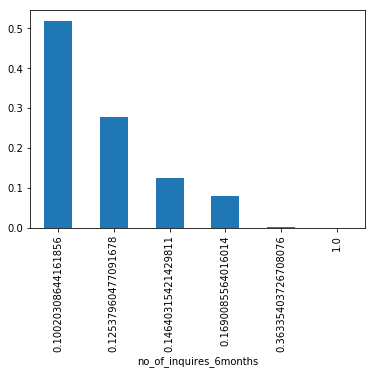

no_of_inquires_6months ^----------



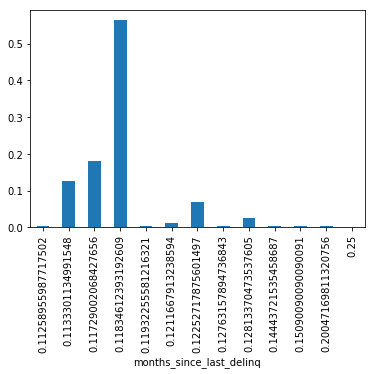

months_since_last_delinq ^----------



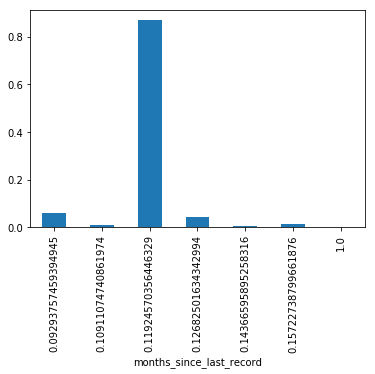

months_since_last_record ^----------



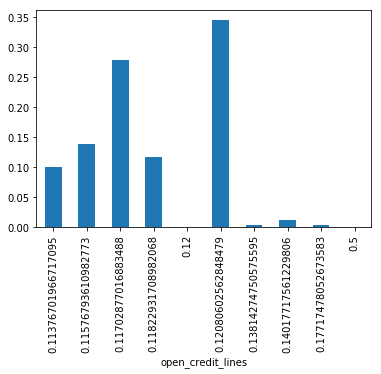

open_credit_lines ^----------



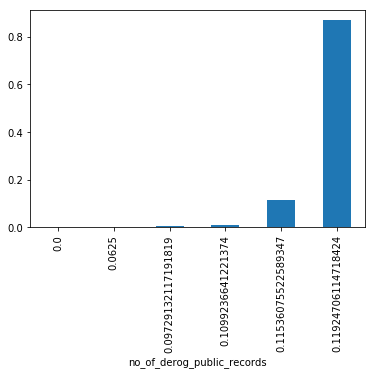

no_of_derog_public_records ^----------



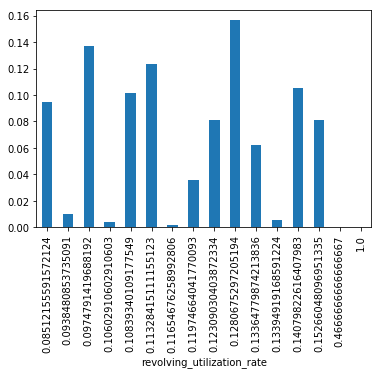

revolving_utilization_rate ^----------



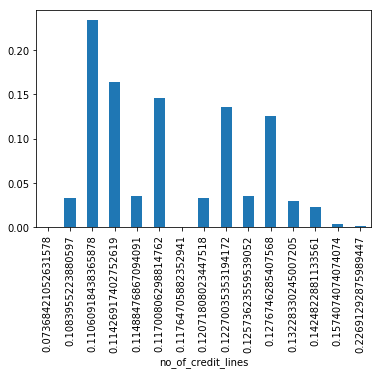

no_of_credit_lines ^----------



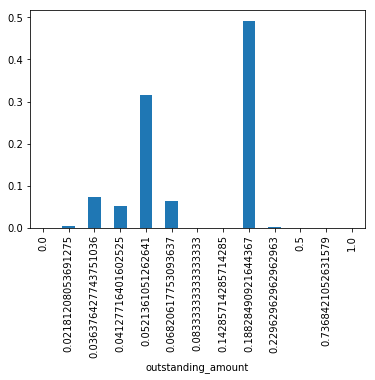

outstanding_amount ^----------



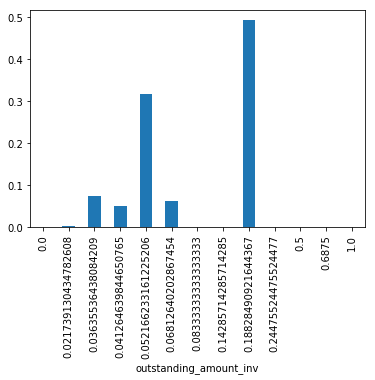

outstanding_amount_inv ^----------



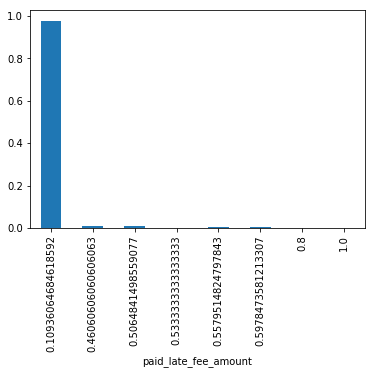

paid_late_fee_amount ^----------



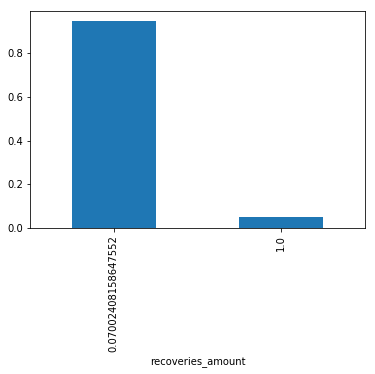

recoveries_amount ^----------



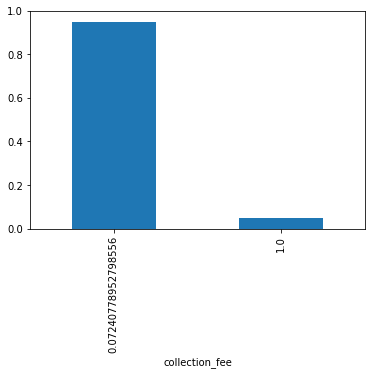

collection_fee ^----------



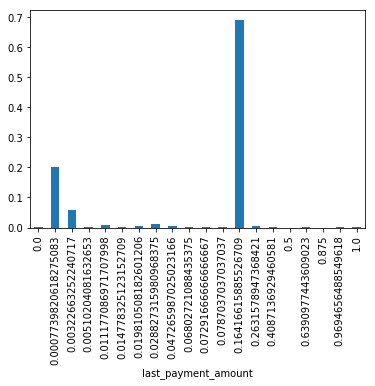

last_payment_amount ^----------



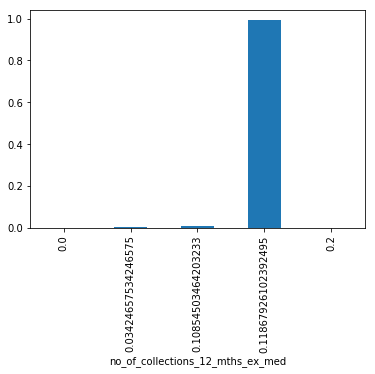

no_of_collections_12_mths_ex_med ^----------



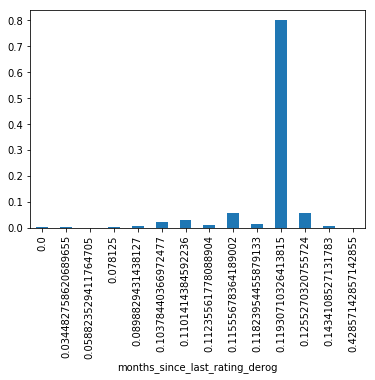

months_since_last_rating_derog ^----------



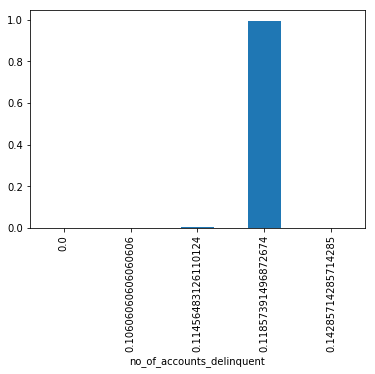

no_of_accounts_delinquent ^----------



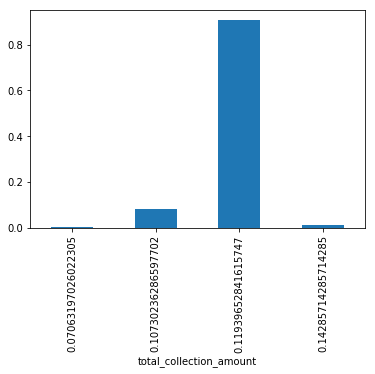

total_collection_amount ^----------



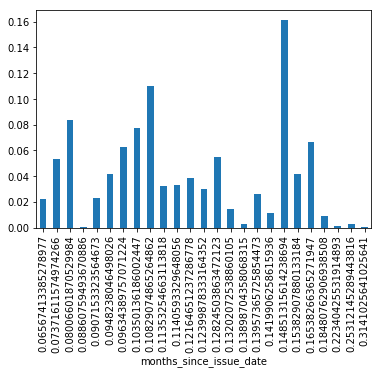

months_since_issue_date ^----------



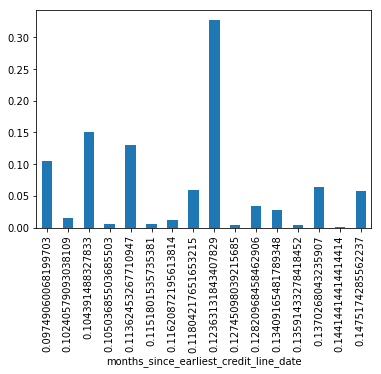

months_since_earliest_credit_line_date ^----------



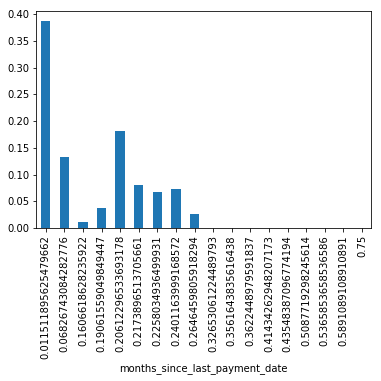

months_since_last_payment_date ^----------



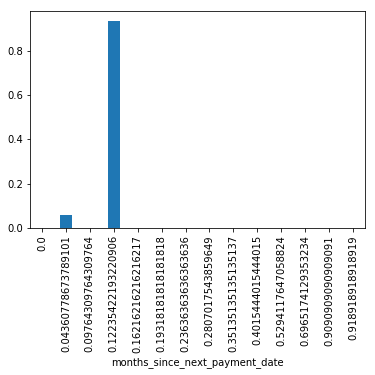

months_since_next_payment_date ^----------



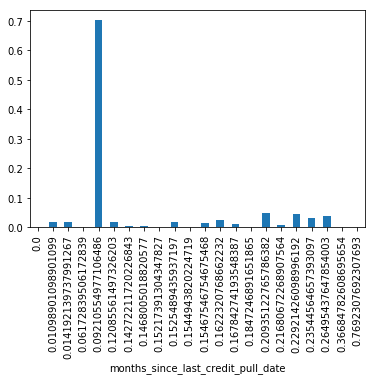

months_since_last_credit_pull_date ^----------



In [419]:
plot_discretized_features(X_train, num_colnames_not_for_yj_trnf)

In [420]:
X_train[num_colnames_not_for_yj_trnf].dtypes

no_of_delinquencies                       float64
no_of_inquires_6months                    float64
months_since_last_delinq                  float64
months_since_last_record                  float64
open_credit_lines                         float64
no_of_derog_public_records                float64
revolving_utilization_rate                float64
no_of_credit_lines                        float64
outstanding_amount                        float64
outstanding_amount_inv                    float64
paid_late_fee_amount                      float64
recoveries_amount                         float64
collection_fee                            float64
last_payment_amount                       float64
no_of_collections_12_mths_ex_med          float64
months_since_last_rating_derog            float64
no_of_accounts_delinquent                 float64
total_collection_amount                   float64
months_since_issue_date                   float64
months_since_earliest_credit_line_date    float64


In [421]:
X_train[num_colnames_for_yj_trnf].dtypes

loan_applied_amount          float64
loan_funded_amount           float64
investor_commit_amount       float64
interest_rate                float64
installment_amount           float64
annual_income                float64
debt_to_income               float64
revolving_balance            float64
returned_amount              float64
returned_amount_inv          float64
returned_principal_amount    float64
returned_interest_amount     float64
total_current_balance        float64
total_rev_hi_lim             float64
dtype: object

In [422]:
with open('./3_3.pkl', 'wb') as f:
    pickle.dump([X_train, X_test, y_train, y_test], f)
    f.close()

In [423]:
with open('./3_3.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)
    f.close()

In [424]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((326399, 56), (139886, 56), (326399,), (139886,))

## Categorical Encoding

### Identify rare labels

Mean of target is 0.1186  

Correlated to target:
* term
* grade
* sub_grade
* home_ownership
* verification_status
* is_payment_pan_in_place
* addr_state
* no_of_inquiries_6months
* initial_listing_status

Rare label encoding (RLE) threshold of 0.03:
* home_ownership
* loan_purpose
* addr_state
* no_of_delinquencies
* no_of_inquires_6months
* months_since_last_delinq
* months_since_last_record
* open_credit_lines
* no_of_derog_public_records
* no_of_credit_lines
* no_of_collections_12_mths_ex_med
* months_since_last_rating_derog
* no_of_accounts_delinquent
* loan_title

---------------------------------
-----------------------------------

* `emplyement_title` has exteremly high cardinality and hence deleted even before train-test split.

* `sub_grade` has labels with very low fractions but seem to have predictive power. Not doing any rare-label-encoding because it will lead to a feature very similar to grade.

* zip_code has a cardinality of 880 and the label with highest frequency is in 1% of observations. Use the first chararacter of zip code to categorize the labels. 10 new categories (0 to 9) https://en.wikipedia.org/wiki/ZIP_Code#Primary_state_prefixes

* Using WOE encoding on all the categorical features except addr_state which uses ratio encoding because for some labels have either p(0) or p(1) as 0 and hence woe is not defined.

* Fill the missing values after woe/ratio encoding.



**Convert categorical features into dtype `str`**

In [425]:
catg_colnames = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()
catg_colnames

['term',
 'grade',
 'sub_grade',
 'employement_length',
 'home_ownership',
 'verification_status',
 'is_pymnt_plan_in_place',
 'loan_purpose',
 'loan_title',
 'zip_code',
 'addr_state',
 'initial_listing_status']

In [426]:
class ObjectToStr(BaseEstimator, TransformerMixin):
    """
    Transformation to convert features of dtype object into dtype str. 
    Before the transformation columns with dtype object had values of mixed type.
    """
    def __init__(self):
        self.catg_colnames = [
            'term',
            'grade',
            'sub_grade',
            'employement_length',
            'home_ownership',
            'verification_status',
            'is_pymnt_plan_in_place',
            'loan_purpose',
            'loan_title',
            'zip_code',
            'addr_state',
            'initial_listing_status',
            'months_since_issue_date'
        ]

    def fit(self, X, y=None):
        self.catg_colnames = [colname for colname in X.columns if colname in self.catg_colnames]
        return self

    def transform(self, X):
        X = X.copy()
        X[self.catg_colnames] = X[self.catg_colnames] \
            .astype(dtype={colname: 'str' for colname in self.catg_colnames})
        return X

In [427]:
obj_to_str = ObjectToStr()
obj_to_str.fit(X_train)
X_train = obj_to_str.transform(X_train)
X_test = obj_to_str.transform(X_test)

In [428]:
'''
predictors_dtype_map = X_train.dtypes.to_dict()
catg_colnames = [colname for colname, dtype in predictors_dtype_map.items() if dtype == 'object']
'''

"\npredictors_dtype_map = X_train.dtypes.to_dict()\ncatg_colnames = [colname for colname, dtype in predictors_dtype_map.items() if dtype == 'object']\n"

In [429]:
def get_cardinality(df, catg_colnames):
    colname_cardinality_map = {
        catg_colname: len(df[catg_colname].unique()) for catg_colname in catg_colnames
    }
    return (pd.DataFrame
       .from_dict(colname_cardinality_map, orient='index', columns=['cardinality'])
       .reset_index()
       .rename(columns={'index':'colname'})
    )

In [430]:
cardinality_df = get_cardinality(X_train, catg_colnames)
cardinality_df

colname  cardinality
0                     term            2
1                    grade            7
2                sub_grade           35
3       employement_length           11
4           home_ownership            6
5      verification_status            3
6   is_pymnt_plan_in_place            2
7             loan_purpose           14
8               loan_title        46450
9                 zip_code          880
10              addr_state           50
11  initial_listing_status            2

In [431]:
print(cardinality_df.loc[cardinality_df['cardinality'] > 500, ['colname', 'cardinality']])
high_cardinal_colnames = cardinality_df.loc[cardinality_df['cardinality'] > 500, 'colname'].values.tolist()
high_cardinal_colnames

      colname  cardinality
8  loan_title        46450
9    zip_code          880


['loan_title', 'zip_code']

In [432]:
def plot_labels_frac_meanY(
    X, 
    y,
    cardinality_df,
    colnames, 
    ignore_colnames,
    rare_lbl_threshold=0.03,
    plot_x_labels=True,
):
    n_rows = len(X)
    if ignore_colnames:
        colnames = [colname for colname in colnames if colname not in ignore_colnames]
    for colname in colnames:
        label_frac = pd.Series(X[colname].value_counts() / n_rows)
        label_frac_df = (label_frac
            .to_frame()
            .reset_index()
            .rename(columns={'index': 'labels'})
        )
        
        labels = label_frac_df['labels']
        label_mean_y = list()
        for lbl in labels:
            x_idx = X.loc[X[colname] == lbl, colname].index
            y_idx = [idx for idx in x_idx if idx in y.index]
            label_mean_y.append(y[y_idx].mean())
        if len(labels) == len(label_mean_y):
            label_frac_df['mean_y'] = label_mean_y
        else:
            print("error in calculating mean of y")

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.bar(x='labels', height=colname, data=label_frac_df)
        # ax.bar(x=label_frac_df['labels'], height=label_frac_df[colname])
        if not plot_x_labels:
            ax.set_xticks([])
        ax.set_xlabel(colname)
        # ax.set_ylim(0, 1)
        ax.axhline(y=rare_lbl_threshold, color='red')
        ax.set_ylabel('fraction of observations')
        ax2 = ax.twinx()
        sns.pointplot(x='labels', y='mean_y', data=label_frac_df, color='black')
        ax2.set_xticks([])
        ax2.set_ylim(0, 1)
        plt.show()
        plt.close()
        
        print(label_frac_df)
        print(colname, '^------------')
        print()

In [433]:
y_train.mean()

0.11855734852128837

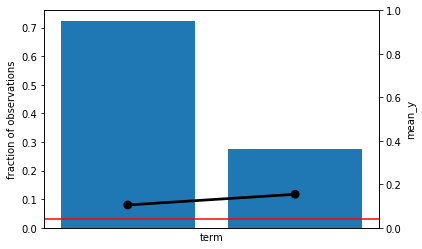

       labels      term    mean_y
0   36 months  0.724196  0.105019
1   60 months  0.275804  0.154107
term ^------------



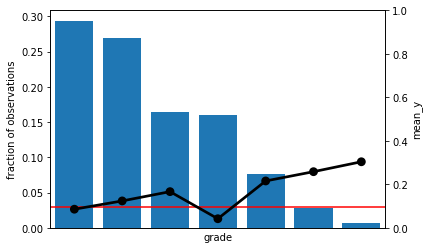

  labels     grade    mean_y
0      B  0.293757  0.085532
1      C  0.268772  0.123599
2      D  0.164746  0.166292
3      A  0.160028  0.041717
4      E  0.076860  0.215450
5      F  0.028563  0.258071
6      G  0.007273  0.303707
grade ^------------



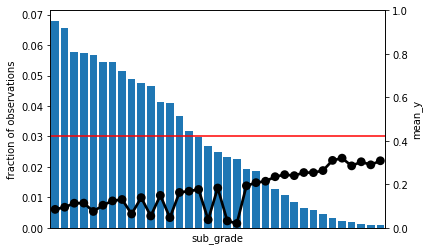

   labels  sub_grade    mean_y
0      B3   0.067969  0.085193
1      B4   0.065659  0.095003
2      C1   0.057782  0.113468
3      C2   0.057549  0.113980
4      B2   0.056737  0.075598
5      B5   0.054489  0.104245
6      C3   0.054317  0.124203
7      C4   0.051566  0.130652
8      B1   0.048903  0.063964
9      C5   0.047558  0.139213
10     A5   0.046501  0.054684
11     D1   0.041425  0.149471
12     A4   0.040855  0.047019
13     D2   0.036609  0.163110
14     D3   0.031921  0.168730
15     D4   0.029963  0.176687
16     A3   0.026881  0.037497
17     D5   0.024829  0.183366
18     A2   0.023220  0.032062
19     A1   0.022571  0.020361
20     E1   0.019412  0.193655
21     E2   0.018600  0.208038
22     E3   0.015162  0.214589
23     E4   0.012926  0.235364
24     E5   0.010760  0.244875
25     F1   0.008582  0.240271
26     F2   0.006464  0.254502
27     F3   0.005714  0.254155
28     F4   0.004498  0.263624
29     F5   0.003306  0.310473
30     G1   0.002417  0.320659
31     G

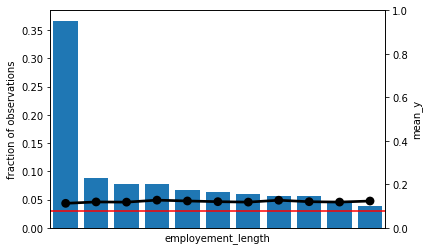

       labels  employement_length    mean_y
0   10+ years            0.366659  0.112962
1     2 years            0.088692  0.119382
2     3 years            0.078165  0.118489
3    < 1 year            0.078125  0.127647
4     5 years            0.066406  0.123829
5      1 year            0.063343  0.120580
6     4 years            0.060193  0.118593
7     6 years            0.055996  0.127209
8     7 years            0.055953  0.120462
9     8 years            0.048232  0.118783
10    9 years            0.038235  0.123558
employement_length ^------------



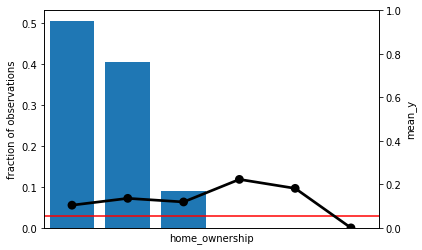

     labels  home_ownership    mean_y
0  MORTGAGE        0.505274  0.104456
1      RENT        0.404670  0.135883
2       OWN        0.089553  0.119295
3     OTHER        0.000398  0.223077
4      NONE        0.000101  0.181818
5       ANY        0.000003  0.000000
home_ownership ^------------



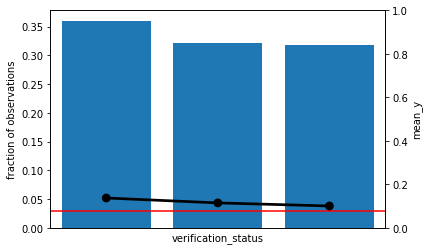

            labels  verification_status    mean_y
0         Verified             0.360344  0.137439
1  Source Verified             0.321913  0.114950
2     Not Verified             0.317743  0.100799
verification_status ^------------



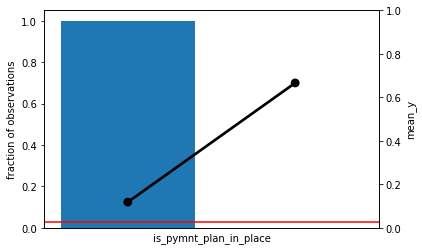

  labels  is_pymnt_plan_in_place    mean_y
0      n                0.999982  0.118547
1      y                0.000018  0.666667
is_pymnt_plan_in_place ^------------



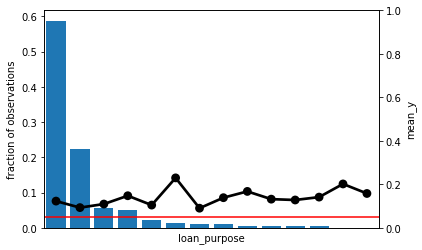

                labels  loan_purpose    mean_y
0   debt_consolidation      0.587759  0.123262
1          credit_card      0.223631  0.093283
2     home_improvement      0.056949  0.109641
3                other      0.050944  0.147883
4       major_purchase      0.021143  0.104912
5       small_business      0.014877  0.230025
6                  car      0.011599  0.090597
7              medical      0.009859  0.138906
8               moving      0.006483  0.167769
9             vacation      0.005377  0.132194
10             wedding      0.004917  0.128349
11               house      0.004804  0.141582
12         educational      0.000864  0.202128
13    renewable_energy      0.000794  0.158301
loan_purpose ^------------



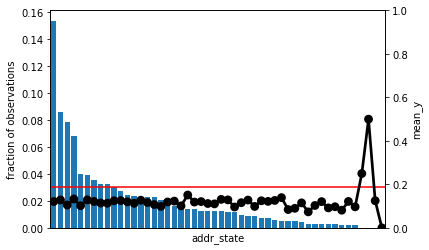

   labels  addr_state    mean_y
0      CA    0.153377  0.121230
1      NY    0.086088  0.128403
2      TX    0.078422  0.105286
3      FL    0.067993  0.132835
4      IL    0.040242  0.102094
5      NJ    0.038903  0.128839
6      PA    0.035218  0.121444
7      OH    0.032353  0.114205
8      GA    0.032169  0.113429
9      VA    0.030334  0.124735
10     NC    0.027525  0.125668
11     MI    0.024654  0.119796
12     MA    0.023775  0.113015
13     MD    0.023248  0.127306
14     AZ    0.023131  0.116689
15     WA    0.022791  0.107272
16     CO    0.020910  0.098901
17     MN    0.017442  0.119094
18     MO    0.016118  0.123170
19     CT    0.015288  0.101403
20     NV    0.014029  0.151125
21     IN    0.013771  0.118799
22     TN    0.012855  0.121068
23     OR    0.012650  0.112134
24     WI    0.012558  0.110515
25     AL    0.012436  0.131067
26     LA    0.011936  0.128850
27     SC    0.011857  0.096124
28     KY    0.009470  0.115820
29     OK    0.008854  0.128028
30     K

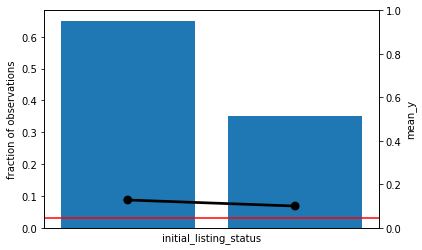

  labels  initial_listing_status    mean_y
0      f                0.650174  0.128289
1      w                0.349826  0.100470
initial_listing_status ^------------



In [434]:
plot_labels_frac_meanY(
    X=X_train, 
    y=y_train, 
    cardinality_df=cardinality_df, 
    colnames=catg_colnames, 
    ignore_colnames=high_cardinal_colnames, 
    rare_lbl_threshold=0.03,
    plot_x_labels=False
)

In [435]:
# Use this with high cardinal features
# Not plotting the label-fractions and mean_y due to high cardinality
def get_label_fraction(df, colnames):
    n_rows = len(X_train)
    for colname in colnames:
        label_frac = pd.Series(X_train[colname].value_counts() / n_rows)
        print()
        print(colname, '<----')
        print(label_frac)

In [436]:
get_label_fraction(
    df=X_train,
    colnames=high_cardinal_colnames
)


loan_title <----
Debt consolidation                             0.352369
Credit card refinancing                        0.134063
Debt Consolidation                             0.033683
Home improvement                               0.031869
Other                                          0.027194
Consolidation                                  0.011547
debt consolidation                             0.010346
Major purchase                                 0.009930
Debt Consolidation Loan                        0.008104
Business                                       0.007194
Medical expenses                               0.005787
Credit Card Consolidation                      0.005123
consolidation                                  0.004681
Personal Loan                                  0.004531
Car financing                                  0.004436
Consolidation Loan                             0.003839
Home Improvement                               0.003833
Vacation                      

In [437]:
class ZipcodeEncode(BaseEstimator, TransformerMixin):
    """
    zip_code is a categorical variabel with cardinality of 880.
    Use only the first digit in the zip code. First digit in zip-code 
    corresponds to a small set of nearby states in USA.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['zip_code'] = X['zip_code'].apply(lambda x: x[0])
        return X


In [441]:
# rle is rare label encoding
# columns for rare label encoding
rle_colnames = [
    'home_ownership',
    'loan_purpose',
    'addr_state',
    'loan_title',
]

In [439]:
zip_encoder = ZipcodeEncode()
zip_encoder.fit(X_train)
X_train = zip_encoder.transform(X_train)
X_test = zip_encoder.transform(X_test)

In [442]:
rare_encoder = ce.RareLabelCategoricalEncoder(
    tol=0.03,
    n_categories=3,
    variables=rle_colnames
)
rare_encoder.fit(X_train)
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

In [443]:
for colname in rle_colnames:
    print(colname)
    print(X_train[colname].unique())

home_ownership
['RENT' 'MORTGAGE' 'OWN' 'Rare']
loan_purpose
['credit_card' 'debt_consolidation' 'other' 'Rare' 'home_improvement']
addr_state
['Rare' 'CA' 'NY' 'FL' 'GA' 'TX' 'PA' 'IL' 'NJ' 'VA' 'OH']
loan_title
['Credit card refinancing' 'Debt consolidation' 'Rare'
 'Debt Consolidation' 'Home improvement']


In [444]:
cardinality_df = get_cardinality(X_train, catg_colnames)
cardinality_df

colname  cardinality
0                     term            2
1                    grade            7
2                sub_grade           35
3       employement_length           11
4           home_ownership            4
5      verification_status            3
6   is_pymnt_plan_in_place            2
7             loan_purpose            5
8               loan_title            5
9                 zip_code           10
10              addr_state           11
11  initial_listing_status            2

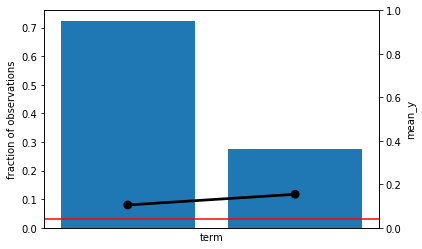

       labels      term    mean_y
0   36 months  0.724196  0.105019
1   60 months  0.275804  0.154107
term ^------------



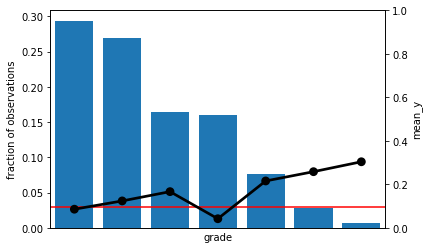

  labels     grade    mean_y
0      B  0.293757  0.085532
1      C  0.268772  0.123599
2      D  0.164746  0.166292
3      A  0.160028  0.041717
4      E  0.076860  0.215450
5      F  0.028563  0.258071
6      G  0.007273  0.303707
grade ^------------



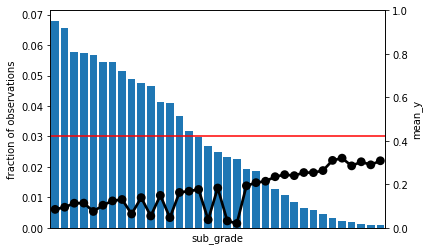

   labels  sub_grade    mean_y
0      B3   0.067969  0.085193
1      B4   0.065659  0.095003
2      C1   0.057782  0.113468
3      C2   0.057549  0.113980
4      B2   0.056737  0.075598
5      B5   0.054489  0.104245
6      C3   0.054317  0.124203
7      C4   0.051566  0.130652
8      B1   0.048903  0.063964
9      C5   0.047558  0.139213
10     A5   0.046501  0.054684
11     D1   0.041425  0.149471
12     A4   0.040855  0.047019
13     D2   0.036609  0.163110
14     D3   0.031921  0.168730
15     D4   0.029963  0.176687
16     A3   0.026881  0.037497
17     D5   0.024829  0.183366
18     A2   0.023220  0.032062
19     A1   0.022571  0.020361
20     E1   0.019412  0.193655
21     E2   0.018600  0.208038
22     E3   0.015162  0.214589
23     E4   0.012926  0.235364
24     E5   0.010760  0.244875
25     F1   0.008582  0.240271
26     F2   0.006464  0.254502
27     F3   0.005714  0.254155
28     F4   0.004498  0.263624
29     F5   0.003306  0.310473
30     G1   0.002417  0.320659
31     G

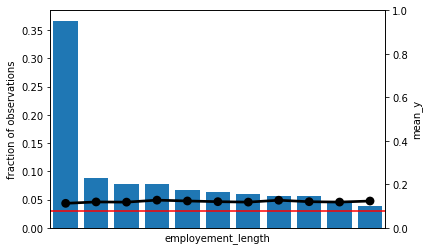

       labels  employement_length    mean_y
0   10+ years            0.366659  0.112962
1     2 years            0.088692  0.119382
2     3 years            0.078165  0.118489
3    < 1 year            0.078125  0.127647
4     5 years            0.066406  0.123829
5      1 year            0.063343  0.120580
6     4 years            0.060193  0.118593
7     6 years            0.055996  0.127209
8     7 years            0.055953  0.120462
9     8 years            0.048232  0.118783
10    9 years            0.038235  0.123558
employement_length ^------------



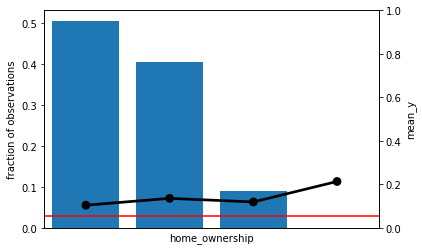

     labels  home_ownership    mean_y
0  MORTGAGE        0.505274  0.104456
1      RENT        0.404670  0.135883
2       OWN        0.089553  0.119295
3      Rare        0.000502  0.213415
home_ownership ^------------



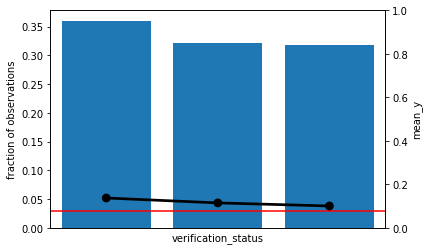

            labels  verification_status    mean_y
0         Verified             0.360344  0.137439
1  Source Verified             0.321913  0.114950
2     Not Verified             0.317743  0.100799
verification_status ^------------



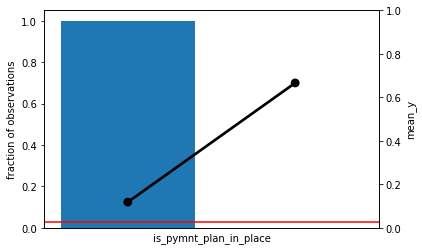

  labels  is_pymnt_plan_in_place    mean_y
0      n                0.999982  0.118547
1      y                0.000018  0.666667
is_pymnt_plan_in_place ^------------



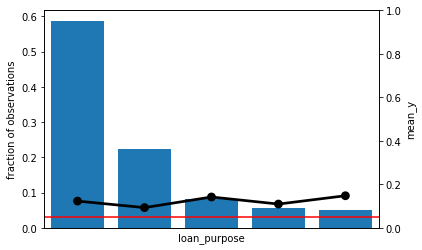

               labels  loan_purpose    mean_y
0  debt_consolidation      0.587759  0.123262
1         credit_card      0.223631  0.093283
2                Rare      0.080717  0.142109
3    home_improvement      0.056949  0.109641
4               other      0.050944  0.147883
loan_purpose ^------------



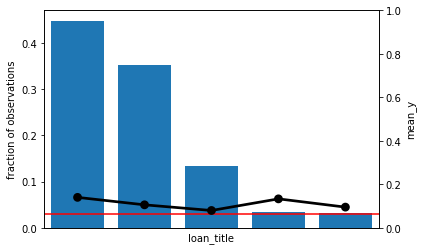

                    labels  loan_title    mean_y
0                     Rare    0.448016  0.140373
1       Debt consolidation    0.352369  0.106110
2  Credit card refinancing    0.134063  0.080077
3       Debt Consolidation    0.033683  0.133527
4         Home improvement    0.031869  0.095559
loan_title ^------------



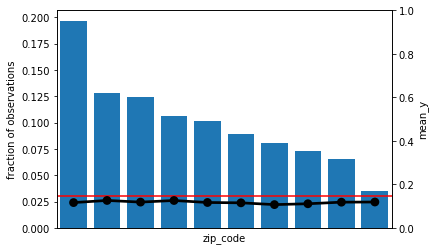

  labels  zip_code    mean_y
0      9  0.196753  0.119059
1      3  0.128144  0.126046
2      1  0.124023  0.126232
3      7  0.106762  0.111028
4      2  0.101195  0.118619
5      0  0.089213  0.116384
6      4  0.080279  0.116819
7      8  0.073527  0.118297
8      6  0.065058  0.107087
9      5  0.035046  0.115307
zip_code ^------------



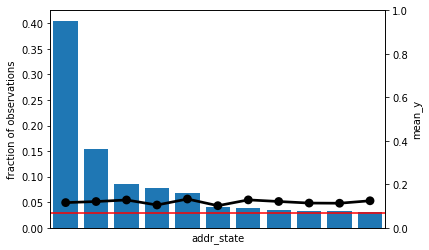

   labels  addr_state    mean_y
0    Rare    0.404900  0.116314
1      CA    0.153377  0.121230
2      NY    0.086088  0.128403
3      TX    0.078422  0.105286
4      FL    0.067993  0.132835
5      IL    0.040242  0.102094
6      NJ    0.038903  0.128839
7      PA    0.035218  0.121444
8      OH    0.032353  0.114205
9      GA    0.032169  0.113429
10     VA    0.030334  0.124735
addr_state ^------------



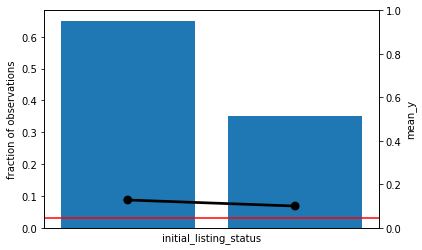

  labels  initial_listing_status    mean_y
0      f                0.650174  0.128289
1      w                0.349826  0.100470
initial_listing_status ^------------



In [445]:
plot_labels_frac_meanY(
    X=X_train, 
    y=y_train, 
    cardinality_df=cardinality_df, 
    colnames=catg_colnames, 
    ignore_colnames=None, 
    rare_lbl_threshold=0.03,
    plot_x_labels=True
)

### WOE / Ratio Encoding

Refrences:  
* https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#What-is-Weight-of-Evidence-WOE-
* https://contrib.scikit-learn.org/categorical-encoding/woe.html

In [446]:
catg_colnames

['term',
 'grade',
 'sub_grade',
 'employement_length',
 'home_ownership',
 'verification_status',
 'is_pymnt_plan_in_place',
 'loan_purpose',
 'loan_title',
 'zip_code',
 'addr_state',
 'initial_listing_status']

In [447]:
# Using WOE encoding on all the categorical features except addr_state 
# which uses ratio encoding because for some labels have either p(0) or 
# p(1) as 0 and hence woe is not defined.

colnames_for_woe = [colname for colname in catg_colnames if colname != 'addr_state']

In [449]:
woe_encoder = ce.WoERatioCategoricalEncoder(
    encoding_method='woe', 
    variables=colnames_for_woe
)

woe_encoder.fit(X_train, y_train)
X_train = woe_encoder.transform(X_train)
X_test = woe_encoder.transform(X_test)

In [450]:
ratio_encoder = ce.WoERatioCategoricalEncoder(
    encoding_method='ratio', 
    variables=['addr_state']
)

ratio_encoder.fit(X_train, y_train)
X_train = ratio_encoder.transform(X_train)
X_test = ratio_encoder.transform(X_test)

In [451]:
with open('./3_4.pkl', 'wb') as f:
    pickle.dump([X_train, X_test, y_train, y_test], f)
    f.close()

In [452]:
with open('./3_4.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)
    f.close()

In [453]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((326399, 56), (139886, 56), (326399,), (139886,))

In [321]:
def view_label_fraction(df, cardinality_df, catg_colnames):
    to_plot_colnames = cardinality_df.loc[cardinality_df['cardinality'] < 500, 'colname'].tolist()
    for colname in catg_colnames:
        label_frac = pd.Series(X_train[colname].value_counts() / len(X_train) )
        print()
        print(colname, '<----')
        print(label_frac)
        
        if colname in to_plot_colnames:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            ax.bar(label_frac.index, label_frac)
            ax.set_xticks([])
            ax.set_xlabel(colname)
            ax.axhline(y=0.05, color='red')
            ax.set_ylabel('fraction of observations')
            plt.show()
            plt.close()

In [275]:
# Most frequent imputer for discrete numeric features (using SimpleImputer from Sklearn)
# When using SimpleImputer, adjust for change of order of columns and the datatypes.
# Sklearn based transformers also change the index. Adjust the index after converting 
# numpy Array into DataFrame


num_most_freq_imputer_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

col_transfomer = ColumnTransformer(transformers=[
    ('num_most_freq_imputer', num_most_freq_imputer_pipe, disc_num_colnames_low_nan_frac),
], remainder='passthrough')

col_transfomer.fit(X_train)

remainder_col_idxs = col_transfomer.transformers_[1][2]
remainder_colnames = [X_train.columns.tolist()[col_idx] for col_idx in remainder_col_idxs]

X_train_index = X_train.index
X_test_index = X_test.index
# returns Nd-array
X_train = col_transfomer.transform(X_train)
X_test = col_transfomer.transform(X_test)

# Retruns dataframe. Notice the change in order of columns.
X_train = pd.DataFrame(X_train, columns = disc_num_colnames_low_nan_frac + remainder_colnames)
X_test = pd.DataFrame(X_test, columns = disc_num_colnames_low_nan_frac + remainder_colnames)

X_train.index = X_train_index
X_test.index = X_test_index

X_train = X_train.astype(dtype=predictors_dtype_map)
X_test = X_test.astype(dtype=predictors_dtype_map)

print(set(predictors) == set(X_train.columns.tolist()))
# Are there any duplicate columns? If True, no duplicate columns
print(len(set(X_train.columns.tolist())) == len(X_train.columns.tolist()))

In [283]:
num_most_freq_imputer_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

col_transfomer = ColumnTransformer(transformers=[
    ('num_most_freq_imputer', num_most_freq_imputer_pipe, disc_num_colnames_high_nan_frac),
], remainder='passthrough')

col_transfomer.fit(X_train)

remainder_col_idxs = col_transfomer.transformers_[1][2]
remainder_colnames = [X_train.columns.tolist()[col_idx] for col_idx in remainder_col_idxs]

X_train_index = X_train.index
X_test_index = X_test.index

# returns Nd-array
X_train = col_transfomer.transform(X_train)
X_test = col_transfomer.transform(X_test)

# Retruns dataframe. Notice the change in order of columns.
X_train = pd.DataFrame(X_train, columns = disc_num_colnames_high_nan_frac + remainder_colnames)
X_test = pd.DataFrame(X_test, columns = disc_num_colnames_high_nan_frac + remainder_colnames)

X_train.index = X_train_index
X_test.index = X_test_index

X_train = X_train.astype(dtype=predictors_dtype_map)
X_test = X_test.astype(dtype=predictors_dtype_map)

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num_most_freq_imputer', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0))]), ['months_since_last_record', 'months_since_last_rating_derog', 'months_since_last_delinq'])])

In [482]:
n_rows = X_train_tmp.shape[0]
label_frac = pd.Series(X_train_tmp['no_of_delinquencies'].value_counts() / n_rows)
label_frac_df = (label_frac
    .to_frame()
    .reset_index()
    .rename(columns={'index': 'labels'})
)

In [483]:
label_frac_df

labels  no_of_delinquencies
0      0             0.820946
1      1             0.120843
2      2             0.035138
3   Rare             0.023073

In [502]:
type(label_frac_df['labels'][1])

str

In [499]:
label_frac_df['labels'] = label_frac_df.astype(dtype={'labels': 'str'})

In [500]:
label_frac_df.dtypes

labels                  object
no_of_delinquencies    float64
dtype: object